In [1]:
import os
os.chdir('..')

In [2]:
from deterministic.homogeneous import solve_homogeneous_system, compute_diagram, compute_2D_diagram, compute_2D_botnet, compute_botnet_threshold, compute_protection
from deterministic.plots import plot_evolution, plot_diagram, plot_2D_diagram, plot_3D_protected, plot_2D_botnet, plot_botnet_threshold

import numpy as np
import pandas as pd
import pathlib
import pickle
from scipy.stats import bootstrap

# SEIR limit

If we set $\beta_B = 0$ and $\gamma = 0$ we should recover the classical SEIR model in which the epidemic threshold can be estimated following the next-generation matrix approach as [Diekmann et al.](https://doi.org/10.1098%2Frsif.2009.0386):

$$ F = \left(\begin{array}{cc} 0 & \beta_W \\ 0 & 0\end{array}\right),~~
V = \left(\begin{array}{cc} -\epsilon & 0 \\ \epsilon & -\mu\end{array}\right)$$

So that:
$$V^{-1} = \left(\begin{array}{cc} -1/\epsilon & 0 \\ -1/\mu & -1/\mu\end{array}\right)$$

And:

$$FV^{-1} = \left(\begin{array}{cc} \beta_W/\mu & \beta_W/\mu \\ 0 & 0 \end{array}\right)$$

So that the spectral radius is:

$$R_0 = \rho(-FV^{-1}) = \frac{\beta}{\mu}$$

First, we check the time evolution of the system for this limit with $\beta_W = 1$, $\epsilon = 0.1$ and $\mu=0.2$.

In [3]:
parameters = {
    'beta': {'B': 0, 'W': 1},
    'epsilon': 0.1,
    'gamma': 0,
    'mu': 0.2
}

dt = 0.1
result = solve_homogeneous_system(parameters, 200, initial_B=0, dt=dt)

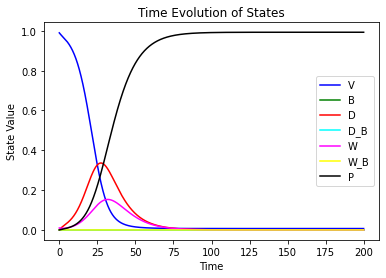

In [4]:
plot_evolution(result, dt=dt)

Now we study the final fraction of $P$ as a function of $\beta$ and some values of $\mu$ with fixed $\epsilon$, together with the theoretical epidemic threshold.

In [5]:
parameters = {
    'beta': {'B': 0, 'W': 1},
    'epsilon': 0.1,
    'gamma': 0,
    'mu': 0.2
}

beta = np.exp(np.linspace(-5, 1, 100))
mu_values = [0.25, 0.50, 0.75, 1.00]
dt = 0.01

data = []
for mu in mu_values:
    parameters['mu'] = mu
    result = compute_diagram(parameters, 1000, beta_W=beta, initial_W=0.0001, initial_B=0, dt=dt)
    data.append({'legend': f'ep=0.1, gam=0, mu={mu}', 'data': result, 'threshold': mu})

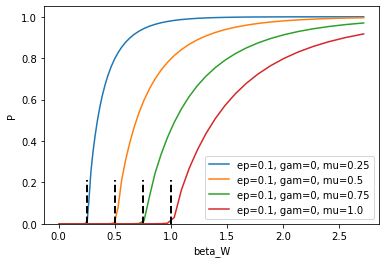

In [6]:
plot_diagram(data)

As expected, it seems that the threshold varies proportionally to $\mu$, so that we can plot the same diagram as a function of $\beta/\mu$ instead.

In [7]:
data_norm = data
for idx, mu in enumerate(mu_values):
    data_norm[idx]['data'][:, 0] = data_norm[idx]['data'][:, 0]/mu
    data_norm[idx]['threshold'] = data_norm[idx]['threshold']/mu

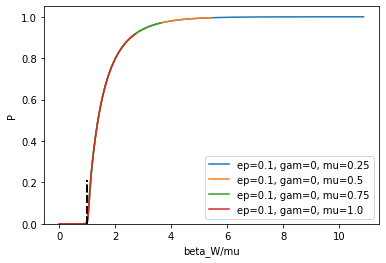

In [8]:
plot_diagram(data_norm, label_x='beta_W/mu')

In fact, we can always rescale time in terms of $\mu$. Hence, from now own we will work always in units of $\mu$.

Let's now look at how this changes as a function of epsilon.

In [9]:
parameters = {
    'beta': {'B': 0, 'W': 1},
    'epsilon': 0.1,
    'gamma': 0,
    'mu': 1
}

beta = np.exp(np.linspace(-5, 1, 100))
epsilon_values = [0.25, 0.50, 0.75, 1.00]
dt = 0.01

data = []
for epsilon in epsilon_values:
    parameters['epsilon'] = epsilon
    result = compute_diagram(parameters, 1000, beta_W=beta, initial_W=0.0001, initial_B=0, dt=dt)
    data.append({'legend': f'ep={epsilon}, gam=0', 'data': result, 'threshold': 1})

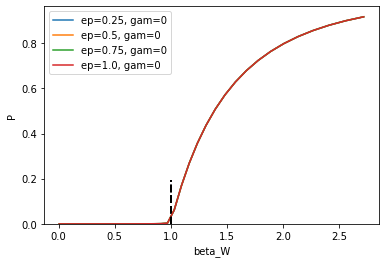

In [10]:
plot_diagram(data)

As expected, the threshold is not affected by the value of $\epsilon$. Furthermore, neither is the overall shape.

# SEIR with latent death

If we now set $\gamma \neq 0$, it is equivalent to a SEIR model in which people in the latent state can spontaneously recover/die. The epidemic threshold in this case can be computed as:

$$ F = \left(\begin{array}{cc} 0 & \beta_W \\ 0 & 0\end{array}\right),~~
V = \left(\begin{array}{cc} -\epsilon - \gamma & 0 \\ \epsilon & -\mu\end{array}\right)$$

So that:
$$V^{-1} = \left(\begin{array}{cc} -1/(\epsilon + \gamma) & 0 \\ -\epsilon/[(\epsilon+\gamma)\mu] & -1/\mu\end{array}\right)$$

And:

$$FV^{-1} = \left(\begin{array}{cc} \beta_W\epsilon/[(\epsilon+\gamma)\mu] & \beta_W/\mu \\ 0 & 0 \end{array}\right)$$

So that the spectral radius is:

$$R_0 = \rho(-FV^{-1}) = \frac{\beta}{\mu} \cdot \frac{\epsilon}{\epsilon + \gamma}$$

Thus, we now see that the epidemic threshold not only depends on the value of $\gamma$ but also on the value of $\epsilon$, which had dissapeared previously. In fact, we can show that it actually depends on the ratio between these quantities.

$$R_0 = \frac{\beta}{\mu} \cdot \frac{\epsilon/\gamma}{\epsilon/\gamma + 1} \equiv \frac{\beta}{\mu} \frac{\epsilon'}{\epsilon'+1}$$

In [11]:
parameters = {
    'beta': {'B': 0, 'W': 1},
    'epsilon': 0.2,
    'gamma': 0,
    'mu': 1.0
}

beta = np.exp(np.linspace(-5, 2, 100))
dt = 0.01

data = []
for gamma in [0.1, 0.2, 0.4]:
    ep = parameters['epsilon']/gamma
    parameters['gamma'] = gamma
    result = compute_diagram(parameters, 1000, beta_W=beta, initial_W=0.0001, initial_B=0, dt=dt)
    data.append({'legend': f'ep=0.2, gam={gamma}', 'data': result, 'threshold': (ep+1)/ep})

parameters['epsilon'] = 0.1
for gamma in [0.05, 0.1, 0.2]:
    ep = parameters['epsilon']/gamma
    parameters['gamma'] = gamma
    result = compute_diagram(parameters, 1000, beta_W=beta, initial_W=0.0001, initial_B=0, dt=dt)
    data.append({'legend': f'ep=0.1, gam={gamma}', 'data': result, 'threshold': (ep+1)/ep})

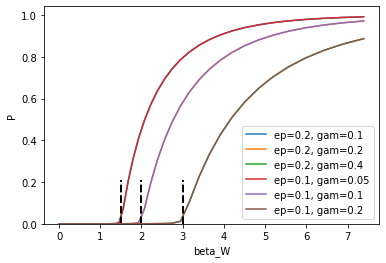

In [12]:
plot_diagram(data)

We see that, indeed, the evolution only depends on the fraction $\epsilon'\equiv\epsilon/\gamma$. Thus, we can conclude that the system can be simply studied in the $\beta,\epsilon'$.

In [13]:
parameters = {
    'beta': {'B': 0, 'W': 0},
    'epsilon': 0.1,
    'gamma': 1,
    'mu': 1
}

beta = np.linspace(0.01, 10, 100)
epsilon = np.linspace(0.01, 2, 100)
dt = 0.01

result = compute_2D_diagram(parameters, 1000, beta_W=beta, epsilon_p=epsilon, initial_W=0.0001, initial_B=0, dt=dt)

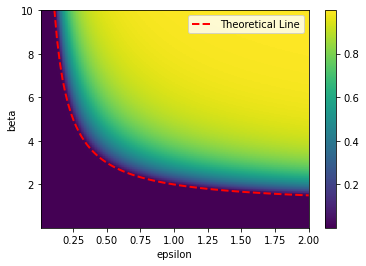

In [14]:
plot_2D_diagram(result)

# Complete model

Since both infections are completely independent, adding the black worm should not alter the diagram. In the following, we reproduce this last 2D diagram but setting $\beta_B\neq 0$.

In [15]:
parameters = {
    'beta': {'B': 0.5, 'W': 0},
    'epsilon': 0.1,
    'gamma': 1,
    'mu': 1
}

beta = np.linspace(0.01, 10, 100)
epsilon = np.linspace(0.01, 2, 100)
dt = 0.01

result = compute_2D_diagram(parameters, 1000, beta_W=beta, epsilon_p=epsilon, initial_W=0.0001, initial_B=0.0001, dt=dt)

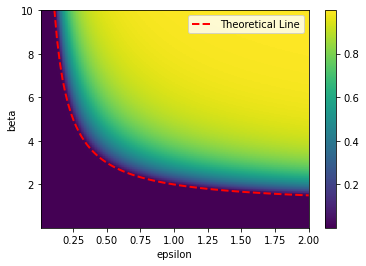

In [16]:
plot_2D_diagram(result)

We can also plot the diagram for $R_0$.

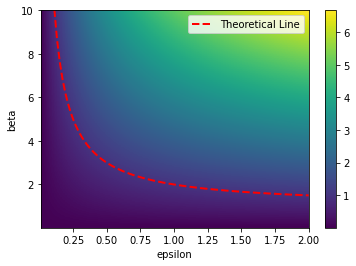

In [17]:
data = result.copy()
data[:, 2] = (data[:, 0]/parameters['mu'])*((data[:, 1]/parameters['gamma'])/(data[:,1]/parameters['gamma'] + 1))
plot_2D_diagram(data)

We can use these values to test what is the final fraction of the population in the $B$ state given that the final fraction of recovered people in the SEIR model is given by [Britton et al.](https://doi.org/10.1007/978-3-030-30900-8):

$$\rho_P = 1 - e^{-R_0 \rho_P} $$

We can compare the values from this equation to the numerical solutions of the model.

In [18]:
parameters = {
    'beta': {'B': 0.5, 'W': 0},
    'epsilon': 0.1,
    'gamma': 1,
    'mu': 1
}

beta = np.linspace(0.01, 10, 20)
epsilon = np.linspace(0.01, 2, 20)
dt = 0.01

result = compute_2D_diagram(parameters, 1000, beta_W=beta, epsilon_p=epsilon, initial_W=0.0001, initial_B=0.0001, dt=dt)

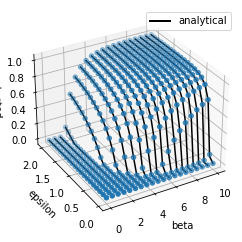

In [19]:
plot_3D_protected(result)

The last elements of the model are the maximum fraction of the population in the $B$ state and the time window in which said fraction is above a certain threshold.

Actually, we can estimate for which set of parameters the white worm will completely prevent the creation of a botnet. For the black worm, if we are near the disease-free state, we can approximate its evolution as [Ma](https://doi.org/10.1016%2Fj.idm.2019.12.009):

$$\dot{\rho}_B \approx \beta_B \rho_B$$

So that in the early phase of the outbreak the size of the botnet will grow as:

$$\rho_B(t) = \rho_B(0) e^{\beta t}$$

In other words, the size of the outbreak grows at rate $\beta_B$.

Similarly, for the white worm, in the early phase of the infection we have:

$$\dot{\rho}_D \approx \beta_W \rho_W - (\epsilon + \gamma) \rho_D$$
$$\dot{\rho}_W \approx \epsilon \rho_D - \mu \rho_W$$

So that the jacobian is:

$$J = \left[\begin{array}{cc} -(\epsilon + \gamma) & \beta_W \\ \epsilon & -\mu \end{array}\right] $$

And its eigenvalues, since it is a 2x2 matrix, can be easily obtained using its trace:

$$\lambda = \frac{tr(J) \pm \sqrt{(tr(J))^2 - 4\det(J)}}{2}$$

$$\Rightarrow \lambda = \frac{-(\epsilon + \gamma + \mu) \pm \sqrt{(-(\epsilon + \gamma + \mu))^2 - 4[(\epsilon + \gamma)\mu - \beta_W \epsilon]}}{2}$$

$$\lambda = \frac{-(\epsilon + \gamma + \mu) + \sqrt{(\epsilon+\gamma)^2 + \mu^2 + 2(\epsilon + \gamma)\mu - 4(\epsilon+\gamma)\mu + 4\beta_w\epsilon}}{2}$$

$$\lambda = \frac{-(\epsilon + \gamma + \mu) + \sqrt{(\epsilon+\gamma -\mu)^2 + 4\beta_w\epsilon}}{2}$$

So that the botnet can only grow if

$$2\beta_B \gt -(\epsilon + \gamma + \mu) + \sqrt{(\epsilon+\gamma -\mu)^2 + 4\beta_W\epsilon}$$

We can test this expression by studying the size of the botnet as a function of $\beta_B$ and $\beta_W$ for several values of $\epsilon$ and $\gamma$ (since we can set $\mu=1$ as previously discussed).

In [20]:
parameters = {
    'beta': {'B': 0.5, 'W': 0},
    'epsilon': 1,
    'gamma': 1,
    'mu': 1
}

beta_B = np.linspace(0.01, 10, 100)
beta_W = np.linspace(0.01, 10, 100)
dt = 0.01

result = compute_2D_botnet(parameters, 1000, beta_B, beta_W, initial_W=0.0001, initial_B=0.0001, dt=dt)

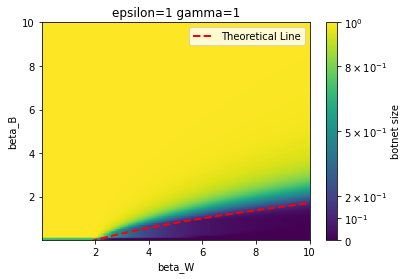

In [21]:
plot_2D_botnet(result)

In [22]:
parameters = {
    'beta': {'B': 0.5, 'W': 0},
    'epsilon': 0.5,
    'gamma': 1,
    'mu': 1
}

beta_B = np.linspace(0.01, 10, 100)
beta_W = np.linspace(0.01, 10, 100)
dt = 0.01

result = compute_2D_botnet(parameters, 1000, beta_B, beta_W, initial_W=0.0001, initial_B=0.0001, dt=dt)

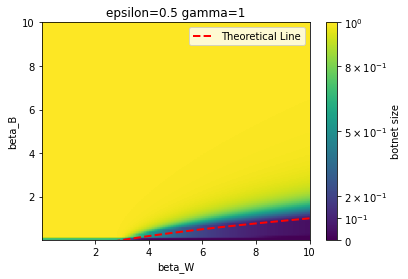

In [23]:
plot_2D_botnet(result, epsilon = 0.5)

In [24]:
parameters = {
    'beta': {'B': 0.5, 'W': 0},
    'epsilon': 2,
    'gamma': 1,
    'mu': 1
}

beta_B = np.linspace(0.01, 10, 100)
beta_W = np.linspace(0.01, 10, 100)
dt = 0.01

result = compute_2D_botnet(parameters, 1000, beta_B, beta_W, initial_W=0.0001, initial_B=0.0001, dt=dt)

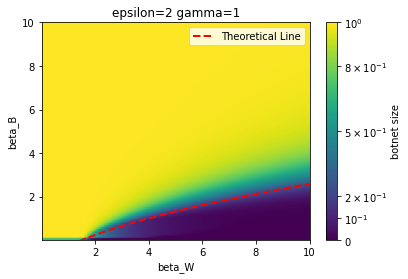

In [25]:
plot_2D_botnet(result, epsilon = 2)

In [26]:
parameters = {
    'beta': {'B': 0.5, 'W': 0},
    'epsilon': 2,
    'gamma': 0.1,
    'mu': 1
}

beta_B = np.linspace(0.01, 10, 100)
beta_W = np.linspace(0.01, 10, 100)
dt = 0.01

result = compute_2D_botnet(parameters, 1000, beta_B, beta_W, initial_W=0.0001, initial_B=0.0001, dt=dt)

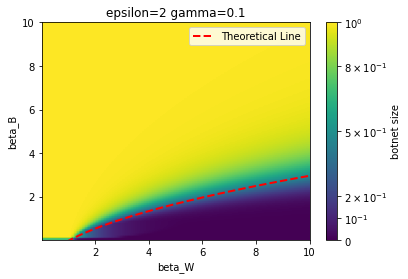

In [27]:
plot_2D_botnet(result, epsilon=2, gamma=0.1)

Given that the approximation works very well, we can focus on studying this threshold since it is the one that will ensure us that the botnet will not exist at any point. This way, we can easily explore its evolution for different values of $\epsilon$ and $\gamma$.

In the following, we explore the model with $\gamma = 1$.

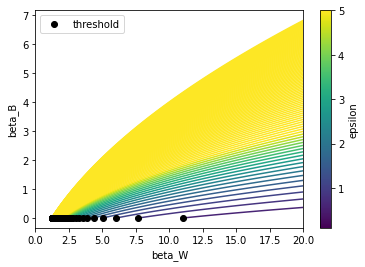

In [28]:
plot_botnet_threshold(20, np.linspace(0.1, 5, 100), gamma = 1, mu = 1)

As we can see, the smaller the value of $\epsilon$, the larger $\beta_W$ has to be to prevent the appearance of a botnet. In the limit in which $\epsilon \rightarrow \infty$ we should recover the SIR model in which the growth rate is simply $\beta_W - \mu$. Thus, the botnet may be prevented if $\beta_W > \beta_B + \mu = \beta_B + 1$.

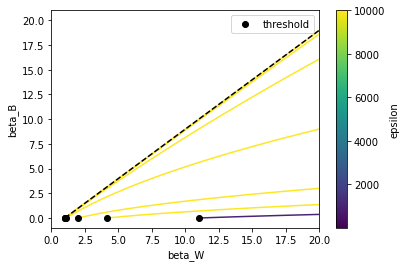

In [29]:
plot_botnet_threshold(20, np.array([10**x for x in [-1, -0.5, 0, 1, 2, 3, 4]]), gamma = 1, mu = 1, th=True)

We can now explore the role of $\gamma$ with fixed $\epsilon=1$:

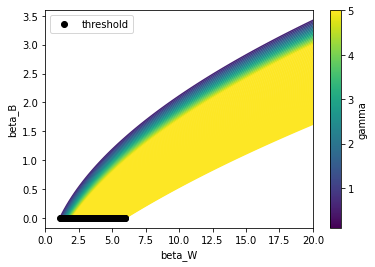

In [30]:
plot_botnet_threshold(20, epsilon=1, gamma=np.linspace(0.1, 5, 100), mu=1)

And, for instance, for $\epsilon=10$:

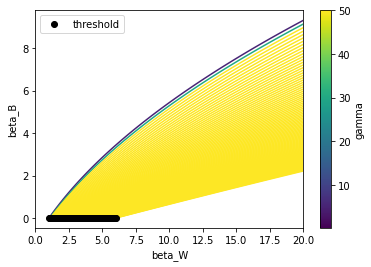

In [31]:
plot_botnet_threshold(20, epsilon=10, gamma=np.linspace(0.1, 50, 100), mu=1)

As expected, the larger the value of $\gamma$, the harder it is to prevent the aparition of a botnet. 

Lastly, we'll look at the amount of time a botnet is above a critical size, which means that it can be used to perform an attack. The theoretical W size represents the maximum spread of the white worm (1 - threshold). We can see that if it only spreads up to ~60% of the system, 40% of the system will essentially be infected for the whole simulation. If we look closer there is a range of values where it will fit for a while, but still if it doesn't cover the whole system, it is useless.

In [32]:
import numpy as np
from deterministic.homogeneous import compute_botnet_threshold
from deterministic.plots import plot_2D_botnet_time

In [33]:
parameters = {
    'beta': {'B': 1, 'W': 2},
    'epsilon': 1,
    'gamma': 1,
    'mu': 1
}
t, V, B, D, DB, W, WB, P = list(range(8))

force_rate_list = np.linspace(0.01, 10, 100)
threshold_list = np.linspace(0, 1.0, 100)

a = compute_botnet_threshold(parameters, 1000, force_rate_list, threshold_list)

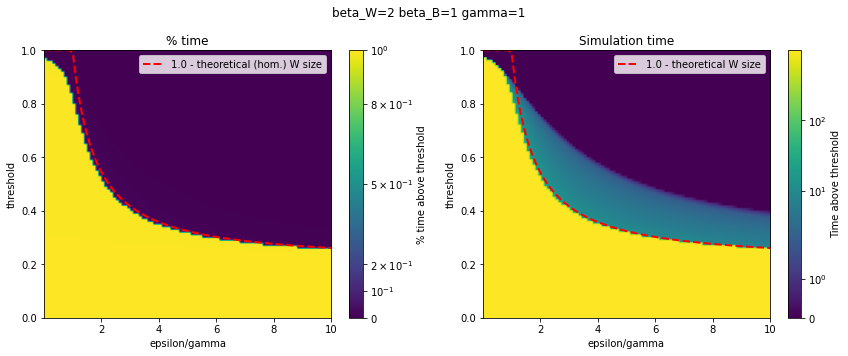

In [34]:
plot_2D_botnet_time(a, parameters['beta']['W'], parameters['beta']['B'], parameters['gamma'])

In [35]:
parameters = {
    'beta': {'B': 1, 'W': 2},
    'epsilon': 1,
    'gamma': 0.5,
    'mu': 1
}
t, V, B, D, DB, W, WB, P = list(range(8))

force_rate_list = np.linspace(0.01, 10, 100)
threshold_list = np.linspace(0, 1.0, 100)

a = compute_botnet_threshold(parameters, 1000, force_rate_list, threshold_list)

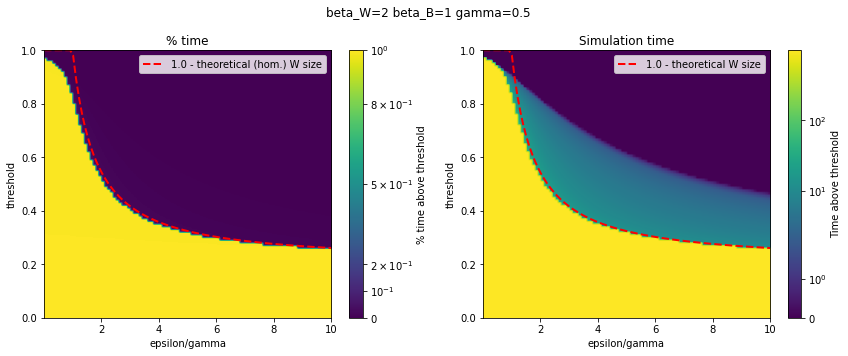

In [36]:
plot_2D_botnet_time(a, parameters['beta']['W'], parameters['beta']['B'], parameters['gamma'])

In [37]:
parameters = {
    'beta': {'B': 1, 'W': 2},
    'epsilon': 1,
    'gamma': 2,
    'mu': 1
}
t, V, B, D, DB, W, WB, P = list(range(8))

force_rate_list = np.linspace(0.01, 10, 100)
threshold_list = np.linspace(0, 1.0, 100)

a = compute_botnet_threshold(parameters, 1000, force_rate_list, threshold_list)

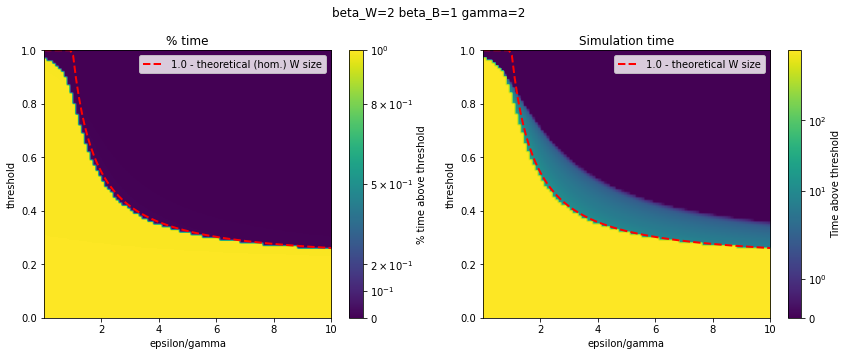

In [38]:
plot_2D_botnet_time(a, parameters['beta']['W'], parameters['beta']['B'], parameters['gamma'])

In [39]:
parameters = {
    'beta': {'B': 1, 'W': 3},
    'epsilon': 1,
    'gamma': 1,
    'mu': 1
}
t, V, B, D, DB, W, WB, P = list(range(8))

force_rate_list = np.linspace(0.01, 10, 100)
threshold_list = np.linspace(0, 1.0, 100)

a = compute_botnet_threshold(parameters, 1000, force_rate_list, threshold_list)

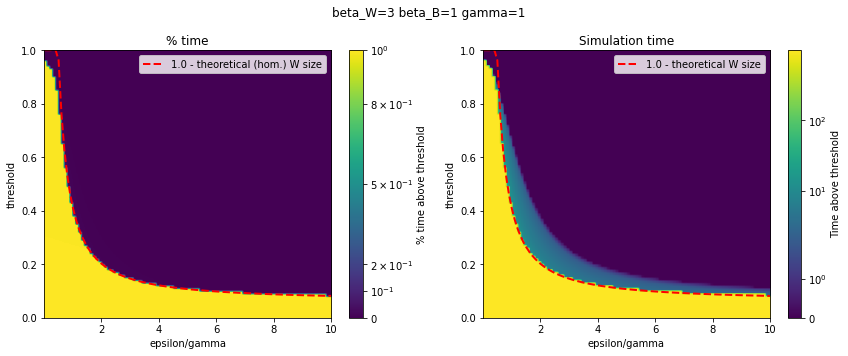

In [40]:
plot_2D_botnet_time(a, parameters['beta']['W'], parameters['beta']['B'], parameters['gamma'])

In [41]:
parameters = {
    'beta': {'B': 2, 'W': 6},
    'epsilon': 1,
    'gamma': 1,
    'mu': 1
}
t, V, B, D, DB, W, WB, P = list(range(8))

force_rate_list = np.linspace(0.01, 10, 100)
threshold_list = np.linspace(0, 1.0, 100)

a = compute_botnet_threshold(parameters, 1000, force_rate_list, threshold_list)

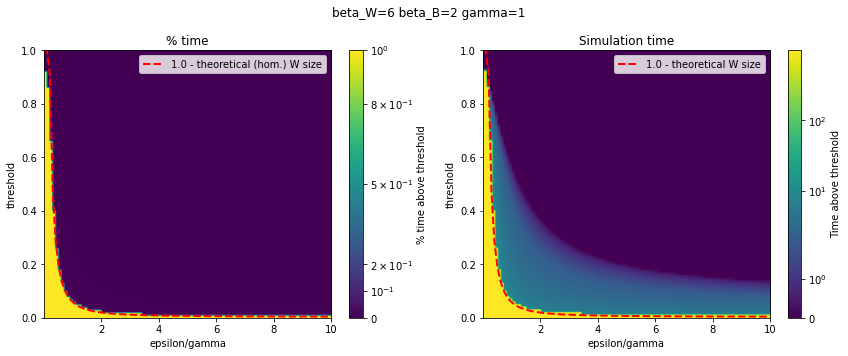

In [42]:
plot_2D_botnet_time(a, parameters['beta']['W'], parameters['beta']['B'], parameters['gamma'])

# Comparison with the complete graph

Now that we have a good understanding of the model, we can try to reproduce some of the results with the Gillespie algorithm on the complete graph to check if it's correct. In particular, we will focus on the final fraction of protected nodes as a function of $\beta_W$ and $\epsilon$, and the size of the botnet as a function of $\beta_B$ and $\beta_W$.

In [43]:
results = np.empty((0, 3))
for file_path in pathlib.Path('results').glob('protected_CG_N1000_*'):

    bW = float(file_path.stem.split('_bW')[1].split('_')[0])
    e = float(file_path.stem.split('_e')[1].split('_')[0])

    with open(file_path, 'rb') as file:
        data_list = pickle.load(file)

    protected = [x for x in data_list if x > 0.01]
    protected = np.median(protected) if len(protected) else 0

    results = np.vstack((results,
                         np.array([bW, e, protected])))

results = results[results[:, 1].argsort()]
results = results[results[:, 0].argsort(kind='mergesort')]

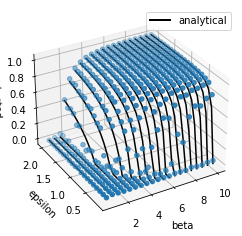

In [44]:
plot_3D_protected(results)

In [45]:
results = np.empty((0, 3))
for file_path in pathlib.Path('results').glob('botnet_CG_N1000_*'):

    bB = float(file_path.stem.split('_bB')[1].split('_')[0])
    bW = float(file_path.stem.split('_bW')[1].split('_')[0])

    with open(file_path, 'rb') as file:
        data_list = pickle.load(file)

    botnet = [botnet for botnet, protected in data_list if protected > 0.01]
    botnet = np.mean(botnet) if len(botnet) else 1

    results = np.vstack((results,
                         np.array([bB, bW, botnet])))

results = results[results[:, 1].argsort()]
results = results[results[:, 0].argsort(kind='mergesort')]

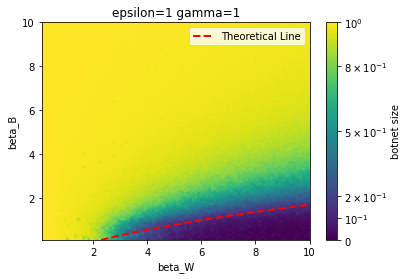

In [46]:
plot_2D_botnet(results)

# Cells to extract data for the paper

In [47]:
# Figure 2A
parameters = {
    'beta': {'B': 0.5, 'W': 0},
    'epsilon': 0.1,
    'gamma': 1,
    'mu': 1
}

beta = np.linspace(0.01, 10, 20)
epsilon = [0.1, 0.15, 0.2, 0.3, 0.6, 1.0, 2.0]
dt = 0.01

result = compute_2D_diagram(parameters, 1000, beta_W=beta, epsilon_p=epsilon, initial_W=0.0001, initial_B=0.0001, dt=dt)

data = pd.DataFrame({'beta': result[:, 0], 'epsilon': result[:, 1], 'protected': result[:, 2]})
data.to_csv('plots/data/homogeneous_protection_3D.csv', index=False)

In [48]:
# Figure 2B
parameters = {
    'beta': {'B': 0, 'W': 0},
    'epsilon': 0,
    'gamma': 1,
    'mu': 1
}

epsilon = np.logspace(-1, 1, 200)

dfs = []
for beta_W in [2, 5, 8]:
    parameters['beta']['W'] = beta_W

    result = compute_protection(parameters, 1000, epsilon_list=epsilon, initial_W=0.0001, initial_B=0)

    dfs.append(pd.DataFrame({'beta': result[:, 0], 'epsilon': result[:, 1], 'gamma': result[:, 2],
                             'protected': result[:, 3], 'self': result[:, 4], 'forced': result[:, 5]}))

data = pd.concat(dfs, ignore_index=True)
data.to_csv('plots/data/homogeneous_protection_self_forced.csv', index=False)

In [50]:
# Figure 2C
parameters = {
    'beta': {'B': 0.5, 'W': 0},
    'epsilon': 1,
    'gamma': 1,
    'mu': 1
}

beta_B = np.linspace(0.01, 10, 200)
beta_W = np.linspace(0.01, 10, 200)
dt = 0.01

result = compute_2D_botnet(parameters, 1000, beta_B, beta_W, initial_W=0.0001, initial_B=0.0001, dt=dt)

data = pd.DataFrame({'beta_b': result[:, 0], 'beta_w': result[:, 1], 'botnet': result[:, 2]})
data.to_csv('plots/data/homogeneous_botnet_size.csv', index=False)

In [54]:
# Figure 2D
parameters = {
    'beta': {'B': 1, 'W': 2},
    'epsilon': 1,
    'gamma': 1,
    'mu': 1
}
t, V, B, D, DB, W, WB, P = list(range(8))

force_rate_list = np.linspace(0.01, 10, 200)
threshold_list = np.linspace(0, 1.0, 200)

result = compute_botnet_threshold(parameters, 100, force_rate_list, threshold_list)

data = pd.DataFrame({'forced_rate': result[:, 0], 'threshold': result[:, 1], 'time': result[:, 2], 'total_time': result[:, 3]})
data.to_csv('plots/data/homogeneous_botnet_time.csv', index=False)

In [55]:
# Figure S2A
parameters = {
    'beta': {'B': 1, 'W': 6},
    'epsilon': 1,
    'gamma': 1,
    'mu': 1
}
t, V, B, D, DB, W, WB, P = list(range(8))

force_rate_list = np.linspace(0.01, 10, 200)
threshold_list = np.linspace(0, 1.0, 200)

result = compute_botnet_threshold(parameters, 100, force_rate_list, threshold_list)

data = pd.DataFrame({'forced_rate': result[:, 0], 'threshold': result[:, 1], 'time': result[:, 2], 'total_time': result[:, 3]})
data.to_csv('plots/data/homogeneous_botnet_time_SM_W6.csv', index=False)

In [3]:
# Figure S2B
parameters = {
    'beta': {'B': 1, 'W': 2},
    'epsilon': 1,
    'gamma': 0.5,
    'mu': 1
}
t, V, B, D, DB, W, WB, P = list(range(8))

force_rate_list = np.linspace(0.01, 10, 200)
threshold_list = np.linspace(0, 1.0, 200)

result = compute_botnet_threshold(parameters, 100, force_rate_list, threshold_list)

data = pd.DataFrame({'forced_rate': result[:, 0], 'threshold': result[:, 1], 'time': result[:, 2], 'total_time': result[:, 3]})
data.to_csv('plots/data/homogeneous_botnet_time_SM_G05.csv', index=False)

gamma = 0.5, epsilon = 0.005
gamma = 0.5, epsilon = 0.030100502512562816
gamma = 0.5, epsilon = 0.05520100502512563
gamma = 0.5, epsilon = 0.08030150753768844
gamma = 0.5, epsilon = 0.10540201005025127
gamma = 0.5, epsilon = 0.1305025125628141
gamma = 0.5, epsilon = 0.15560301507537688
gamma = 0.5, epsilon = 0.1807035175879397
gamma = 0.5, epsilon = 0.20580402010050253
gamma = 0.5, epsilon = 0.23090452261306535
gamma = 0.5, epsilon = 0.25600502512562817
gamma = 0.5, epsilon = 0.28110552763819097
gamma = 0.5, epsilon = 0.30620603015075376
gamma = 0.5, epsilon = 0.3313065326633166
gamma = 0.5, epsilon = 0.3564070351758794
gamma = 0.5, epsilon = 0.38150753768844226
gamma = 0.5, epsilon = 0.40660804020100505
gamma = 0.5, epsilon = 0.43170854271356784
gamma = 0.5, epsilon = 0.4568090452261307
gamma = 0.5, epsilon = 0.4819095477386935
gamma = 0.5, epsilon = 0.5070100502512563
gamma = 0.5, epsilon = 0.5321105527638191
gamma = 0.5, epsilon = 0.5572110552763819
gamma = 0.5, epsilon = 0.58231155

gamma = 0.5, epsilon = 0.5070100502512563
gamma = 0.5, epsilon = 0.5321105527638191
gamma = 0.5, epsilon = 0.5572110552763819
gamma = 0.5, epsilon = 0.5823115577889447
gamma = 0.5, epsilon = 0.6074120603015075
gamma = 0.5, epsilon = 0.6325125628140704
gamma = 0.5, epsilon = 0.6576130653266332
gamma = 0.5, epsilon = 0.682713567839196
gamma = 0.5, epsilon = 0.7078140703517588
gamma = 0.5, epsilon = 0.7329145728643216
gamma = 0.5, epsilon = 0.7580150753768845
gamma = 0.5, epsilon = 0.7831155778894473
gamma = 0.5, epsilon = 0.8082160804020101
gamma = 0.5, epsilon = 0.8333165829145729
gamma = 0.5, epsilon = 0.8584170854271357
gamma = 0.5, epsilon = 0.8835175879396986
gamma = 0.5, epsilon = 0.9086180904522614
gamma = 0.5, epsilon = 0.9337185929648242
gamma = 0.5, epsilon = 0.958819095477387
gamma = 0.5, epsilon = 0.9839195979899498
gamma = 0.5, epsilon = 1.0090201005025126
gamma = 0.5, epsilon = 1.0341206030150754
gamma = 0.5, epsilon = 1.0592211055276382
gamma = 0.5, epsilon = 1.08432160804

gamma = 0.5, epsilon = 0.8082160804020101
gamma = 0.5, epsilon = 0.8333165829145729
gamma = 0.5, epsilon = 0.8584170854271357
gamma = 0.5, epsilon = 0.8835175879396986
gamma = 0.5, epsilon = 0.9086180904522614
gamma = 0.5, epsilon = 0.9337185929648242
gamma = 0.5, epsilon = 0.958819095477387
gamma = 0.5, epsilon = 0.9839195979899498
gamma = 0.5, epsilon = 1.0090201005025126
gamma = 0.5, epsilon = 1.0341206030150754
gamma = 0.5, epsilon = 1.0592211055276382
gamma = 0.5, epsilon = 1.084321608040201
gamma = 0.5, epsilon = 1.1094221105527637
gamma = 0.5, epsilon = 1.1345226130653265
gamma = 0.5, epsilon = 1.1596231155778893
gamma = 0.5, epsilon = 1.1847236180904521
gamma = 0.5, epsilon = 1.209824120603015
gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.2600251256281407
gamma = 0.5, epsilon = 1.2851256281407035
gamma = 0.5, epsilon = 1.3102261306532663
gamma = 0.5, epsilon = 1.3353266331658291
gamma = 0.5, epsilon = 1.360427135678392
gamma = 0.5, epsilon = 1.38552763819095

gamma = 0.5, epsilon = 1.0090201005025126
gamma = 0.5, epsilon = 1.0341206030150754
gamma = 0.5, epsilon = 1.0592211055276382
gamma = 0.5, epsilon = 1.084321608040201
gamma = 0.5, epsilon = 1.1094221105527637
gamma = 0.5, epsilon = 1.1345226130653265
gamma = 0.5, epsilon = 1.1596231155778893
gamma = 0.5, epsilon = 1.1847236180904521
gamma = 0.5, epsilon = 1.209824120603015
gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.2600251256281407
gamma = 0.5, epsilon = 1.2851256281407035
gamma = 0.5, epsilon = 1.3102261306532663
gamma = 0.5, epsilon = 1.3353266331658291
gamma = 0.5, epsilon = 1.360427135678392
gamma = 0.5, epsilon = 1.3855276381909547
gamma = 0.5, epsilon = 1.4106281407035175
gamma = 0.5, epsilon = 1.4357286432160803
gamma = 0.5, epsilon = 1.460829145728643
gamma = 0.5, epsilon = 1.485929648241206
gamma = 0.5, epsilon = 1.511030150753769
gamma = 0.5, epsilon = 1.5361306532663317
gamma = 0.5, epsilon = 1.5612311557788945
gamma = 0.5, epsilon = 1.5863316582914573

gamma = 0.5, epsilon = 1.360427135678392
gamma = 0.5, epsilon = 1.3855276381909547
gamma = 0.5, epsilon = 1.4106281407035175
gamma = 0.5, epsilon = 1.4357286432160803
gamma = 0.5, epsilon = 1.460829145728643
gamma = 0.5, epsilon = 1.485929648241206
gamma = 0.5, epsilon = 1.511030150753769
gamma = 0.5, epsilon = 1.5361306532663317
gamma = 0.5, epsilon = 1.5612311557788945
gamma = 0.5, epsilon = 1.5863316582914573
gamma = 0.5, epsilon = 1.61143216080402
gamma = 0.5, epsilon = 1.6365326633165829
gamma = 0.5, epsilon = 1.6616331658291457
gamma = 0.5, epsilon = 1.6867336683417085
gamma = 0.5, epsilon = 1.7118341708542713
gamma = 0.5, epsilon = 1.736934673366834
gamma = 0.5, epsilon = 1.762035175879397
gamma = 0.5, epsilon = 1.7871356783919599
gamma = 0.5, epsilon = 1.8122361809045227
gamma = 0.5, epsilon = 1.8373366834170854
gamma = 0.5, epsilon = 1.8624371859296482
gamma = 0.5, epsilon = 1.887537688442211
gamma = 0.5, epsilon = 1.9126381909547738
gamma = 0.5, epsilon = 1.9377386934673366
g

gamma = 0.5, epsilon = 2.0883417085427136
gamma = 0.5, epsilon = 2.1134422110552764
gamma = 0.5, epsilon = 2.138542713567839
gamma = 0.5, epsilon = 2.163643216080402
gamma = 0.5, epsilon = 2.188743718592965
gamma = 0.5, epsilon = 2.2138442211055276
gamma = 0.5, epsilon = 2.2389447236180904
gamma = 0.5, epsilon = 2.264045226130653
gamma = 0.5, epsilon = 2.289145728643216
gamma = 0.5, epsilon = 2.3142462311557788
gamma = 0.5, epsilon = 2.3393467336683416
gamma = 0.5, epsilon = 2.3644472361809044
gamma = 0.5, epsilon = 2.389547738693467
gamma = 0.5, epsilon = 2.41464824120603
gamma = 0.5, epsilon = 2.439748743718593
gamma = 0.5, epsilon = 2.464849246231156
gamma = 0.5, epsilon = 2.4899497487437188
gamma = 0.5, epsilon = 2.5150502512562816
gamma = 0.5, epsilon = 2.5401507537688444
gamma = 0.5, epsilon = 2.565251256281407
gamma = 0.5, epsilon = 2.59035175879397
gamma = 0.5, epsilon = 2.6154522613065327
gamma = 0.5, epsilon = 2.6405527638190955
gamma = 0.5, epsilon = 2.6656532663316583
gamma

gamma = 0.5, epsilon = 2.2138442211055276
gamma = 0.5, epsilon = 2.2389447236180904
gamma = 0.5, epsilon = 2.264045226130653
gamma = 0.5, epsilon = 2.289145728643216
gamma = 0.5, epsilon = 2.3142462311557788
gamma = 0.5, epsilon = 2.3393467336683416
gamma = 0.5, epsilon = 2.3644472361809044
gamma = 0.5, epsilon = 2.389547738693467
gamma = 0.5, epsilon = 2.41464824120603
gamma = 0.5, epsilon = 2.439748743718593
gamma = 0.5, epsilon = 2.464849246231156
gamma = 0.5, epsilon = 2.4899497487437188
gamma = 0.5, epsilon = 2.5150502512562816
gamma = 0.5, epsilon = 2.5401507537688444
gamma = 0.5, epsilon = 2.565251256281407
gamma = 0.5, epsilon = 2.59035175879397
gamma = 0.5, epsilon = 2.6154522613065327
gamma = 0.5, epsilon = 2.6405527638190955
gamma = 0.5, epsilon = 2.6656532663316583
gamma = 0.5, epsilon = 2.690753768844221
gamma = 0.5, epsilon = 2.715854271356784
gamma = 0.5, epsilon = 2.7409547738693467
gamma = 0.5, epsilon = 2.7660552763819095
gamma = 0.5, epsilon = 2.7911557788944723
gamm

gamma = 0.5, epsilon = 2.6656532663316583
gamma = 0.5, epsilon = 2.690753768844221
gamma = 0.5, epsilon = 2.715854271356784
gamma = 0.5, epsilon = 2.7409547738693467
gamma = 0.5, epsilon = 2.7660552763819095
gamma = 0.5, epsilon = 2.7911557788944723
gamma = 0.5, epsilon = 2.816256281407035
gamma = 0.5, epsilon = 2.841356783919598
gamma = 0.5, epsilon = 2.8664572864321607
gamma = 0.5, epsilon = 2.8915577889447235
gamma = 0.5, epsilon = 2.9166582914572863
gamma = 0.5, epsilon = 2.941758793969849
gamma = 0.5, epsilon = 2.9668592964824123
gamma = 0.5, epsilon = 2.991959798994975
gamma = 0.5, epsilon = 3.017060301507538
gamma = 0.5, epsilon = 3.0421608040201007
gamma = 0.5, epsilon = 3.0672613065326635
gamma = 0.5, epsilon = 3.0923618090452263
gamma = 0.5, epsilon = 3.117462311557789
gamma = 0.5, epsilon = 3.142562814070352
gamma = 0.5, epsilon = 3.1676633165829147
gamma = 0.5, epsilon = 3.1927638190954775
gamma = 0.5, epsilon = 3.2178643216080403
gamma = 0.5, epsilon = 3.242964824120603
ga

gamma = 0.5, epsilon = 2.841356783919598
gamma = 0.5, epsilon = 2.8664572864321607
gamma = 0.5, epsilon = 2.8915577889447235
gamma = 0.5, epsilon = 2.9166582914572863
gamma = 0.5, epsilon = 2.941758793969849
gamma = 0.5, epsilon = 2.9668592964824123
gamma = 0.5, epsilon = 2.991959798994975
gamma = 0.5, epsilon = 3.017060301507538
gamma = 0.5, epsilon = 3.0421608040201007
gamma = 0.5, epsilon = 3.0672613065326635
gamma = 0.5, epsilon = 3.0923618090452263
gamma = 0.5, epsilon = 3.117462311557789
gamma = 0.5, epsilon = 3.142562814070352
gamma = 0.5, epsilon = 3.1676633165829147
gamma = 0.5, epsilon = 3.1927638190954775
gamma = 0.5, epsilon = 3.2178643216080403
gamma = 0.5, epsilon = 3.242964824120603
gamma = 0.5, epsilon = 3.268065326633166
gamma = 0.5, epsilon = 3.2931658291457286
gamma = 0.5, epsilon = 3.3182663316582914
gamma = 0.5, epsilon = 3.3433668341708542
gamma = 0.5, epsilon = 3.368467336683417
gamma = 0.5, epsilon = 3.39356783919598
gamma = 0.5, epsilon = 3.4186683417085426
gam

gamma = 0.5, epsilon = 3.3433668341708542
gamma = 0.5, epsilon = 3.368467336683417
gamma = 0.5, epsilon = 3.39356783919598
gamma = 0.5, epsilon = 3.4186683417085426
gamma = 0.5, epsilon = 3.4437688442211054
gamma = 0.5, epsilon = 3.468869346733668
gamma = 0.5, epsilon = 3.4939698492462314
gamma = 0.5, epsilon = 3.5190703517587942
gamma = 0.5, epsilon = 3.544170854271357
gamma = 0.5, epsilon = 3.56927135678392
gamma = 0.5, epsilon = 3.5943718592964826
gamma = 0.5, epsilon = 3.6194723618090454
gamma = 0.5, epsilon = 3.644572864321608
gamma = 0.5, epsilon = 3.669673366834171
gamma = 0.5, epsilon = 3.694773869346734
gamma = 0.5, epsilon = 3.7198743718592966
gamma = 0.5, epsilon = 3.7449748743718594
gamma = 0.5, epsilon = 3.770075376884422
gamma = 0.5, epsilon = 3.795175879396985
gamma = 0.5, epsilon = 3.8202763819095478
gamma = 0.5, epsilon = 3.8453768844221106
gamma = 0.5, epsilon = 3.8704773869346734
gamma = 0.5, epsilon = 3.895577889447236
gamma = 0.5, epsilon = 3.920678391959799
gamma 

gamma = 0.5, epsilon = 3.9708793969849245
gamma = 0.5, epsilon = 3.9959798994974873
gamma = 0.5, epsilon = 4.021080402010051
gamma = 0.5, epsilon = 4.046180904522613
gamma = 0.5, epsilon = 4.071281407035176
gamma = 0.5, epsilon = 4.0963819095477385
gamma = 0.5, epsilon = 4.121482412060302
gamma = 0.5, epsilon = 4.146582914572864
gamma = 0.5, epsilon = 4.171683417085427
gamma = 0.5, epsilon = 4.19678391959799
gamma = 0.5, epsilon = 4.221884422110553
gamma = 0.5, epsilon = 4.246984924623115
gamma = 0.5, epsilon = 4.2720854271356785
gamma = 0.5, epsilon = 4.297185929648242
gamma = 0.5, epsilon = 4.322286432160804
gamma = 0.5, epsilon = 4.347386934673367
gamma = 0.5, epsilon = 4.37248743718593
gamma = 0.5, epsilon = 4.397587939698493
gamma = 0.5, epsilon = 4.422688442211055
gamma = 0.5, epsilon = 4.4477889447236185
gamma = 0.5, epsilon = 4.472889447236181
gamma = 0.5, epsilon = 4.497989949748744
gamma = 0.5, epsilon = 4.5230904522613065
gamma = 0.5, epsilon = 4.54819095477387
gamma = 0.5, 

gamma = 0.5, epsilon = 4.397587939698493
gamma = 0.5, epsilon = 4.422688442211055
gamma = 0.5, epsilon = 4.4477889447236185
gamma = 0.5, epsilon = 4.472889447236181
gamma = 0.5, epsilon = 4.497989949748744
gamma = 0.5, epsilon = 4.5230904522613065
gamma = 0.5, epsilon = 4.54819095477387
gamma = 0.5, epsilon = 4.573291457286432
gamma = 0.5, epsilon = 4.598391959798995
gamma = 0.5, epsilon = 4.623492462311558
gamma = 0.5, epsilon = 4.648592964824121
gamma = 0.5, epsilon = 4.673693467336683
gamma = 0.5, epsilon = 4.6987939698492465
gamma = 0.5, epsilon = 4.723894472361809
gamma = 0.5, epsilon = 4.748994974874372
gamma = 0.5, epsilon = 4.774095477386934
gamma = 0.5, epsilon = 4.799195979899498
gamma = 0.5, epsilon = 4.82429648241206
gamma = 0.5, epsilon = 4.849396984924623
gamma = 0.5, epsilon = 4.8744974874371865
gamma = 0.5, epsilon = 4.899597989949749
gamma = 0.5, epsilon = 4.924698492462312
gamma = 0.5, epsilon = 4.949798994974874
gamma = 0.5, epsilon = 4.974899497487438
gamma = 0.5, e

gamma = 0.5, epsilon = 4.472889447236181
gamma = 0.5, epsilon = 4.497989949748744
gamma = 0.5, epsilon = 4.5230904522613065
gamma = 0.5, epsilon = 4.54819095477387
gamma = 0.5, epsilon = 4.573291457286432
gamma = 0.5, epsilon = 4.598391959798995
gamma = 0.5, epsilon = 4.623492462311558
gamma = 0.5, epsilon = 4.648592964824121
gamma = 0.5, epsilon = 4.673693467336683
gamma = 0.5, epsilon = 4.6987939698492465
gamma = 0.5, epsilon = 4.723894472361809
gamma = 0.5, epsilon = 4.748994974874372
gamma = 0.5, epsilon = 4.774095477386934
gamma = 0.5, epsilon = 4.799195979899498
gamma = 0.5, epsilon = 4.82429648241206
gamma = 0.5, epsilon = 4.849396984924623
gamma = 0.5, epsilon = 4.8744974874371865
gamma = 0.5, epsilon = 4.899597989949749
gamma = 0.5, epsilon = 4.924698492462312
gamma = 0.5, epsilon = 4.949798994974874
gamma = 0.5, epsilon = 4.974899497487438
gamma = 0.5, epsilon = 5.0
gamma = 0.5, epsilon = 0.005
gamma = 0.5, epsilon = 0.030100502512562816
gamma = 0.5, epsilon = 0.0552010050251

gamma = 0.5, epsilon = 4.422688442211055
gamma = 0.5, epsilon = 4.4477889447236185
gamma = 0.5, epsilon = 4.472889447236181
gamma = 0.5, epsilon = 4.497989949748744
gamma = 0.5, epsilon = 4.5230904522613065
gamma = 0.5, epsilon = 4.54819095477387
gamma = 0.5, epsilon = 4.573291457286432
gamma = 0.5, epsilon = 4.598391959798995
gamma = 0.5, epsilon = 4.623492462311558
gamma = 0.5, epsilon = 4.648592964824121
gamma = 0.5, epsilon = 4.673693467336683
gamma = 0.5, epsilon = 4.6987939698492465
gamma = 0.5, epsilon = 4.723894472361809
gamma = 0.5, epsilon = 4.748994974874372
gamma = 0.5, epsilon = 4.774095477386934
gamma = 0.5, epsilon = 4.799195979899498
gamma = 0.5, epsilon = 4.82429648241206
gamma = 0.5, epsilon = 4.849396984924623
gamma = 0.5, epsilon = 4.8744974874371865
gamma = 0.5, epsilon = 4.899597989949749
gamma = 0.5, epsilon = 4.924698492462312
gamma = 0.5, epsilon = 4.949798994974874
gamma = 0.5, epsilon = 4.974899497487438
gamma = 0.5, epsilon = 5.0
gamma = 0.5, epsilon = 0.005

gamma = 0.5, epsilon = 4.598391959798995
gamma = 0.5, epsilon = 4.623492462311558
gamma = 0.5, epsilon = 4.648592964824121
gamma = 0.5, epsilon = 4.673693467336683
gamma = 0.5, epsilon = 4.6987939698492465
gamma = 0.5, epsilon = 4.723894472361809
gamma = 0.5, epsilon = 4.748994974874372
gamma = 0.5, epsilon = 4.774095477386934
gamma = 0.5, epsilon = 4.799195979899498
gamma = 0.5, epsilon = 4.82429648241206
gamma = 0.5, epsilon = 4.849396984924623
gamma = 0.5, epsilon = 4.8744974874371865
gamma = 0.5, epsilon = 4.899597989949749
gamma = 0.5, epsilon = 4.924698492462312
gamma = 0.5, epsilon = 4.949798994974874
gamma = 0.5, epsilon = 4.974899497487438
gamma = 0.5, epsilon = 5.0
gamma = 0.5, epsilon = 0.005
gamma = 0.5, epsilon = 0.030100502512562816
gamma = 0.5, epsilon = 0.05520100502512563
gamma = 0.5, epsilon = 0.08030150753768844
gamma = 0.5, epsilon = 0.10540201005025127
gamma = 0.5, epsilon = 0.1305025125628141
gamma = 0.5, epsilon = 0.15560301507537688
gamma = 0.5, epsilon = 0.1807

gamma = 0.5, epsilon = 4.623492462311558
gamma = 0.5, epsilon = 4.648592964824121
gamma = 0.5, epsilon = 4.673693467336683
gamma = 0.5, epsilon = 4.6987939698492465
gamma = 0.5, epsilon = 4.723894472361809
gamma = 0.5, epsilon = 4.748994974874372
gamma = 0.5, epsilon = 4.774095477386934
gamma = 0.5, epsilon = 4.799195979899498
gamma = 0.5, epsilon = 4.82429648241206
gamma = 0.5, epsilon = 4.849396984924623
gamma = 0.5, epsilon = 4.8744974874371865
gamma = 0.5, epsilon = 4.899597989949749
gamma = 0.5, epsilon = 4.924698492462312
gamma = 0.5, epsilon = 4.949798994974874
gamma = 0.5, epsilon = 4.974899497487438
gamma = 0.5, epsilon = 5.0
gamma = 0.5, epsilon = 0.005
gamma = 0.5, epsilon = 0.030100502512562816
gamma = 0.5, epsilon = 0.05520100502512563
gamma = 0.5, epsilon = 0.08030150753768844
gamma = 0.5, epsilon = 0.10540201005025127
gamma = 0.5, epsilon = 0.1305025125628141
gamma = 0.5, epsilon = 0.15560301507537688
gamma = 0.5, epsilon = 0.1807035175879397
gamma = 0.5, epsilon = 0.205

gamma = 0.5, epsilon = 4.799195979899498
gamma = 0.5, epsilon = 4.82429648241206
gamma = 0.5, epsilon = 4.849396984924623
gamma = 0.5, epsilon = 4.8744974874371865
gamma = 0.5, epsilon = 4.899597989949749
gamma = 0.5, epsilon = 4.924698492462312
gamma = 0.5, epsilon = 4.949798994974874
gamma = 0.5, epsilon = 4.974899497487438
gamma = 0.5, epsilon = 5.0
gamma = 0.5, epsilon = 0.005
gamma = 0.5, epsilon = 0.030100502512562816
gamma = 0.5, epsilon = 0.05520100502512563
gamma = 0.5, epsilon = 0.08030150753768844
gamma = 0.5, epsilon = 0.10540201005025127
gamma = 0.5, epsilon = 0.1305025125628141
gamma = 0.5, epsilon = 0.15560301507537688
gamma = 0.5, epsilon = 0.1807035175879397
gamma = 0.5, epsilon = 0.20580402010050253
gamma = 0.5, epsilon = 0.23090452261306535
gamma = 0.5, epsilon = 0.25600502512562817
gamma = 0.5, epsilon = 0.28110552763819097
gamma = 0.5, epsilon = 0.30620603015075376
gamma = 0.5, epsilon = 0.3313065326633166
gamma = 0.5, epsilon = 0.3564070351758794
gamma = 0.5, epsi

gamma = 0.5, epsilon = 0.005
gamma = 0.5, epsilon = 0.030100502512562816
gamma = 0.5, epsilon = 0.05520100502512563
gamma = 0.5, epsilon = 0.08030150753768844
gamma = 0.5, epsilon = 0.10540201005025127
gamma = 0.5, epsilon = 0.1305025125628141
gamma = 0.5, epsilon = 0.15560301507537688
gamma = 0.5, epsilon = 0.1807035175879397
gamma = 0.5, epsilon = 0.20580402010050253
gamma = 0.5, epsilon = 0.23090452261306535
gamma = 0.5, epsilon = 0.25600502512562817
gamma = 0.5, epsilon = 0.28110552763819097
gamma = 0.5, epsilon = 0.30620603015075376
gamma = 0.5, epsilon = 0.3313065326633166
gamma = 0.5, epsilon = 0.3564070351758794
gamma = 0.5, epsilon = 0.38150753768844226
gamma = 0.5, epsilon = 0.40660804020100505
gamma = 0.5, epsilon = 0.43170854271356784
gamma = 0.5, epsilon = 0.4568090452261307
gamma = 0.5, epsilon = 0.4819095477386935
gamma = 0.5, epsilon = 0.5070100502512563
gamma = 0.5, epsilon = 0.5321105527638191
gamma = 0.5, epsilon = 0.5572110552763819
gamma = 0.5, epsilon = 0.58231155

gamma = 0.5, epsilon = 4.974899497487438
gamma = 0.5, epsilon = 5.0
gamma = 0.5, epsilon = 0.005
gamma = 0.5, epsilon = 0.030100502512562816
gamma = 0.5, epsilon = 0.05520100502512563
gamma = 0.5, epsilon = 0.08030150753768844
gamma = 0.5, epsilon = 0.10540201005025127
gamma = 0.5, epsilon = 0.1305025125628141
gamma = 0.5, epsilon = 0.15560301507537688
gamma = 0.5, epsilon = 0.1807035175879397
gamma = 0.5, epsilon = 0.20580402010050253
gamma = 0.5, epsilon = 0.23090452261306535
gamma = 0.5, epsilon = 0.25600502512562817
gamma = 0.5, epsilon = 0.28110552763819097
gamma = 0.5, epsilon = 0.30620603015075376
gamma = 0.5, epsilon = 0.3313065326633166
gamma = 0.5, epsilon = 0.3564070351758794
gamma = 0.5, epsilon = 0.38150753768844226
gamma = 0.5, epsilon = 0.40660804020100505
gamma = 0.5, epsilon = 0.43170854271356784
gamma = 0.5, epsilon = 0.4568090452261307
gamma = 0.5, epsilon = 0.4819095477386935
gamma = 0.5, epsilon = 0.5070100502512563
gamma = 0.5, epsilon = 0.5321105527638191
gamma =

gamma = 0.5, epsilon = 0.30620603015075376
gamma = 0.5, epsilon = 0.3313065326633166
gamma = 0.5, epsilon = 0.3564070351758794
gamma = 0.5, epsilon = 0.38150753768844226
gamma = 0.5, epsilon = 0.40660804020100505
gamma = 0.5, epsilon = 0.43170854271356784
gamma = 0.5, epsilon = 0.4568090452261307
gamma = 0.5, epsilon = 0.4819095477386935
gamma = 0.5, epsilon = 0.5070100502512563
gamma = 0.5, epsilon = 0.5321105527638191
gamma = 0.5, epsilon = 0.5572110552763819
gamma = 0.5, epsilon = 0.5823115577889447
gamma = 0.5, epsilon = 0.6074120603015075
gamma = 0.5, epsilon = 0.6325125628140704
gamma = 0.5, epsilon = 0.6576130653266332
gamma = 0.5, epsilon = 0.682713567839196
gamma = 0.5, epsilon = 0.7078140703517588
gamma = 0.5, epsilon = 0.7329145728643216
gamma = 0.5, epsilon = 0.7580150753768845
gamma = 0.5, epsilon = 0.7831155778894473
gamma = 0.5, epsilon = 0.8082160804020101
gamma = 0.5, epsilon = 0.8333165829145729
gamma = 0.5, epsilon = 0.8584170854271357
gamma = 0.5, epsilon = 0.883517

gamma = 0.5, epsilon = 0.9086180904522614
gamma = 0.5, epsilon = 0.9337185929648242
gamma = 0.5, epsilon = 0.958819095477387
gamma = 0.5, epsilon = 0.9839195979899498
gamma = 0.5, epsilon = 1.0090201005025126
gamma = 0.5, epsilon = 1.0341206030150754
gamma = 0.5, epsilon = 1.0592211055276382
gamma = 0.5, epsilon = 1.084321608040201
gamma = 0.5, epsilon = 1.1094221105527637
gamma = 0.5, epsilon = 1.1345226130653265
gamma = 0.5, epsilon = 1.1596231155778893
gamma = 0.5, epsilon = 1.1847236180904521
gamma = 0.5, epsilon = 1.209824120603015
gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.2600251256281407
gamma = 0.5, epsilon = 1.2851256281407035
gamma = 0.5, epsilon = 1.3102261306532663
gamma = 0.5, epsilon = 1.3353266331658291
gamma = 0.5, epsilon = 1.360427135678392
gamma = 0.5, epsilon = 1.3855276381909547
gamma = 0.5, epsilon = 1.4106281407035175
gamma = 0.5, epsilon = 1.4357286432160803
gamma = 0.5, epsilon = 1.460829145728643
gamma = 0.5, epsilon = 1.485929648241206

gamma = 0.5, epsilon = 1.0341206030150754
gamma = 0.5, epsilon = 1.0592211055276382
gamma = 0.5, epsilon = 1.084321608040201
gamma = 0.5, epsilon = 1.1094221105527637
gamma = 0.5, epsilon = 1.1345226130653265
gamma = 0.5, epsilon = 1.1596231155778893
gamma = 0.5, epsilon = 1.1847236180904521
gamma = 0.5, epsilon = 1.209824120603015
gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.2600251256281407
gamma = 0.5, epsilon = 1.2851256281407035
gamma = 0.5, epsilon = 1.3102261306532663
gamma = 0.5, epsilon = 1.3353266331658291
gamma = 0.5, epsilon = 1.360427135678392
gamma = 0.5, epsilon = 1.3855276381909547
gamma = 0.5, epsilon = 1.4106281407035175
gamma = 0.5, epsilon = 1.4357286432160803
gamma = 0.5, epsilon = 1.460829145728643
gamma = 0.5, epsilon = 1.485929648241206
gamma = 0.5, epsilon = 1.511030150753769
gamma = 0.5, epsilon = 1.5361306532663317
gamma = 0.5, epsilon = 1.5612311557788945
gamma = 0.5, epsilon = 1.5863316582914573
gamma = 0.5, epsilon = 1.61143216080402
g

gamma = 0.5, epsilon = 1.0592211055276382
gamma = 0.5, epsilon = 1.084321608040201
gamma = 0.5, epsilon = 1.1094221105527637
gamma = 0.5, epsilon = 1.1345226130653265
gamma = 0.5, epsilon = 1.1596231155778893
gamma = 0.5, epsilon = 1.1847236180904521
gamma = 0.5, epsilon = 1.209824120603015
gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.2600251256281407
gamma = 0.5, epsilon = 1.2851256281407035
gamma = 0.5, epsilon = 1.3102261306532663
gamma = 0.5, epsilon = 1.3353266331658291
gamma = 0.5, epsilon = 1.360427135678392
gamma = 0.5, epsilon = 1.3855276381909547
gamma = 0.5, epsilon = 1.4106281407035175
gamma = 0.5, epsilon = 1.4357286432160803
gamma = 0.5, epsilon = 1.460829145728643
gamma = 0.5, epsilon = 1.485929648241206
gamma = 0.5, epsilon = 1.511030150753769
gamma = 0.5, epsilon = 1.5361306532663317
gamma = 0.5, epsilon = 1.5612311557788945
gamma = 0.5, epsilon = 1.5863316582914573
gamma = 0.5, epsilon = 1.61143216080402
gamma = 0.5, epsilon = 1.6365326633165829
g

gamma = 0.5, epsilon = 1.485929648241206
gamma = 0.5, epsilon = 1.511030150753769
gamma = 0.5, epsilon = 1.5361306532663317
gamma = 0.5, epsilon = 1.5612311557788945
gamma = 0.5, epsilon = 1.5863316582914573
gamma = 0.5, epsilon = 1.61143216080402
gamma = 0.5, epsilon = 1.6365326633165829
gamma = 0.5, epsilon = 1.6616331658291457
gamma = 0.5, epsilon = 1.6867336683417085
gamma = 0.5, epsilon = 1.7118341708542713
gamma = 0.5, epsilon = 1.736934673366834
gamma = 0.5, epsilon = 1.762035175879397
gamma = 0.5, epsilon = 1.7871356783919599
gamma = 0.5, epsilon = 1.8122361809045227
gamma = 0.5, epsilon = 1.8373366834170854
gamma = 0.5, epsilon = 1.8624371859296482
gamma = 0.5, epsilon = 1.887537688442211
gamma = 0.5, epsilon = 1.9126381909547738
gamma = 0.5, epsilon = 1.9377386934673366
gamma = 0.5, epsilon = 1.9628391959798994
gamma = 0.5, epsilon = 1.9879396984924622
gamma = 0.5, epsilon = 2.0130402010050252
gamma = 0.5, epsilon = 2.038140703517588
gamma = 0.5, epsilon = 2.063241206030151
g

gamma = 0.5, epsilon = 2.038140703517588
gamma = 0.5, epsilon = 2.063241206030151
gamma = 0.5, epsilon = 2.0883417085427136
gamma = 0.5, epsilon = 2.1134422110552764
gamma = 0.5, epsilon = 2.138542713567839
gamma = 0.5, epsilon = 2.163643216080402
gamma = 0.5, epsilon = 2.188743718592965
gamma = 0.5, epsilon = 2.2138442211055276
gamma = 0.5, epsilon = 2.2389447236180904
gamma = 0.5, epsilon = 2.264045226130653
gamma = 0.5, epsilon = 2.289145728643216
gamma = 0.5, epsilon = 2.3142462311557788
gamma = 0.5, epsilon = 2.3393467336683416
gamma = 0.5, epsilon = 2.3644472361809044
gamma = 0.5, epsilon = 2.389547738693467
gamma = 0.5, epsilon = 2.41464824120603
gamma = 0.5, epsilon = 2.439748743718593
gamma = 0.5, epsilon = 2.464849246231156
gamma = 0.5, epsilon = 2.4899497487437188
gamma = 0.5, epsilon = 2.5150502512562816
gamma = 0.5, epsilon = 2.5401507537688444
gamma = 0.5, epsilon = 2.565251256281407
gamma = 0.5, epsilon = 2.59035175879397
gamma = 0.5, epsilon = 2.6154522613065327
gamma =

gamma = 0.5, epsilon = 2.41464824120603
gamma = 0.5, epsilon = 2.439748743718593
gamma = 0.5, epsilon = 2.464849246231156
gamma = 0.5, epsilon = 2.4899497487437188
gamma = 0.5, epsilon = 2.5150502512562816
gamma = 0.5, epsilon = 2.5401507537688444
gamma = 0.5, epsilon = 2.565251256281407
gamma = 0.5, epsilon = 2.59035175879397
gamma = 0.5, epsilon = 2.6154522613065327
gamma = 0.5, epsilon = 2.6405527638190955
gamma = 0.5, epsilon = 2.6656532663316583
gamma = 0.5, epsilon = 2.690753768844221
gamma = 0.5, epsilon = 2.715854271356784
gamma = 0.5, epsilon = 2.7409547738693467
gamma = 0.5, epsilon = 2.7660552763819095
gamma = 0.5, epsilon = 2.7911557788944723
gamma = 0.5, epsilon = 2.816256281407035
gamma = 0.5, epsilon = 2.841356783919598
gamma = 0.5, epsilon = 2.8664572864321607
gamma = 0.5, epsilon = 2.8915577889447235
gamma = 0.5, epsilon = 2.9166582914572863
gamma = 0.5, epsilon = 2.941758793969849
gamma = 0.5, epsilon = 2.9668592964824123
gamma = 0.5, epsilon = 2.991959798994975
gamma

gamma = 0.5, epsilon = 2.6656532663316583
gamma = 0.5, epsilon = 2.690753768844221
gamma = 0.5, epsilon = 2.715854271356784
gamma = 0.5, epsilon = 2.7409547738693467
gamma = 0.5, epsilon = 2.7660552763819095
gamma = 0.5, epsilon = 2.7911557788944723
gamma = 0.5, epsilon = 2.816256281407035
gamma = 0.5, epsilon = 2.841356783919598
gamma = 0.5, epsilon = 2.8664572864321607
gamma = 0.5, epsilon = 2.8915577889447235
gamma = 0.5, epsilon = 2.9166582914572863
gamma = 0.5, epsilon = 2.941758793969849
gamma = 0.5, epsilon = 2.9668592964824123
gamma = 0.5, epsilon = 2.991959798994975
gamma = 0.5, epsilon = 3.017060301507538
gamma = 0.5, epsilon = 3.0421608040201007
gamma = 0.5, epsilon = 3.0672613065326635
gamma = 0.5, epsilon = 3.0923618090452263
gamma = 0.5, epsilon = 3.117462311557789
gamma = 0.5, epsilon = 3.142562814070352
gamma = 0.5, epsilon = 3.1676633165829147
gamma = 0.5, epsilon = 3.1927638190954775
gamma = 0.5, epsilon = 3.2178643216080403
gamma = 0.5, epsilon = 3.242964824120603
ga

gamma = 0.5, epsilon = 3.017060301507538
gamma = 0.5, epsilon = 3.0421608040201007
gamma = 0.5, epsilon = 3.0672613065326635
gamma = 0.5, epsilon = 3.0923618090452263
gamma = 0.5, epsilon = 3.117462311557789
gamma = 0.5, epsilon = 3.142562814070352
gamma = 0.5, epsilon = 3.1676633165829147
gamma = 0.5, epsilon = 3.1927638190954775
gamma = 0.5, epsilon = 3.2178643216080403
gamma = 0.5, epsilon = 3.242964824120603
gamma = 0.5, epsilon = 3.268065326633166
gamma = 0.5, epsilon = 3.2931658291457286
gamma = 0.5, epsilon = 3.3182663316582914
gamma = 0.5, epsilon = 3.3433668341708542
gamma = 0.5, epsilon = 3.368467336683417
gamma = 0.5, epsilon = 3.39356783919598
gamma = 0.5, epsilon = 3.4186683417085426
gamma = 0.5, epsilon = 3.4437688442211054
gamma = 0.5, epsilon = 3.468869346733668
gamma = 0.5, epsilon = 3.4939698492462314
gamma = 0.5, epsilon = 3.5190703517587942
gamma = 0.5, epsilon = 3.544170854271357
gamma = 0.5, epsilon = 3.56927135678392
gamma = 0.5, epsilon = 3.5943718592964826
gamm

gamma = 0.5, epsilon = 3.0672613065326635
gamma = 0.5, epsilon = 3.0923618090452263
gamma = 0.5, epsilon = 3.117462311557789
gamma = 0.5, epsilon = 3.142562814070352
gamma = 0.5, epsilon = 3.1676633165829147
gamma = 0.5, epsilon = 3.1927638190954775
gamma = 0.5, epsilon = 3.2178643216080403
gamma = 0.5, epsilon = 3.242964824120603
gamma = 0.5, epsilon = 3.268065326633166
gamma = 0.5, epsilon = 3.2931658291457286
gamma = 0.5, epsilon = 3.3182663316582914
gamma = 0.5, epsilon = 3.3433668341708542
gamma = 0.5, epsilon = 3.368467336683417
gamma = 0.5, epsilon = 3.39356783919598
gamma = 0.5, epsilon = 3.4186683417085426
gamma = 0.5, epsilon = 3.4437688442211054
gamma = 0.5, epsilon = 3.468869346733668
gamma = 0.5, epsilon = 3.4939698492462314
gamma = 0.5, epsilon = 3.5190703517587942
gamma = 0.5, epsilon = 3.544170854271357
gamma = 0.5, epsilon = 3.56927135678392
gamma = 0.5, epsilon = 3.5943718592964826
gamma = 0.5, epsilon = 3.6194723618090454
gamma = 0.5, epsilon = 3.644572864321608
gamm

gamma = 0.5, epsilon = 3.268065326633166
gamma = 0.5, epsilon = 3.2931658291457286
gamma = 0.5, epsilon = 3.3182663316582914
gamma = 0.5, epsilon = 3.3433668341708542
gamma = 0.5, epsilon = 3.368467336683417
gamma = 0.5, epsilon = 3.39356783919598
gamma = 0.5, epsilon = 3.4186683417085426
gamma = 0.5, epsilon = 3.4437688442211054
gamma = 0.5, epsilon = 3.468869346733668
gamma = 0.5, epsilon = 3.4939698492462314
gamma = 0.5, epsilon = 3.5190703517587942
gamma = 0.5, epsilon = 3.544170854271357
gamma = 0.5, epsilon = 3.56927135678392
gamma = 0.5, epsilon = 3.5943718592964826
gamma = 0.5, epsilon = 3.6194723618090454
gamma = 0.5, epsilon = 3.644572864321608
gamma = 0.5, epsilon = 3.669673366834171
gamma = 0.5, epsilon = 3.694773869346734
gamma = 0.5, epsilon = 3.7198743718592966
gamma = 0.5, epsilon = 3.7449748743718594
gamma = 0.5, epsilon = 3.770075376884422
gamma = 0.5, epsilon = 3.795175879396985
gamma = 0.5, epsilon = 3.8202763819095478
gamma = 0.5, epsilon = 3.8453768844221106
gamma

gamma = 0.5, epsilon = 3.4186683417085426
gamma = 0.5, epsilon = 3.4437688442211054
gamma = 0.5, epsilon = 3.468869346733668
gamma = 0.5, epsilon = 3.4939698492462314
gamma = 0.5, epsilon = 3.5190703517587942
gamma = 0.5, epsilon = 3.544170854271357
gamma = 0.5, epsilon = 3.56927135678392
gamma = 0.5, epsilon = 3.5943718592964826
gamma = 0.5, epsilon = 3.6194723618090454
gamma = 0.5, epsilon = 3.644572864321608
gamma = 0.5, epsilon = 3.669673366834171
gamma = 0.5, epsilon = 3.694773869346734
gamma = 0.5, epsilon = 3.7198743718592966
gamma = 0.5, epsilon = 3.7449748743718594
gamma = 0.5, epsilon = 3.770075376884422
gamma = 0.5, epsilon = 3.795175879396985
gamma = 0.5, epsilon = 3.8202763819095478
gamma = 0.5, epsilon = 3.8453768844221106
gamma = 0.5, epsilon = 3.8704773869346734
gamma = 0.5, epsilon = 3.895577889447236
gamma = 0.5, epsilon = 3.920678391959799
gamma = 0.5, epsilon = 3.9457788944723617
gamma = 0.5, epsilon = 3.9708793969849245
gamma = 0.5, epsilon = 3.9959798994974873
gam

gamma = 0.5, epsilon = 3.694773869346734
gamma = 0.5, epsilon = 3.7198743718592966
gamma = 0.5, epsilon = 3.7449748743718594
gamma = 0.5, epsilon = 3.770075376884422
gamma = 0.5, epsilon = 3.795175879396985
gamma = 0.5, epsilon = 3.8202763819095478
gamma = 0.5, epsilon = 3.8453768844221106
gamma = 0.5, epsilon = 3.8704773869346734
gamma = 0.5, epsilon = 3.895577889447236
gamma = 0.5, epsilon = 3.920678391959799
gamma = 0.5, epsilon = 3.9457788944723617
gamma = 0.5, epsilon = 3.9708793969849245
gamma = 0.5, epsilon = 3.9959798994974873
gamma = 0.5, epsilon = 4.021080402010051
gamma = 0.5, epsilon = 4.046180904522613
gamma = 0.5, epsilon = 4.071281407035176
gamma = 0.5, epsilon = 4.0963819095477385
gamma = 0.5, epsilon = 4.121482412060302
gamma = 0.5, epsilon = 4.146582914572864
gamma = 0.5, epsilon = 4.171683417085427
gamma = 0.5, epsilon = 4.19678391959799
gamma = 0.5, epsilon = 4.221884422110553
gamma = 0.5, epsilon = 4.246984924623115
gamma = 0.5, epsilon = 4.2720854271356785
gamma =

gamma = 0.5, epsilon = 3.7198743718592966
gamma = 0.5, epsilon = 3.7449748743718594
gamma = 0.5, epsilon = 3.770075376884422
gamma = 0.5, epsilon = 3.795175879396985
gamma = 0.5, epsilon = 3.8202763819095478
gamma = 0.5, epsilon = 3.8453768844221106
gamma = 0.5, epsilon = 3.8704773869346734
gamma = 0.5, epsilon = 3.895577889447236
gamma = 0.5, epsilon = 3.920678391959799
gamma = 0.5, epsilon = 3.9457788944723617
gamma = 0.5, epsilon = 3.9708793969849245
gamma = 0.5, epsilon = 3.9959798994974873
gamma = 0.5, epsilon = 4.021080402010051
gamma = 0.5, epsilon = 4.046180904522613
gamma = 0.5, epsilon = 4.071281407035176
gamma = 0.5, epsilon = 4.0963819095477385
gamma = 0.5, epsilon = 4.121482412060302
gamma = 0.5, epsilon = 4.146582914572864
gamma = 0.5, epsilon = 4.171683417085427
gamma = 0.5, epsilon = 4.19678391959799
gamma = 0.5, epsilon = 4.221884422110553
gamma = 0.5, epsilon = 4.246984924623115
gamma = 0.5, epsilon = 4.2720854271356785
gamma = 0.5, epsilon = 4.297185929648242
gamma =

gamma = 0.5, epsilon = 3.895577889447236
gamma = 0.5, epsilon = 3.920678391959799
gamma = 0.5, epsilon = 3.9457788944723617
gamma = 0.5, epsilon = 3.9708793969849245
gamma = 0.5, epsilon = 3.9959798994974873
gamma = 0.5, epsilon = 4.021080402010051
gamma = 0.5, epsilon = 4.046180904522613
gamma = 0.5, epsilon = 4.071281407035176
gamma = 0.5, epsilon = 4.0963819095477385
gamma = 0.5, epsilon = 4.121482412060302
gamma = 0.5, epsilon = 4.146582914572864
gamma = 0.5, epsilon = 4.171683417085427
gamma = 0.5, epsilon = 4.19678391959799
gamma = 0.5, epsilon = 4.221884422110553
gamma = 0.5, epsilon = 4.246984924623115
gamma = 0.5, epsilon = 4.2720854271356785
gamma = 0.5, epsilon = 4.297185929648242
gamma = 0.5, epsilon = 4.322286432160804
gamma = 0.5, epsilon = 4.347386934673367
gamma = 0.5, epsilon = 4.37248743718593
gamma = 0.5, epsilon = 4.397587939698493
gamma = 0.5, epsilon = 4.422688442211055
gamma = 0.5, epsilon = 4.4477889447236185
gamma = 0.5, epsilon = 4.472889447236181
gamma = 0.5,

gamma = 0.5, epsilon = 4.071281407035176
gamma = 0.5, epsilon = 4.0963819095477385
gamma = 0.5, epsilon = 4.121482412060302
gamma = 0.5, epsilon = 4.146582914572864
gamma = 0.5, epsilon = 4.171683417085427
gamma = 0.5, epsilon = 4.19678391959799
gamma = 0.5, epsilon = 4.221884422110553
gamma = 0.5, epsilon = 4.246984924623115
gamma = 0.5, epsilon = 4.2720854271356785
gamma = 0.5, epsilon = 4.297185929648242
gamma = 0.5, epsilon = 4.322286432160804
gamma = 0.5, epsilon = 4.347386934673367
gamma = 0.5, epsilon = 4.37248743718593
gamma = 0.5, epsilon = 4.397587939698493
gamma = 0.5, epsilon = 4.422688442211055
gamma = 0.5, epsilon = 4.4477889447236185
gamma = 0.5, epsilon = 4.472889447236181
gamma = 0.5, epsilon = 4.497989949748744
gamma = 0.5, epsilon = 4.5230904522613065
gamma = 0.5, epsilon = 4.54819095477387
gamma = 0.5, epsilon = 4.573291457286432
gamma = 0.5, epsilon = 4.598391959798995
gamma = 0.5, epsilon = 4.623492462311558
gamma = 0.5, epsilon = 4.648592964824121
gamma = 0.5, ep

gamma = 0.5, epsilon = 4.146582914572864
gamma = 0.5, epsilon = 4.171683417085427
gamma = 0.5, epsilon = 4.19678391959799
gamma = 0.5, epsilon = 4.221884422110553
gamma = 0.5, epsilon = 4.246984924623115
gamma = 0.5, epsilon = 4.2720854271356785
gamma = 0.5, epsilon = 4.297185929648242
gamma = 0.5, epsilon = 4.322286432160804
gamma = 0.5, epsilon = 4.347386934673367
gamma = 0.5, epsilon = 4.37248743718593
gamma = 0.5, epsilon = 4.397587939698493
gamma = 0.5, epsilon = 4.422688442211055
gamma = 0.5, epsilon = 4.4477889447236185
gamma = 0.5, epsilon = 4.472889447236181
gamma = 0.5, epsilon = 4.497989949748744
gamma = 0.5, epsilon = 4.5230904522613065
gamma = 0.5, epsilon = 4.54819095477387
gamma = 0.5, epsilon = 4.573291457286432
gamma = 0.5, epsilon = 4.598391959798995
gamma = 0.5, epsilon = 4.623492462311558
gamma = 0.5, epsilon = 4.648592964824121
gamma = 0.5, epsilon = 4.673693467336683
gamma = 0.5, epsilon = 4.6987939698492465
gamma = 0.5, epsilon = 4.723894472361809
gamma = 0.5, ep

gamma = 0.5, epsilon = 4.2720854271356785
gamma = 0.5, epsilon = 4.297185929648242
gamma = 0.5, epsilon = 4.322286432160804
gamma = 0.5, epsilon = 4.347386934673367
gamma = 0.5, epsilon = 4.37248743718593
gamma = 0.5, epsilon = 4.397587939698493
gamma = 0.5, epsilon = 4.422688442211055
gamma = 0.5, epsilon = 4.4477889447236185
gamma = 0.5, epsilon = 4.472889447236181
gamma = 0.5, epsilon = 4.497989949748744
gamma = 0.5, epsilon = 4.5230904522613065
gamma = 0.5, epsilon = 4.54819095477387
gamma = 0.5, epsilon = 4.573291457286432
gamma = 0.5, epsilon = 4.598391959798995
gamma = 0.5, epsilon = 4.623492462311558
gamma = 0.5, epsilon = 4.648592964824121
gamma = 0.5, epsilon = 4.673693467336683
gamma = 0.5, epsilon = 4.6987939698492465
gamma = 0.5, epsilon = 4.723894472361809
gamma = 0.5, epsilon = 4.748994974874372
gamma = 0.5, epsilon = 4.774095477386934
gamma = 0.5, epsilon = 4.799195979899498
gamma = 0.5, epsilon = 4.82429648241206
gamma = 0.5, epsilon = 4.849396984924623
gamma = 0.5, ep

gamma = 0.5, epsilon = 4.673693467336683
gamma = 0.5, epsilon = 4.6987939698492465
gamma = 0.5, epsilon = 4.723894472361809
gamma = 0.5, epsilon = 4.748994974874372
gamma = 0.5, epsilon = 4.774095477386934
gamma = 0.5, epsilon = 4.799195979899498
gamma = 0.5, epsilon = 4.82429648241206
gamma = 0.5, epsilon = 4.849396984924623
gamma = 0.5, epsilon = 4.8744974874371865
gamma = 0.5, epsilon = 4.899597989949749
gamma = 0.5, epsilon = 4.924698492462312
gamma = 0.5, epsilon = 4.949798994974874
gamma = 0.5, epsilon = 4.974899497487438
gamma = 0.5, epsilon = 5.0
gamma = 0.5, epsilon = 0.005
gamma = 0.5, epsilon = 0.030100502512562816
gamma = 0.5, epsilon = 0.05520100502512563
gamma = 0.5, epsilon = 0.08030150753768844
gamma = 0.5, epsilon = 0.10540201005025127
gamma = 0.5, epsilon = 0.1305025125628141
gamma = 0.5, epsilon = 0.15560301507537688
gamma = 0.5, epsilon = 0.1807035175879397
gamma = 0.5, epsilon = 0.20580402010050253
gamma = 0.5, epsilon = 0.23090452261306535
gamma = 0.5, epsilon = 0

gamma = 0.5, epsilon = 4.673693467336683
gamma = 0.5, epsilon = 4.6987939698492465
gamma = 0.5, epsilon = 4.723894472361809
gamma = 0.5, epsilon = 4.748994974874372
gamma = 0.5, epsilon = 4.774095477386934
gamma = 0.5, epsilon = 4.799195979899498
gamma = 0.5, epsilon = 4.82429648241206
gamma = 0.5, epsilon = 4.849396984924623
gamma = 0.5, epsilon = 4.8744974874371865
gamma = 0.5, epsilon = 4.899597989949749
gamma = 0.5, epsilon = 4.924698492462312
gamma = 0.5, epsilon = 4.949798994974874
gamma = 0.5, epsilon = 4.974899497487438
gamma = 0.5, epsilon = 5.0
gamma = 0.5, epsilon = 0.005
gamma = 0.5, epsilon = 0.030100502512562816
gamma = 0.5, epsilon = 0.05520100502512563
gamma = 0.5, epsilon = 0.08030150753768844
gamma = 0.5, epsilon = 0.10540201005025127
gamma = 0.5, epsilon = 0.1305025125628141
gamma = 0.5, epsilon = 0.15560301507537688
gamma = 0.5, epsilon = 0.1807035175879397
gamma = 0.5, epsilon = 0.20580402010050253
gamma = 0.5, epsilon = 0.23090452261306535
gamma = 0.5, epsilon = 0

gamma = 0.5, epsilon = 4.974899497487438
gamma = 0.5, epsilon = 5.0
gamma = 0.5, epsilon = 0.005
gamma = 0.5, epsilon = 0.030100502512562816
gamma = 0.5, epsilon = 0.05520100502512563
gamma = 0.5, epsilon = 0.08030150753768844
gamma = 0.5, epsilon = 0.10540201005025127
gamma = 0.5, epsilon = 0.1305025125628141
gamma = 0.5, epsilon = 0.15560301507537688
gamma = 0.5, epsilon = 0.1807035175879397
gamma = 0.5, epsilon = 0.20580402010050253
gamma = 0.5, epsilon = 0.23090452261306535
gamma = 0.5, epsilon = 0.25600502512562817
gamma = 0.5, epsilon = 0.28110552763819097
gamma = 0.5, epsilon = 0.30620603015075376
gamma = 0.5, epsilon = 0.3313065326633166
gamma = 0.5, epsilon = 0.3564070351758794
gamma = 0.5, epsilon = 0.38150753768844226
gamma = 0.5, epsilon = 0.40660804020100505
gamma = 0.5, epsilon = 0.43170854271356784
gamma = 0.5, epsilon = 0.4568090452261307
gamma = 0.5, epsilon = 0.4819095477386935
gamma = 0.5, epsilon = 0.5070100502512563
gamma = 0.5, epsilon = 0.5321105527638191
gamma =

gamma = 0.5, epsilon = 0.30620603015075376
gamma = 0.5, epsilon = 0.3313065326633166
gamma = 0.5, epsilon = 0.3564070351758794
gamma = 0.5, epsilon = 0.38150753768844226
gamma = 0.5, epsilon = 0.40660804020100505
gamma = 0.5, epsilon = 0.43170854271356784
gamma = 0.5, epsilon = 0.4568090452261307
gamma = 0.5, epsilon = 0.4819095477386935
gamma = 0.5, epsilon = 0.5070100502512563
gamma = 0.5, epsilon = 0.5321105527638191
gamma = 0.5, epsilon = 0.5572110552763819
gamma = 0.5, epsilon = 0.5823115577889447
gamma = 0.5, epsilon = 0.6074120603015075
gamma = 0.5, epsilon = 0.6325125628140704
gamma = 0.5, epsilon = 0.6576130653266332
gamma = 0.5, epsilon = 0.682713567839196
gamma = 0.5, epsilon = 0.7078140703517588
gamma = 0.5, epsilon = 0.7329145728643216
gamma = 0.5, epsilon = 0.7580150753768845
gamma = 0.5, epsilon = 0.7831155778894473
gamma = 0.5, epsilon = 0.8082160804020101
gamma = 0.5, epsilon = 0.8333165829145729
gamma = 0.5, epsilon = 0.8584170854271357
gamma = 0.5, epsilon = 0.883517

gamma = 0.5, epsilon = 0.7831155778894473
gamma = 0.5, epsilon = 0.8082160804020101
gamma = 0.5, epsilon = 0.8333165829145729
gamma = 0.5, epsilon = 0.8584170854271357
gamma = 0.5, epsilon = 0.8835175879396986
gamma = 0.5, epsilon = 0.9086180904522614
gamma = 0.5, epsilon = 0.9337185929648242
gamma = 0.5, epsilon = 0.958819095477387
gamma = 0.5, epsilon = 0.9839195979899498
gamma = 0.5, epsilon = 1.0090201005025126
gamma = 0.5, epsilon = 1.0341206030150754
gamma = 0.5, epsilon = 1.0592211055276382
gamma = 0.5, epsilon = 1.084321608040201
gamma = 0.5, epsilon = 1.1094221105527637
gamma = 0.5, epsilon = 1.1345226130653265
gamma = 0.5, epsilon = 1.1596231155778893
gamma = 0.5, epsilon = 1.1847236180904521
gamma = 0.5, epsilon = 1.209824120603015
gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.2600251256281407
gamma = 0.5, epsilon = 1.2851256281407035
gamma = 0.5, epsilon = 1.3102261306532663
gamma = 0.5, epsilon = 1.3353266331658291
gamma = 0.5, epsilon = 1.3604271356783

gamma = 0.5, epsilon = 0.8082160804020101
gamma = 0.5, epsilon = 0.8333165829145729
gamma = 0.5, epsilon = 0.8584170854271357
gamma = 0.5, epsilon = 0.8835175879396986
gamma = 0.5, epsilon = 0.9086180904522614
gamma = 0.5, epsilon = 0.9337185929648242
gamma = 0.5, epsilon = 0.958819095477387
gamma = 0.5, epsilon = 0.9839195979899498
gamma = 0.5, epsilon = 1.0090201005025126
gamma = 0.5, epsilon = 1.0341206030150754
gamma = 0.5, epsilon = 1.0592211055276382
gamma = 0.5, epsilon = 1.084321608040201
gamma = 0.5, epsilon = 1.1094221105527637
gamma = 0.5, epsilon = 1.1345226130653265
gamma = 0.5, epsilon = 1.1596231155778893
gamma = 0.5, epsilon = 1.1847236180904521
gamma = 0.5, epsilon = 1.209824120603015
gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.2600251256281407
gamma = 0.5, epsilon = 1.2851256281407035
gamma = 0.5, epsilon = 1.3102261306532663
gamma = 0.5, epsilon = 1.3353266331658291
gamma = 0.5, epsilon = 1.360427135678392
gamma = 0.5, epsilon = 1.38552763819095

gamma = 0.5, epsilon = 0.8835175879396986
gamma = 0.5, epsilon = 0.9086180904522614
gamma = 0.5, epsilon = 0.9337185929648242
gamma = 0.5, epsilon = 0.958819095477387
gamma = 0.5, epsilon = 0.9839195979899498
gamma = 0.5, epsilon = 1.0090201005025126
gamma = 0.5, epsilon = 1.0341206030150754
gamma = 0.5, epsilon = 1.0592211055276382
gamma = 0.5, epsilon = 1.084321608040201
gamma = 0.5, epsilon = 1.1094221105527637
gamma = 0.5, epsilon = 1.1345226130653265
gamma = 0.5, epsilon = 1.1596231155778893
gamma = 0.5, epsilon = 1.1847236180904521
gamma = 0.5, epsilon = 1.209824120603015
gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.2600251256281407
gamma = 0.5, epsilon = 1.2851256281407035
gamma = 0.5, epsilon = 1.3102261306532663
gamma = 0.5, epsilon = 1.3353266331658291
gamma = 0.5, epsilon = 1.360427135678392
gamma = 0.5, epsilon = 1.3855276381909547
gamma = 0.5, epsilon = 1.4106281407035175
gamma = 0.5, epsilon = 1.4357286432160803
gamma = 0.5, epsilon = 1.46082914572864

gamma = 0.5, epsilon = 1.1094221105527637
gamma = 0.5, epsilon = 1.1345226130653265
gamma = 0.5, epsilon = 1.1596231155778893
gamma = 0.5, epsilon = 1.1847236180904521
gamma = 0.5, epsilon = 1.209824120603015
gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.2600251256281407
gamma = 0.5, epsilon = 1.2851256281407035
gamma = 0.5, epsilon = 1.3102261306532663
gamma = 0.5, epsilon = 1.3353266331658291
gamma = 0.5, epsilon = 1.360427135678392
gamma = 0.5, epsilon = 1.3855276381909547
gamma = 0.5, epsilon = 1.4106281407035175
gamma = 0.5, epsilon = 1.4357286432160803
gamma = 0.5, epsilon = 1.460829145728643
gamma = 0.5, epsilon = 1.485929648241206
gamma = 0.5, epsilon = 1.511030150753769
gamma = 0.5, epsilon = 1.5361306532663317
gamma = 0.5, epsilon = 1.5612311557788945
gamma = 0.5, epsilon = 1.5863316582914573
gamma = 0.5, epsilon = 1.61143216080402
gamma = 0.5, epsilon = 1.6365326633165829
gamma = 0.5, epsilon = 1.6616331658291457
gamma = 0.5, epsilon = 1.6867336683417085


gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.2600251256281407
gamma = 0.5, epsilon = 1.2851256281407035
gamma = 0.5, epsilon = 1.3102261306532663
gamma = 0.5, epsilon = 1.3353266331658291
gamma = 0.5, epsilon = 1.360427135678392
gamma = 0.5, epsilon = 1.3855276381909547
gamma = 0.5, epsilon = 1.4106281407035175
gamma = 0.5, epsilon = 1.4357286432160803
gamma = 0.5, epsilon = 1.460829145728643
gamma = 0.5, epsilon = 1.485929648241206
gamma = 0.5, epsilon = 1.511030150753769
gamma = 0.5, epsilon = 1.5361306532663317
gamma = 0.5, epsilon = 1.5612311557788945
gamma = 0.5, epsilon = 1.5863316582914573
gamma = 0.5, epsilon = 1.61143216080402
gamma = 0.5, epsilon = 1.6365326633165829
gamma = 0.5, epsilon = 1.6616331658291457
gamma = 0.5, epsilon = 1.6867336683417085
gamma = 0.5, epsilon = 1.7118341708542713
gamma = 0.5, epsilon = 1.736934673366834
gamma = 0.5, epsilon = 1.762035175879397
gamma = 0.5, epsilon = 1.7871356783919599
gamma = 0.5, epsilon = 1.8122361809045227
g

gamma = 0.5, epsilon = 1.7118341708542713
gamma = 0.5, epsilon = 1.736934673366834
gamma = 0.5, epsilon = 1.762035175879397
gamma = 0.5, epsilon = 1.7871356783919599
gamma = 0.5, epsilon = 1.8122361809045227
gamma = 0.5, epsilon = 1.8373366834170854
gamma = 0.5, epsilon = 1.8624371859296482
gamma = 0.5, epsilon = 1.887537688442211
gamma = 0.5, epsilon = 1.9126381909547738
gamma = 0.5, epsilon = 1.9377386934673366
gamma = 0.5, epsilon = 1.9628391959798994
gamma = 0.5, epsilon = 1.9879396984924622
gamma = 0.5, epsilon = 2.0130402010050252
gamma = 0.5, epsilon = 2.038140703517588
gamma = 0.5, epsilon = 2.063241206030151
gamma = 0.5, epsilon = 2.0883417085427136
gamma = 0.5, epsilon = 2.1134422110552764
gamma = 0.5, epsilon = 2.138542713567839
gamma = 0.5, epsilon = 2.163643216080402
gamma = 0.5, epsilon = 2.188743718592965
gamma = 0.5, epsilon = 2.2138442211055276
gamma = 0.5, epsilon = 2.2389447236180904
gamma = 0.5, epsilon = 2.264045226130653
gamma = 0.5, epsilon = 2.289145728643216
ga

gamma = 0.5, epsilon = 2.41464824120603
gamma = 0.5, epsilon = 2.439748743718593
gamma = 0.5, epsilon = 2.464849246231156
gamma = 0.5, epsilon = 2.4899497487437188
gamma = 0.5, epsilon = 2.5150502512562816
gamma = 0.5, epsilon = 2.5401507537688444
gamma = 0.5, epsilon = 2.565251256281407
gamma = 0.5, epsilon = 2.59035175879397
gamma = 0.5, epsilon = 2.6154522613065327
gamma = 0.5, epsilon = 2.6405527638190955
gamma = 0.5, epsilon = 2.6656532663316583
gamma = 0.5, epsilon = 2.690753768844221
gamma = 0.5, epsilon = 2.715854271356784
gamma = 0.5, epsilon = 2.7409547738693467
gamma = 0.5, epsilon = 2.7660552763819095
gamma = 0.5, epsilon = 2.7911557788944723
gamma = 0.5, epsilon = 2.816256281407035
gamma = 0.5, epsilon = 2.841356783919598
gamma = 0.5, epsilon = 2.8664572864321607
gamma = 0.5, epsilon = 2.8915577889447235
gamma = 0.5, epsilon = 2.9166582914572863
gamma = 0.5, epsilon = 2.941758793969849
gamma = 0.5, epsilon = 2.9668592964824123
gamma = 0.5, epsilon = 2.991959798994975
gamma

gamma = 0.5, epsilon = 2.841356783919598
gamma = 0.5, epsilon = 2.8664572864321607
gamma = 0.5, epsilon = 2.8915577889447235
gamma = 0.5, epsilon = 2.9166582914572863
gamma = 0.5, epsilon = 2.941758793969849
gamma = 0.5, epsilon = 2.9668592964824123
gamma = 0.5, epsilon = 2.991959798994975
gamma = 0.5, epsilon = 3.017060301507538
gamma = 0.5, epsilon = 3.0421608040201007
gamma = 0.5, epsilon = 3.0672613065326635
gamma = 0.5, epsilon = 3.0923618090452263
gamma = 0.5, epsilon = 3.117462311557789
gamma = 0.5, epsilon = 3.142562814070352
gamma = 0.5, epsilon = 3.1676633165829147
gamma = 0.5, epsilon = 3.1927638190954775
gamma = 0.5, epsilon = 3.2178643216080403
gamma = 0.5, epsilon = 3.242964824120603
gamma = 0.5, epsilon = 3.268065326633166
gamma = 0.5, epsilon = 3.2931658291457286
gamma = 0.5, epsilon = 3.3182663316582914
gamma = 0.5, epsilon = 3.3433668341708542
gamma = 0.5, epsilon = 3.368467336683417
gamma = 0.5, epsilon = 3.39356783919598
gamma = 0.5, epsilon = 3.4186683417085426
gam

gamma = 0.5, epsilon = 2.7911557788944723
gamma = 0.5, epsilon = 2.816256281407035
gamma = 0.5, epsilon = 2.841356783919598
gamma = 0.5, epsilon = 2.8664572864321607
gamma = 0.5, epsilon = 2.8915577889447235
gamma = 0.5, epsilon = 2.9166582914572863
gamma = 0.5, epsilon = 2.941758793969849
gamma = 0.5, epsilon = 2.9668592964824123
gamma = 0.5, epsilon = 2.991959798994975
gamma = 0.5, epsilon = 3.017060301507538
gamma = 0.5, epsilon = 3.0421608040201007
gamma = 0.5, epsilon = 3.0672613065326635
gamma = 0.5, epsilon = 3.0923618090452263
gamma = 0.5, epsilon = 3.117462311557789
gamma = 0.5, epsilon = 3.142562814070352
gamma = 0.5, epsilon = 3.1676633165829147
gamma = 0.5, epsilon = 3.1927638190954775
gamma = 0.5, epsilon = 3.2178643216080403
gamma = 0.5, epsilon = 3.242964824120603
gamma = 0.5, epsilon = 3.268065326633166
gamma = 0.5, epsilon = 3.2931658291457286
gamma = 0.5, epsilon = 3.3182663316582914
gamma = 0.5, epsilon = 3.3433668341708542
gamma = 0.5, epsilon = 3.368467336683417
ga

gamma = 0.5, epsilon = 3.468869346733668
gamma = 0.5, epsilon = 3.4939698492462314
gamma = 0.5, epsilon = 3.5190703517587942
gamma = 0.5, epsilon = 3.544170854271357
gamma = 0.5, epsilon = 3.56927135678392
gamma = 0.5, epsilon = 3.5943718592964826
gamma = 0.5, epsilon = 3.6194723618090454
gamma = 0.5, epsilon = 3.644572864321608
gamma = 0.5, epsilon = 3.669673366834171
gamma = 0.5, epsilon = 3.694773869346734
gamma = 0.5, epsilon = 3.7198743718592966
gamma = 0.5, epsilon = 3.7449748743718594
gamma = 0.5, epsilon = 3.770075376884422
gamma = 0.5, epsilon = 3.795175879396985
gamma = 0.5, epsilon = 3.8202763819095478
gamma = 0.5, epsilon = 3.8453768844221106
gamma = 0.5, epsilon = 3.8704773869346734
gamma = 0.5, epsilon = 3.895577889447236
gamma = 0.5, epsilon = 3.920678391959799
gamma = 0.5, epsilon = 3.9457788944723617
gamma = 0.5, epsilon = 3.9708793969849245
gamma = 0.5, epsilon = 3.9959798994974873
gamma = 0.5, epsilon = 4.021080402010051
gamma = 0.5, epsilon = 4.046180904522613
gamma

gamma = 0.5, epsilon = 3.5943718592964826
gamma = 0.5, epsilon = 3.6194723618090454
gamma = 0.5, epsilon = 3.644572864321608
gamma = 0.5, epsilon = 3.669673366834171
gamma = 0.5, epsilon = 3.694773869346734
gamma = 0.5, epsilon = 3.7198743718592966
gamma = 0.5, epsilon = 3.7449748743718594
gamma = 0.5, epsilon = 3.770075376884422
gamma = 0.5, epsilon = 3.795175879396985
gamma = 0.5, epsilon = 3.8202763819095478
gamma = 0.5, epsilon = 3.8453768844221106
gamma = 0.5, epsilon = 3.8704773869346734
gamma = 0.5, epsilon = 3.895577889447236
gamma = 0.5, epsilon = 3.920678391959799
gamma = 0.5, epsilon = 3.9457788944723617
gamma = 0.5, epsilon = 3.9708793969849245
gamma = 0.5, epsilon = 3.9959798994974873
gamma = 0.5, epsilon = 4.021080402010051
gamma = 0.5, epsilon = 4.046180904522613
gamma = 0.5, epsilon = 4.071281407035176
gamma = 0.5, epsilon = 4.0963819095477385
gamma = 0.5, epsilon = 4.121482412060302
gamma = 0.5, epsilon = 4.146582914572864
gamma = 0.5, epsilon = 4.171683417085427
gamma

gamma = 0.5, epsilon = 3.5943718592964826
gamma = 0.5, epsilon = 3.6194723618090454
gamma = 0.5, epsilon = 3.644572864321608
gamma = 0.5, epsilon = 3.669673366834171
gamma = 0.5, epsilon = 3.694773869346734
gamma = 0.5, epsilon = 3.7198743718592966
gamma = 0.5, epsilon = 3.7449748743718594
gamma = 0.5, epsilon = 3.770075376884422
gamma = 0.5, epsilon = 3.795175879396985
gamma = 0.5, epsilon = 3.8202763819095478
gamma = 0.5, epsilon = 3.8453768844221106
gamma = 0.5, epsilon = 3.8704773869346734
gamma = 0.5, epsilon = 3.895577889447236
gamma = 0.5, epsilon = 3.920678391959799
gamma = 0.5, epsilon = 3.9457788944723617
gamma = 0.5, epsilon = 3.9708793969849245
gamma = 0.5, epsilon = 3.9959798994974873
gamma = 0.5, epsilon = 4.021080402010051
gamma = 0.5, epsilon = 4.046180904522613
gamma = 0.5, epsilon = 4.071281407035176
gamma = 0.5, epsilon = 4.0963819095477385
gamma = 0.5, epsilon = 4.121482412060302
gamma = 0.5, epsilon = 4.146582914572864
gamma = 0.5, epsilon = 4.171683417085427
gamma

gamma = 0.5, epsilon = 4.2720854271356785
gamma = 0.5, epsilon = 4.297185929648242
gamma = 0.5, epsilon = 4.322286432160804
gamma = 0.5, epsilon = 4.347386934673367
gamma = 0.5, epsilon = 4.37248743718593
gamma = 0.5, epsilon = 4.397587939698493
gamma = 0.5, epsilon = 4.422688442211055
gamma = 0.5, epsilon = 4.4477889447236185
gamma = 0.5, epsilon = 4.472889447236181
gamma = 0.5, epsilon = 4.497989949748744
gamma = 0.5, epsilon = 4.5230904522613065
gamma = 0.5, epsilon = 4.54819095477387
gamma = 0.5, epsilon = 4.573291457286432
gamma = 0.5, epsilon = 4.598391959798995
gamma = 0.5, epsilon = 4.623492462311558
gamma = 0.5, epsilon = 4.648592964824121
gamma = 0.5, epsilon = 4.673693467336683
gamma = 0.5, epsilon = 4.6987939698492465
gamma = 0.5, epsilon = 4.723894472361809
gamma = 0.5, epsilon = 4.748994974874372
gamma = 0.5, epsilon = 4.774095477386934
gamma = 0.5, epsilon = 4.799195979899498
gamma = 0.5, epsilon = 4.82429648241206
gamma = 0.5, epsilon = 4.849396984924623
gamma = 0.5, ep

gamma = 0.5, epsilon = 4.2720854271356785
gamma = 0.5, epsilon = 4.297185929648242
gamma = 0.5, epsilon = 4.322286432160804
gamma = 0.5, epsilon = 4.347386934673367
gamma = 0.5, epsilon = 4.37248743718593
gamma = 0.5, epsilon = 4.397587939698493
gamma = 0.5, epsilon = 4.422688442211055
gamma = 0.5, epsilon = 4.4477889447236185
gamma = 0.5, epsilon = 4.472889447236181
gamma = 0.5, epsilon = 4.497989949748744
gamma = 0.5, epsilon = 4.5230904522613065
gamma = 0.5, epsilon = 4.54819095477387
gamma = 0.5, epsilon = 4.573291457286432
gamma = 0.5, epsilon = 4.598391959798995
gamma = 0.5, epsilon = 4.623492462311558
gamma = 0.5, epsilon = 4.648592964824121
gamma = 0.5, epsilon = 4.673693467336683
gamma = 0.5, epsilon = 4.6987939698492465
gamma = 0.5, epsilon = 4.723894472361809
gamma = 0.5, epsilon = 4.748994974874372
gamma = 0.5, epsilon = 4.774095477386934
gamma = 0.5, epsilon = 4.799195979899498
gamma = 0.5, epsilon = 4.82429648241206
gamma = 0.5, epsilon = 4.849396984924623
gamma = 0.5, ep

gamma = 0.5, epsilon = 4.82429648241206
gamma = 0.5, epsilon = 4.849396984924623
gamma = 0.5, epsilon = 4.8744974874371865
gamma = 0.5, epsilon = 4.899597989949749
gamma = 0.5, epsilon = 4.924698492462312
gamma = 0.5, epsilon = 4.949798994974874
gamma = 0.5, epsilon = 4.974899497487438
gamma = 0.5, epsilon = 5.0
gamma = 0.5, epsilon = 0.005
gamma = 0.5, epsilon = 0.030100502512562816
gamma = 0.5, epsilon = 0.05520100502512563
gamma = 0.5, epsilon = 0.08030150753768844
gamma = 0.5, epsilon = 0.10540201005025127
gamma = 0.5, epsilon = 0.1305025125628141
gamma = 0.5, epsilon = 0.15560301507537688
gamma = 0.5, epsilon = 0.1807035175879397
gamma = 0.5, epsilon = 0.20580402010050253
gamma = 0.5, epsilon = 0.23090452261306535
gamma = 0.5, epsilon = 0.25600502512562817
gamma = 0.5, epsilon = 0.28110552763819097
gamma = 0.5, epsilon = 0.30620603015075376
gamma = 0.5, epsilon = 0.3313065326633166
gamma = 0.5, epsilon = 0.3564070351758794
gamma = 0.5, epsilon = 0.38150753768844226
gamma = 0.5, ep

gamma = 0.5, epsilon = 4.924698492462312
gamma = 0.5, epsilon = 4.949798994974874
gamma = 0.5, epsilon = 4.974899497487438
gamma = 0.5, epsilon = 5.0
gamma = 0.5, epsilon = 0.005
gamma = 0.5, epsilon = 0.030100502512562816
gamma = 0.5, epsilon = 0.05520100502512563
gamma = 0.5, epsilon = 0.08030150753768844
gamma = 0.5, epsilon = 0.10540201005025127
gamma = 0.5, epsilon = 0.1305025125628141
gamma = 0.5, epsilon = 0.15560301507537688
gamma = 0.5, epsilon = 0.1807035175879397
gamma = 0.5, epsilon = 0.20580402010050253
gamma = 0.5, epsilon = 0.23090452261306535
gamma = 0.5, epsilon = 0.25600502512562817
gamma = 0.5, epsilon = 0.28110552763819097
gamma = 0.5, epsilon = 0.30620603015075376
gamma = 0.5, epsilon = 0.3313065326633166
gamma = 0.5, epsilon = 0.3564070351758794
gamma = 0.5, epsilon = 0.38150753768844226
gamma = 0.5, epsilon = 0.40660804020100505
gamma = 0.5, epsilon = 0.43170854271356784
gamma = 0.5, epsilon = 0.4568090452261307
gamma = 0.5, epsilon = 0.4819095477386935
gamma = 0

gamma = 0.5, epsilon = 0.10540201005025127
gamma = 0.5, epsilon = 0.1305025125628141
gamma = 0.5, epsilon = 0.15560301507537688
gamma = 0.5, epsilon = 0.1807035175879397
gamma = 0.5, epsilon = 0.20580402010050253
gamma = 0.5, epsilon = 0.23090452261306535
gamma = 0.5, epsilon = 0.25600502512562817
gamma = 0.5, epsilon = 0.28110552763819097
gamma = 0.5, epsilon = 0.30620603015075376
gamma = 0.5, epsilon = 0.3313065326633166
gamma = 0.5, epsilon = 0.3564070351758794
gamma = 0.5, epsilon = 0.38150753768844226
gamma = 0.5, epsilon = 0.40660804020100505
gamma = 0.5, epsilon = 0.43170854271356784
gamma = 0.5, epsilon = 0.4568090452261307
gamma = 0.5, epsilon = 0.4819095477386935
gamma = 0.5, epsilon = 0.5070100502512563
gamma = 0.5, epsilon = 0.5321105527638191
gamma = 0.5, epsilon = 0.5572110552763819
gamma = 0.5, epsilon = 0.5823115577889447
gamma = 0.5, epsilon = 0.6074120603015075
gamma = 0.5, epsilon = 0.6325125628140704
gamma = 0.5, epsilon = 0.6576130653266332
gamma = 0.5, epsilon = 0

gamma = 0.5, epsilon = 0.3564070351758794
gamma = 0.5, epsilon = 0.38150753768844226
gamma = 0.5, epsilon = 0.40660804020100505
gamma = 0.5, epsilon = 0.43170854271356784
gamma = 0.5, epsilon = 0.4568090452261307
gamma = 0.5, epsilon = 0.4819095477386935
gamma = 0.5, epsilon = 0.5070100502512563
gamma = 0.5, epsilon = 0.5321105527638191
gamma = 0.5, epsilon = 0.5572110552763819
gamma = 0.5, epsilon = 0.5823115577889447
gamma = 0.5, epsilon = 0.6074120603015075
gamma = 0.5, epsilon = 0.6325125628140704
gamma = 0.5, epsilon = 0.6576130653266332
gamma = 0.5, epsilon = 0.682713567839196
gamma = 0.5, epsilon = 0.7078140703517588
gamma = 0.5, epsilon = 0.7329145728643216
gamma = 0.5, epsilon = 0.7580150753768845
gamma = 0.5, epsilon = 0.7831155778894473
gamma = 0.5, epsilon = 0.8082160804020101
gamma = 0.5, epsilon = 0.8333165829145729
gamma = 0.5, epsilon = 0.8584170854271357
gamma = 0.5, epsilon = 0.8835175879396986
gamma = 0.5, epsilon = 0.9086180904522614
gamma = 0.5, epsilon = 0.9337185

gamma = 0.5, epsilon = 0.5070100502512563
gamma = 0.5, epsilon = 0.5321105527638191
gamma = 0.5, epsilon = 0.5572110552763819
gamma = 0.5, epsilon = 0.5823115577889447
gamma = 0.5, epsilon = 0.6074120603015075
gamma = 0.5, epsilon = 0.6325125628140704
gamma = 0.5, epsilon = 0.6576130653266332
gamma = 0.5, epsilon = 0.682713567839196
gamma = 0.5, epsilon = 0.7078140703517588
gamma = 0.5, epsilon = 0.7329145728643216
gamma = 0.5, epsilon = 0.7580150753768845
gamma = 0.5, epsilon = 0.7831155778894473
gamma = 0.5, epsilon = 0.8082160804020101
gamma = 0.5, epsilon = 0.8333165829145729
gamma = 0.5, epsilon = 0.8584170854271357
gamma = 0.5, epsilon = 0.8835175879396986
gamma = 0.5, epsilon = 0.9086180904522614
gamma = 0.5, epsilon = 0.9337185929648242
gamma = 0.5, epsilon = 0.958819095477387
gamma = 0.5, epsilon = 0.9839195979899498
gamma = 0.5, epsilon = 1.0090201005025126
gamma = 0.5, epsilon = 1.0341206030150754
gamma = 0.5, epsilon = 1.0592211055276382
gamma = 0.5, epsilon = 1.08432160804

gamma = 0.5, epsilon = 0.682713567839196
gamma = 0.5, epsilon = 0.7078140703517588
gamma = 0.5, epsilon = 0.7329145728643216
gamma = 0.5, epsilon = 0.7580150753768845
gamma = 0.5, epsilon = 0.7831155778894473
gamma = 0.5, epsilon = 0.8082160804020101
gamma = 0.5, epsilon = 0.8333165829145729
gamma = 0.5, epsilon = 0.8584170854271357
gamma = 0.5, epsilon = 0.8835175879396986
gamma = 0.5, epsilon = 0.9086180904522614
gamma = 0.5, epsilon = 0.9337185929648242
gamma = 0.5, epsilon = 0.958819095477387
gamma = 0.5, epsilon = 0.9839195979899498
gamma = 0.5, epsilon = 1.0090201005025126
gamma = 0.5, epsilon = 1.0341206030150754
gamma = 0.5, epsilon = 1.0592211055276382
gamma = 0.5, epsilon = 1.084321608040201
gamma = 0.5, epsilon = 1.1094221105527637
gamma = 0.5, epsilon = 1.1345226130653265
gamma = 0.5, epsilon = 1.1596231155778893
gamma = 0.5, epsilon = 1.1847236180904521
gamma = 0.5, epsilon = 1.209824120603015
gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.26002512562814

gamma = 0.5, epsilon = 0.9086180904522614
gamma = 0.5, epsilon = 0.9337185929648242
gamma = 0.5, epsilon = 0.958819095477387
gamma = 0.5, epsilon = 0.9839195979899498
gamma = 0.5, epsilon = 1.0090201005025126
gamma = 0.5, epsilon = 1.0341206030150754
gamma = 0.5, epsilon = 1.0592211055276382
gamma = 0.5, epsilon = 1.084321608040201
gamma = 0.5, epsilon = 1.1094221105527637
gamma = 0.5, epsilon = 1.1345226130653265
gamma = 0.5, epsilon = 1.1596231155778893
gamma = 0.5, epsilon = 1.1847236180904521
gamma = 0.5, epsilon = 1.209824120603015
gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.2600251256281407
gamma = 0.5, epsilon = 1.2851256281407035
gamma = 0.5, epsilon = 1.3102261306532663
gamma = 0.5, epsilon = 1.3353266331658291
gamma = 0.5, epsilon = 1.360427135678392
gamma = 0.5, epsilon = 1.3855276381909547
gamma = 0.5, epsilon = 1.4106281407035175
gamma = 0.5, epsilon = 1.4357286432160803
gamma = 0.5, epsilon = 1.460829145728643
gamma = 0.5, epsilon = 1.485929648241206

gamma = 0.5, epsilon = 1.0090201005025126
gamma = 0.5, epsilon = 1.0341206030150754
gamma = 0.5, epsilon = 1.0592211055276382
gamma = 0.5, epsilon = 1.084321608040201
gamma = 0.5, epsilon = 1.1094221105527637
gamma = 0.5, epsilon = 1.1345226130653265
gamma = 0.5, epsilon = 1.1596231155778893
gamma = 0.5, epsilon = 1.1847236180904521
gamma = 0.5, epsilon = 1.209824120603015
gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.2600251256281407
gamma = 0.5, epsilon = 1.2851256281407035
gamma = 0.5, epsilon = 1.3102261306532663
gamma = 0.5, epsilon = 1.3353266331658291
gamma = 0.5, epsilon = 1.360427135678392
gamma = 0.5, epsilon = 1.3855276381909547
gamma = 0.5, epsilon = 1.4106281407035175
gamma = 0.5, epsilon = 1.4357286432160803
gamma = 0.5, epsilon = 1.460829145728643
gamma = 0.5, epsilon = 1.485929648241206
gamma = 0.5, epsilon = 1.511030150753769
gamma = 0.5, epsilon = 1.5361306532663317
gamma = 0.5, epsilon = 1.5612311557788945
gamma = 0.5, epsilon = 1.5863316582914573

gamma = 0.5, epsilon = 1.1847236180904521
gamma = 0.5, epsilon = 1.209824120603015
gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.2600251256281407
gamma = 0.5, epsilon = 1.2851256281407035
gamma = 0.5, epsilon = 1.3102261306532663
gamma = 0.5, epsilon = 1.3353266331658291
gamma = 0.5, epsilon = 1.360427135678392
gamma = 0.5, epsilon = 1.3855276381909547
gamma = 0.5, epsilon = 1.4106281407035175
gamma = 0.5, epsilon = 1.4357286432160803
gamma = 0.5, epsilon = 1.460829145728643
gamma = 0.5, epsilon = 1.485929648241206
gamma = 0.5, epsilon = 1.511030150753769
gamma = 0.5, epsilon = 1.5361306532663317
gamma = 0.5, epsilon = 1.5612311557788945
gamma = 0.5, epsilon = 1.5863316582914573
gamma = 0.5, epsilon = 1.61143216080402
gamma = 0.5, epsilon = 1.6365326633165829
gamma = 0.5, epsilon = 1.6616331658291457
gamma = 0.5, epsilon = 1.6867336683417085
gamma = 0.5, epsilon = 1.7118341708542713
gamma = 0.5, epsilon = 1.736934673366834
gamma = 0.5, epsilon = 1.762035175879397
ga

gamma = 0.5, epsilon = 1.4357286432160803
gamma = 0.5, epsilon = 1.460829145728643
gamma = 0.5, epsilon = 1.485929648241206
gamma = 0.5, epsilon = 1.511030150753769
gamma = 0.5, epsilon = 1.5361306532663317
gamma = 0.5, epsilon = 1.5612311557788945
gamma = 0.5, epsilon = 1.5863316582914573
gamma = 0.5, epsilon = 1.61143216080402
gamma = 0.5, epsilon = 1.6365326633165829
gamma = 0.5, epsilon = 1.6616331658291457
gamma = 0.5, epsilon = 1.6867336683417085
gamma = 0.5, epsilon = 1.7118341708542713
gamma = 0.5, epsilon = 1.736934673366834
gamma = 0.5, epsilon = 1.762035175879397
gamma = 0.5, epsilon = 1.7871356783919599
gamma = 0.5, epsilon = 1.8122361809045227
gamma = 0.5, epsilon = 1.8373366834170854
gamma = 0.5, epsilon = 1.8624371859296482
gamma = 0.5, epsilon = 1.887537688442211
gamma = 0.5, epsilon = 1.9126381909547738
gamma = 0.5, epsilon = 1.9377386934673366
gamma = 0.5, epsilon = 1.9628391959798994
gamma = 0.5, epsilon = 1.9879396984924622
gamma = 0.5, epsilon = 2.0130402010050252


gamma = 0.5, epsilon = 1.736934673366834
gamma = 0.5, epsilon = 1.762035175879397
gamma = 0.5, epsilon = 1.7871356783919599
gamma = 0.5, epsilon = 1.8122361809045227
gamma = 0.5, epsilon = 1.8373366834170854
gamma = 0.5, epsilon = 1.8624371859296482
gamma = 0.5, epsilon = 1.887537688442211
gamma = 0.5, epsilon = 1.9126381909547738
gamma = 0.5, epsilon = 1.9377386934673366
gamma = 0.5, epsilon = 1.9628391959798994
gamma = 0.5, epsilon = 1.9879396984924622
gamma = 0.5, epsilon = 2.0130402010050252
gamma = 0.5, epsilon = 2.038140703517588
gamma = 0.5, epsilon = 2.063241206030151
gamma = 0.5, epsilon = 2.0883417085427136
gamma = 0.5, epsilon = 2.1134422110552764
gamma = 0.5, epsilon = 2.138542713567839
gamma = 0.5, epsilon = 2.163643216080402
gamma = 0.5, epsilon = 2.188743718592965
gamma = 0.5, epsilon = 2.2138442211055276
gamma = 0.5, epsilon = 2.2389447236180904
gamma = 0.5, epsilon = 2.264045226130653
gamma = 0.5, epsilon = 2.289145728643216
gamma = 0.5, epsilon = 2.3142462311557788
ga

gamma = 0.5, epsilon = 1.8122361809045227
gamma = 0.5, epsilon = 1.8373366834170854
gamma = 0.5, epsilon = 1.8624371859296482
gamma = 0.5, epsilon = 1.887537688442211
gamma = 0.5, epsilon = 1.9126381909547738
gamma = 0.5, epsilon = 1.9377386934673366
gamma = 0.5, epsilon = 1.9628391959798994
gamma = 0.5, epsilon = 1.9879396984924622
gamma = 0.5, epsilon = 2.0130402010050252
gamma = 0.5, epsilon = 2.038140703517588
gamma = 0.5, epsilon = 2.063241206030151
gamma = 0.5, epsilon = 2.0883417085427136
gamma = 0.5, epsilon = 2.1134422110552764
gamma = 0.5, epsilon = 2.138542713567839
gamma = 0.5, epsilon = 2.163643216080402
gamma = 0.5, epsilon = 2.188743718592965
gamma = 0.5, epsilon = 2.2138442211055276
gamma = 0.5, epsilon = 2.2389447236180904
gamma = 0.5, epsilon = 2.264045226130653
gamma = 0.5, epsilon = 2.289145728643216
gamma = 0.5, epsilon = 2.3142462311557788
gamma = 0.5, epsilon = 2.3393467336683416
gamma = 0.5, epsilon = 2.3644472361809044
gamma = 0.5, epsilon = 2.389547738693467
g

gamma = 0.5, epsilon = 1.9879396984924622
gamma = 0.5, epsilon = 2.0130402010050252
gamma = 0.5, epsilon = 2.038140703517588
gamma = 0.5, epsilon = 2.063241206030151
gamma = 0.5, epsilon = 2.0883417085427136
gamma = 0.5, epsilon = 2.1134422110552764
gamma = 0.5, epsilon = 2.138542713567839
gamma = 0.5, epsilon = 2.163643216080402
gamma = 0.5, epsilon = 2.188743718592965
gamma = 0.5, epsilon = 2.2138442211055276
gamma = 0.5, epsilon = 2.2389447236180904
gamma = 0.5, epsilon = 2.264045226130653
gamma = 0.5, epsilon = 2.289145728643216
gamma = 0.5, epsilon = 2.3142462311557788
gamma = 0.5, epsilon = 2.3393467336683416
gamma = 0.5, epsilon = 2.3644472361809044
gamma = 0.5, epsilon = 2.389547738693467
gamma = 0.5, epsilon = 2.41464824120603
gamma = 0.5, epsilon = 2.439748743718593
gamma = 0.5, epsilon = 2.464849246231156
gamma = 0.5, epsilon = 2.4899497487437188
gamma = 0.5, epsilon = 2.5150502512562816
gamma = 0.5, epsilon = 2.5401507537688444
gamma = 0.5, epsilon = 2.565251256281407
gamma

gamma = 0.5, epsilon = 2.264045226130653
gamma = 0.5, epsilon = 2.289145728643216
gamma = 0.5, epsilon = 2.3142462311557788
gamma = 0.5, epsilon = 2.3393467336683416
gamma = 0.5, epsilon = 2.3644472361809044
gamma = 0.5, epsilon = 2.389547738693467
gamma = 0.5, epsilon = 2.41464824120603
gamma = 0.5, epsilon = 2.439748743718593
gamma = 0.5, epsilon = 2.464849246231156
gamma = 0.5, epsilon = 2.4899497487437188
gamma = 0.5, epsilon = 2.5150502512562816
gamma = 0.5, epsilon = 2.5401507537688444
gamma = 0.5, epsilon = 2.565251256281407
gamma = 0.5, epsilon = 2.59035175879397
gamma = 0.5, epsilon = 2.6154522613065327
gamma = 0.5, epsilon = 2.6405527638190955
gamma = 0.5, epsilon = 2.6656532663316583
gamma = 0.5, epsilon = 2.690753768844221
gamma = 0.5, epsilon = 2.715854271356784
gamma = 0.5, epsilon = 2.7409547738693467
gamma = 0.5, epsilon = 2.7660552763819095
gamma = 0.5, epsilon = 2.7911557788944723
gamma = 0.5, epsilon = 2.816256281407035
gamma = 0.5, epsilon = 2.841356783919598
gamma 

gamma = 0.5, epsilon = 2.6405527638190955
gamma = 0.5, epsilon = 2.6656532663316583
gamma = 0.5, epsilon = 2.690753768844221
gamma = 0.5, epsilon = 2.715854271356784
gamma = 0.5, epsilon = 2.7409547738693467
gamma = 0.5, epsilon = 2.7660552763819095
gamma = 0.5, epsilon = 2.7911557788944723
gamma = 0.5, epsilon = 2.816256281407035
gamma = 0.5, epsilon = 2.841356783919598
gamma = 0.5, epsilon = 2.8664572864321607
gamma = 0.5, epsilon = 2.8915577889447235
gamma = 0.5, epsilon = 2.9166582914572863
gamma = 0.5, epsilon = 2.941758793969849
gamma = 0.5, epsilon = 2.9668592964824123
gamma = 0.5, epsilon = 2.991959798994975
gamma = 0.5, epsilon = 3.017060301507538
gamma = 0.5, epsilon = 3.0421608040201007
gamma = 0.5, epsilon = 3.0672613065326635
gamma = 0.5, epsilon = 3.0923618090452263
gamma = 0.5, epsilon = 3.117462311557789
gamma = 0.5, epsilon = 3.142562814070352
gamma = 0.5, epsilon = 3.1676633165829147
gamma = 0.5, epsilon = 3.1927638190954775
gamma = 0.5, epsilon = 3.2178643216080403
g

gamma = 0.5, epsilon = 2.8664572864321607
gamma = 0.5, epsilon = 2.8915577889447235
gamma = 0.5, epsilon = 2.9166582914572863
gamma = 0.5, epsilon = 2.941758793969849
gamma = 0.5, epsilon = 2.9668592964824123
gamma = 0.5, epsilon = 2.991959798994975
gamma = 0.5, epsilon = 3.017060301507538
gamma = 0.5, epsilon = 3.0421608040201007
gamma = 0.5, epsilon = 3.0672613065326635
gamma = 0.5, epsilon = 3.0923618090452263
gamma = 0.5, epsilon = 3.117462311557789
gamma = 0.5, epsilon = 3.142562814070352
gamma = 0.5, epsilon = 3.1676633165829147
gamma = 0.5, epsilon = 3.1927638190954775
gamma = 0.5, epsilon = 3.2178643216080403
gamma = 0.5, epsilon = 3.242964824120603
gamma = 0.5, epsilon = 3.268065326633166
gamma = 0.5, epsilon = 3.2931658291457286
gamma = 0.5, epsilon = 3.3182663316582914
gamma = 0.5, epsilon = 3.3433668341708542
gamma = 0.5, epsilon = 3.368467336683417
gamma = 0.5, epsilon = 3.39356783919598
gamma = 0.5, epsilon = 3.4186683417085426
gamma = 0.5, epsilon = 3.4437688442211054
ga

gamma = 0.5, epsilon = 2.991959798994975
gamma = 0.5, epsilon = 3.017060301507538
gamma = 0.5, epsilon = 3.0421608040201007
gamma = 0.5, epsilon = 3.0672613065326635
gamma = 0.5, epsilon = 3.0923618090452263
gamma = 0.5, epsilon = 3.117462311557789
gamma = 0.5, epsilon = 3.142562814070352
gamma = 0.5, epsilon = 3.1676633165829147
gamma = 0.5, epsilon = 3.1927638190954775
gamma = 0.5, epsilon = 3.2178643216080403
gamma = 0.5, epsilon = 3.242964824120603
gamma = 0.5, epsilon = 3.268065326633166
gamma = 0.5, epsilon = 3.2931658291457286
gamma = 0.5, epsilon = 3.3182663316582914
gamma = 0.5, epsilon = 3.3433668341708542
gamma = 0.5, epsilon = 3.368467336683417
gamma = 0.5, epsilon = 3.39356783919598
gamma = 0.5, epsilon = 3.4186683417085426
gamma = 0.5, epsilon = 3.4437688442211054
gamma = 0.5, epsilon = 3.468869346733668
gamma = 0.5, epsilon = 3.4939698492462314
gamma = 0.5, epsilon = 3.5190703517587942
gamma = 0.5, epsilon = 3.544170854271357
gamma = 0.5, epsilon = 3.56927135678392
gamma

gamma = 0.5, epsilon = 3.268065326633166
gamma = 0.5, epsilon = 3.2931658291457286
gamma = 0.5, epsilon = 3.3182663316582914
gamma = 0.5, epsilon = 3.3433668341708542
gamma = 0.5, epsilon = 3.368467336683417
gamma = 0.5, epsilon = 3.39356783919598
gamma = 0.5, epsilon = 3.4186683417085426
gamma = 0.5, epsilon = 3.4437688442211054
gamma = 0.5, epsilon = 3.468869346733668
gamma = 0.5, epsilon = 3.4939698492462314
gamma = 0.5, epsilon = 3.5190703517587942
gamma = 0.5, epsilon = 3.544170854271357
gamma = 0.5, epsilon = 3.56927135678392
gamma = 0.5, epsilon = 3.5943718592964826
gamma = 0.5, epsilon = 3.6194723618090454
gamma = 0.5, epsilon = 3.644572864321608
gamma = 0.5, epsilon = 3.669673366834171
gamma = 0.5, epsilon = 3.694773869346734
gamma = 0.5, epsilon = 3.7198743718592966
gamma = 0.5, epsilon = 3.7449748743718594
gamma = 0.5, epsilon = 3.770075376884422
gamma = 0.5, epsilon = 3.795175879396985
gamma = 0.5, epsilon = 3.8202763819095478
gamma = 0.5, epsilon = 3.8453768844221106
gamma

gamma = 0.5, epsilon = 3.5190703517587942
gamma = 0.5, epsilon = 3.544170854271357
gamma = 0.5, epsilon = 3.56927135678392
gamma = 0.5, epsilon = 3.5943718592964826
gamma = 0.5, epsilon = 3.6194723618090454
gamma = 0.5, epsilon = 3.644572864321608
gamma = 0.5, epsilon = 3.669673366834171
gamma = 0.5, epsilon = 3.694773869346734
gamma = 0.5, epsilon = 3.7198743718592966
gamma = 0.5, epsilon = 3.7449748743718594
gamma = 0.5, epsilon = 3.770075376884422
gamma = 0.5, epsilon = 3.795175879396985
gamma = 0.5, epsilon = 3.8202763819095478
gamma = 0.5, epsilon = 3.8453768844221106
gamma = 0.5, epsilon = 3.8704773869346734
gamma = 0.5, epsilon = 3.895577889447236
gamma = 0.5, epsilon = 3.920678391959799
gamma = 0.5, epsilon = 3.9457788944723617
gamma = 0.5, epsilon = 3.9708793969849245
gamma = 0.5, epsilon = 3.9959798994974873
gamma = 0.5, epsilon = 4.021080402010051
gamma = 0.5, epsilon = 4.046180904522613
gamma = 0.5, epsilon = 4.071281407035176
gamma = 0.5, epsilon = 4.0963819095477385
gamma

gamma = 0.5, epsilon = 3.694773869346734
gamma = 0.5, epsilon = 3.7198743718592966
gamma = 0.5, epsilon = 3.7449748743718594
gamma = 0.5, epsilon = 3.770075376884422
gamma = 0.5, epsilon = 3.795175879396985
gamma = 0.5, epsilon = 3.8202763819095478
gamma = 0.5, epsilon = 3.8453768844221106
gamma = 0.5, epsilon = 3.8704773869346734
gamma = 0.5, epsilon = 3.895577889447236
gamma = 0.5, epsilon = 3.920678391959799
gamma = 0.5, epsilon = 3.9457788944723617
gamma = 0.5, epsilon = 3.9708793969849245
gamma = 0.5, epsilon = 3.9959798994974873
gamma = 0.5, epsilon = 4.021080402010051
gamma = 0.5, epsilon = 4.046180904522613
gamma = 0.5, epsilon = 4.071281407035176
gamma = 0.5, epsilon = 4.0963819095477385
gamma = 0.5, epsilon = 4.121482412060302
gamma = 0.5, epsilon = 4.146582914572864
gamma = 0.5, epsilon = 4.171683417085427
gamma = 0.5, epsilon = 4.19678391959799
gamma = 0.5, epsilon = 4.221884422110553
gamma = 0.5, epsilon = 4.246984924623115
gamma = 0.5, epsilon = 4.2720854271356785
gamma =

gamma = 0.5, epsilon = 3.8453768844221106
gamma = 0.5, epsilon = 3.8704773869346734
gamma = 0.5, epsilon = 3.895577889447236
gamma = 0.5, epsilon = 3.920678391959799
gamma = 0.5, epsilon = 3.9457788944723617
gamma = 0.5, epsilon = 3.9708793969849245
gamma = 0.5, epsilon = 3.9959798994974873
gamma = 0.5, epsilon = 4.021080402010051
gamma = 0.5, epsilon = 4.046180904522613
gamma = 0.5, epsilon = 4.071281407035176
gamma = 0.5, epsilon = 4.0963819095477385
gamma = 0.5, epsilon = 4.121482412060302
gamma = 0.5, epsilon = 4.146582914572864
gamma = 0.5, epsilon = 4.171683417085427
gamma = 0.5, epsilon = 4.19678391959799
gamma = 0.5, epsilon = 4.221884422110553
gamma = 0.5, epsilon = 4.246984924623115
gamma = 0.5, epsilon = 4.2720854271356785
gamma = 0.5, epsilon = 4.297185929648242
gamma = 0.5, epsilon = 4.322286432160804
gamma = 0.5, epsilon = 4.347386934673367
gamma = 0.5, epsilon = 4.37248743718593
gamma = 0.5, epsilon = 4.397587939698493
gamma = 0.5, epsilon = 4.422688442211055
gamma = 0.5

gamma = 0.5, epsilon = 4.071281407035176
gamma = 0.5, epsilon = 4.0963819095477385
gamma = 0.5, epsilon = 4.121482412060302
gamma = 0.5, epsilon = 4.146582914572864
gamma = 0.5, epsilon = 4.171683417085427
gamma = 0.5, epsilon = 4.19678391959799
gamma = 0.5, epsilon = 4.221884422110553
gamma = 0.5, epsilon = 4.246984924623115
gamma = 0.5, epsilon = 4.2720854271356785
gamma = 0.5, epsilon = 4.297185929648242
gamma = 0.5, epsilon = 4.322286432160804
gamma = 0.5, epsilon = 4.347386934673367
gamma = 0.5, epsilon = 4.37248743718593
gamma = 0.5, epsilon = 4.397587939698493
gamma = 0.5, epsilon = 4.422688442211055
gamma = 0.5, epsilon = 4.4477889447236185
gamma = 0.5, epsilon = 4.472889447236181
gamma = 0.5, epsilon = 4.497989949748744
gamma = 0.5, epsilon = 4.5230904522613065
gamma = 0.5, epsilon = 4.54819095477387
gamma = 0.5, epsilon = 4.573291457286432
gamma = 0.5, epsilon = 4.598391959798995
gamma = 0.5, epsilon = 4.623492462311558
gamma = 0.5, epsilon = 4.648592964824121
gamma = 0.5, ep

gamma = 0.5, epsilon = 4.322286432160804
gamma = 0.5, epsilon = 4.347386934673367
gamma = 0.5, epsilon = 4.37248743718593
gamma = 0.5, epsilon = 4.397587939698493
gamma = 0.5, epsilon = 4.422688442211055
gamma = 0.5, epsilon = 4.4477889447236185
gamma = 0.5, epsilon = 4.472889447236181
gamma = 0.5, epsilon = 4.497989949748744
gamma = 0.5, epsilon = 4.5230904522613065
gamma = 0.5, epsilon = 4.54819095477387
gamma = 0.5, epsilon = 4.573291457286432
gamma = 0.5, epsilon = 4.598391959798995
gamma = 0.5, epsilon = 4.623492462311558
gamma = 0.5, epsilon = 4.648592964824121
gamma = 0.5, epsilon = 4.673693467336683
gamma = 0.5, epsilon = 4.6987939698492465
gamma = 0.5, epsilon = 4.723894472361809
gamma = 0.5, epsilon = 4.748994974874372
gamma = 0.5, epsilon = 4.774095477386934
gamma = 0.5, epsilon = 4.799195979899498
gamma = 0.5, epsilon = 4.82429648241206
gamma = 0.5, epsilon = 4.849396984924623
gamma = 0.5, epsilon = 4.8744974874371865
gamma = 0.5, epsilon = 4.899597989949749
gamma = 0.5, ep

gamma = 0.5, epsilon = 4.472889447236181
gamma = 0.5, epsilon = 4.497989949748744
gamma = 0.5, epsilon = 4.5230904522613065
gamma = 0.5, epsilon = 4.54819095477387
gamma = 0.5, epsilon = 4.573291457286432
gamma = 0.5, epsilon = 4.598391959798995
gamma = 0.5, epsilon = 4.623492462311558
gamma = 0.5, epsilon = 4.648592964824121
gamma = 0.5, epsilon = 4.673693467336683
gamma = 0.5, epsilon = 4.6987939698492465
gamma = 0.5, epsilon = 4.723894472361809
gamma = 0.5, epsilon = 4.748994974874372
gamma = 0.5, epsilon = 4.774095477386934
gamma = 0.5, epsilon = 4.799195979899498
gamma = 0.5, epsilon = 4.82429648241206
gamma = 0.5, epsilon = 4.849396984924623
gamma = 0.5, epsilon = 4.8744974874371865
gamma = 0.5, epsilon = 4.899597989949749
gamma = 0.5, epsilon = 4.924698492462312
gamma = 0.5, epsilon = 4.949798994974874
gamma = 0.5, epsilon = 4.974899497487438
gamma = 0.5, epsilon = 5.0
gamma = 0.5, epsilon = 0.005
gamma = 0.5, epsilon = 0.030100502512562816
gamma = 0.5, epsilon = 0.0552010050251

gamma = 0.5, epsilon = 4.623492462311558
gamma = 0.5, epsilon = 4.648592964824121
gamma = 0.5, epsilon = 4.673693467336683
gamma = 0.5, epsilon = 4.6987939698492465
gamma = 0.5, epsilon = 4.723894472361809
gamma = 0.5, epsilon = 4.748994974874372
gamma = 0.5, epsilon = 4.774095477386934
gamma = 0.5, epsilon = 4.799195979899498
gamma = 0.5, epsilon = 4.82429648241206
gamma = 0.5, epsilon = 4.849396984924623
gamma = 0.5, epsilon = 4.8744974874371865
gamma = 0.5, epsilon = 4.899597989949749
gamma = 0.5, epsilon = 4.924698492462312
gamma = 0.5, epsilon = 4.949798994974874
gamma = 0.5, epsilon = 4.974899497487438
gamma = 0.5, epsilon = 5.0
gamma = 0.5, epsilon = 0.005
gamma = 0.5, epsilon = 0.030100502512562816
gamma = 0.5, epsilon = 0.05520100502512563
gamma = 0.5, epsilon = 0.08030150753768844
gamma = 0.5, epsilon = 0.10540201005025127
gamma = 0.5, epsilon = 0.1305025125628141
gamma = 0.5, epsilon = 0.15560301507537688
gamma = 0.5, epsilon = 0.1807035175879397
gamma = 0.5, epsilon = 0.205

gamma = 0.5, epsilon = 4.774095477386934
gamma = 0.5, epsilon = 4.799195979899498
gamma = 0.5, epsilon = 4.82429648241206
gamma = 0.5, epsilon = 4.849396984924623
gamma = 0.5, epsilon = 4.8744974874371865
gamma = 0.5, epsilon = 4.899597989949749
gamma = 0.5, epsilon = 4.924698492462312
gamma = 0.5, epsilon = 4.949798994974874
gamma = 0.5, epsilon = 4.974899497487438
gamma = 0.5, epsilon = 5.0
gamma = 0.5, epsilon = 0.005
gamma = 0.5, epsilon = 0.030100502512562816
gamma = 0.5, epsilon = 0.05520100502512563
gamma = 0.5, epsilon = 0.08030150753768844
gamma = 0.5, epsilon = 0.10540201005025127
gamma = 0.5, epsilon = 0.1305025125628141
gamma = 0.5, epsilon = 0.15560301507537688
gamma = 0.5, epsilon = 0.1807035175879397
gamma = 0.5, epsilon = 0.20580402010050253
gamma = 0.5, epsilon = 0.23090452261306535
gamma = 0.5, epsilon = 0.25600502512562817
gamma = 0.5, epsilon = 0.28110552763819097
gamma = 0.5, epsilon = 0.30620603015075376
gamma = 0.5, epsilon = 0.3313065326633166
gamma = 0.5, epsil

gamma = 0.5, epsilon = 0.005
gamma = 0.5, epsilon = 0.030100502512562816
gamma = 0.5, epsilon = 0.05520100502512563
gamma = 0.5, epsilon = 0.08030150753768844
gamma = 0.5, epsilon = 0.10540201005025127
gamma = 0.5, epsilon = 0.1305025125628141
gamma = 0.5, epsilon = 0.15560301507537688
gamma = 0.5, epsilon = 0.1807035175879397
gamma = 0.5, epsilon = 0.20580402010050253
gamma = 0.5, epsilon = 0.23090452261306535
gamma = 0.5, epsilon = 0.25600502512562817
gamma = 0.5, epsilon = 0.28110552763819097
gamma = 0.5, epsilon = 0.30620603015075376
gamma = 0.5, epsilon = 0.3313065326633166
gamma = 0.5, epsilon = 0.3564070351758794
gamma = 0.5, epsilon = 0.38150753768844226
gamma = 0.5, epsilon = 0.40660804020100505
gamma = 0.5, epsilon = 0.43170854271356784
gamma = 0.5, epsilon = 0.4568090452261307
gamma = 0.5, epsilon = 0.4819095477386935
gamma = 0.5, epsilon = 0.5070100502512563
gamma = 0.5, epsilon = 0.5321105527638191
gamma = 0.5, epsilon = 0.5572110552763819
gamma = 0.5, epsilon = 0.58231155

gamma = 0.5, epsilon = 0.7078140703517588
gamma = 0.5, epsilon = 0.7329145728643216
gamma = 0.5, epsilon = 0.7580150753768845
gamma = 0.5, epsilon = 0.7831155778894473
gamma = 0.5, epsilon = 0.8082160804020101
gamma = 0.5, epsilon = 0.8333165829145729
gamma = 0.5, epsilon = 0.8584170854271357
gamma = 0.5, epsilon = 0.8835175879396986
gamma = 0.5, epsilon = 0.9086180904522614
gamma = 0.5, epsilon = 0.9337185929648242
gamma = 0.5, epsilon = 0.958819095477387
gamma = 0.5, epsilon = 0.9839195979899498
gamma = 0.5, epsilon = 1.0090201005025126
gamma = 0.5, epsilon = 1.0341206030150754
gamma = 0.5, epsilon = 1.0592211055276382
gamma = 0.5, epsilon = 1.084321608040201
gamma = 0.5, epsilon = 1.1094221105527637
gamma = 0.5, epsilon = 1.1345226130653265
gamma = 0.5, epsilon = 1.1596231155778893
gamma = 0.5, epsilon = 1.1847236180904521
gamma = 0.5, epsilon = 1.209824120603015
gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.2600251256281407
gamma = 0.5, epsilon = 1.2851256281407

gamma = 0.5, epsilon = 0.682713567839196
gamma = 0.5, epsilon = 0.7078140703517588
gamma = 0.5, epsilon = 0.7329145728643216
gamma = 0.5, epsilon = 0.7580150753768845
gamma = 0.5, epsilon = 0.7831155778894473
gamma = 0.5, epsilon = 0.8082160804020101
gamma = 0.5, epsilon = 0.8333165829145729
gamma = 0.5, epsilon = 0.8584170854271357
gamma = 0.5, epsilon = 0.8835175879396986
gamma = 0.5, epsilon = 0.9086180904522614
gamma = 0.5, epsilon = 0.9337185929648242
gamma = 0.5, epsilon = 0.958819095477387
gamma = 0.5, epsilon = 0.9839195979899498
gamma = 0.5, epsilon = 1.0090201005025126
gamma = 0.5, epsilon = 1.0341206030150754
gamma = 0.5, epsilon = 1.0592211055276382
gamma = 0.5, epsilon = 1.084321608040201
gamma = 0.5, epsilon = 1.1094221105527637
gamma = 0.5, epsilon = 1.1345226130653265
gamma = 0.5, epsilon = 1.1596231155778893
gamma = 0.5, epsilon = 1.1847236180904521
gamma = 0.5, epsilon = 1.209824120603015
gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.26002512562814

gamma = 0.5, epsilon = 0.7580150753768845
gamma = 0.5, epsilon = 0.7831155778894473
gamma = 0.5, epsilon = 0.8082160804020101
gamma = 0.5, epsilon = 0.8333165829145729
gamma = 0.5, epsilon = 0.8584170854271357
gamma = 0.5, epsilon = 0.8835175879396986
gamma = 0.5, epsilon = 0.9086180904522614
gamma = 0.5, epsilon = 0.9337185929648242
gamma = 0.5, epsilon = 0.958819095477387
gamma = 0.5, epsilon = 0.9839195979899498
gamma = 0.5, epsilon = 1.0090201005025126
gamma = 0.5, epsilon = 1.0341206030150754
gamma = 0.5, epsilon = 1.0592211055276382
gamma = 0.5, epsilon = 1.084321608040201
gamma = 0.5, epsilon = 1.1094221105527637
gamma = 0.5, epsilon = 1.1345226130653265
gamma = 0.5, epsilon = 1.1596231155778893
gamma = 0.5, epsilon = 1.1847236180904521
gamma = 0.5, epsilon = 1.209824120603015
gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.2600251256281407
gamma = 0.5, epsilon = 1.2851256281407035
gamma = 0.5, epsilon = 1.3102261306532663
gamma = 0.5, epsilon = 1.3353266331658

gamma = 0.5, epsilon = 0.9839195979899498
gamma = 0.5, epsilon = 1.0090201005025126
gamma = 0.5, epsilon = 1.0341206030150754
gamma = 0.5, epsilon = 1.0592211055276382
gamma = 0.5, epsilon = 1.084321608040201
gamma = 0.5, epsilon = 1.1094221105527637
gamma = 0.5, epsilon = 1.1345226130653265
gamma = 0.5, epsilon = 1.1596231155778893
gamma = 0.5, epsilon = 1.1847236180904521
gamma = 0.5, epsilon = 1.209824120603015
gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.2600251256281407
gamma = 0.5, epsilon = 1.2851256281407035
gamma = 0.5, epsilon = 1.3102261306532663
gamma = 0.5, epsilon = 1.3353266331658291
gamma = 0.5, epsilon = 1.360427135678392
gamma = 0.5, epsilon = 1.3855276381909547
gamma = 0.5, epsilon = 1.4106281407035175
gamma = 0.5, epsilon = 1.4357286432160803
gamma = 0.5, epsilon = 1.460829145728643
gamma = 0.5, epsilon = 1.485929648241206
gamma = 0.5, epsilon = 1.511030150753769
gamma = 0.5, epsilon = 1.5361306532663317
gamma = 0.5, epsilon = 1.5612311557788945

gamma = 0.5, epsilon = 1.084321608040201
gamma = 0.5, epsilon = 1.1094221105527637
gamma = 0.5, epsilon = 1.1345226130653265
gamma = 0.5, epsilon = 1.1596231155778893
gamma = 0.5, epsilon = 1.1847236180904521
gamma = 0.5, epsilon = 1.209824120603015
gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.2600251256281407
gamma = 0.5, epsilon = 1.2851256281407035
gamma = 0.5, epsilon = 1.3102261306532663
gamma = 0.5, epsilon = 1.3353266331658291
gamma = 0.5, epsilon = 1.360427135678392
gamma = 0.5, epsilon = 1.3855276381909547
gamma = 0.5, epsilon = 1.4106281407035175
gamma = 0.5, epsilon = 1.4357286432160803
gamma = 0.5, epsilon = 1.460829145728643
gamma = 0.5, epsilon = 1.485929648241206
gamma = 0.5, epsilon = 1.511030150753769
gamma = 0.5, epsilon = 1.5361306532663317
gamma = 0.5, epsilon = 1.5612311557788945
gamma = 0.5, epsilon = 1.5863316582914573
gamma = 0.5, epsilon = 1.61143216080402
gamma = 0.5, epsilon = 1.6365326633165829
gamma = 0.5, epsilon = 1.6616331658291457
g

gamma = 0.5, epsilon = 1.209824120603015
gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.2600251256281407
gamma = 0.5, epsilon = 1.2851256281407035
gamma = 0.5, epsilon = 1.3102261306532663
gamma = 0.5, epsilon = 1.3353266331658291
gamma = 0.5, epsilon = 1.360427135678392
gamma = 0.5, epsilon = 1.3855276381909547
gamma = 0.5, epsilon = 1.4106281407035175
gamma = 0.5, epsilon = 1.4357286432160803
gamma = 0.5, epsilon = 1.460829145728643
gamma = 0.5, epsilon = 1.485929648241206
gamma = 0.5, epsilon = 1.511030150753769
gamma = 0.5, epsilon = 1.5361306532663317
gamma = 0.5, epsilon = 1.5612311557788945
gamma = 0.5, epsilon = 1.5863316582914573
gamma = 0.5, epsilon = 1.61143216080402
gamma = 0.5, epsilon = 1.6365326633165829
gamma = 0.5, epsilon = 1.6616331658291457
gamma = 0.5, epsilon = 1.6867336683417085
gamma = 0.5, epsilon = 1.7118341708542713
gamma = 0.5, epsilon = 1.736934673366834
gamma = 0.5, epsilon = 1.762035175879397
gamma = 0.5, epsilon = 1.7871356783919599
ga

gamma = 0.5, epsilon = 1.485929648241206
gamma = 0.5, epsilon = 1.511030150753769
gamma = 0.5, epsilon = 1.5361306532663317
gamma = 0.5, epsilon = 1.5612311557788945
gamma = 0.5, epsilon = 1.5863316582914573
gamma = 0.5, epsilon = 1.61143216080402
gamma = 0.5, epsilon = 1.6365326633165829
gamma = 0.5, epsilon = 1.6616331658291457
gamma = 0.5, epsilon = 1.6867336683417085
gamma = 0.5, epsilon = 1.7118341708542713
gamma = 0.5, epsilon = 1.736934673366834
gamma = 0.5, epsilon = 1.762035175879397
gamma = 0.5, epsilon = 1.7871356783919599
gamma = 0.5, epsilon = 1.8122361809045227
gamma = 0.5, epsilon = 1.8373366834170854
gamma = 0.5, epsilon = 1.8624371859296482
gamma = 0.5, epsilon = 1.887537688442211
gamma = 0.5, epsilon = 1.9126381909547738
gamma = 0.5, epsilon = 1.9377386934673366
gamma = 0.5, epsilon = 1.9628391959798994
gamma = 0.5, epsilon = 1.9879396984924622
gamma = 0.5, epsilon = 2.0130402010050252
gamma = 0.5, epsilon = 2.038140703517588
gamma = 0.5, epsilon = 2.063241206030151
g

gamma = 0.5, epsilon = 1.736934673366834
gamma = 0.5, epsilon = 1.762035175879397
gamma = 0.5, epsilon = 1.7871356783919599
gamma = 0.5, epsilon = 1.8122361809045227
gamma = 0.5, epsilon = 1.8373366834170854
gamma = 0.5, epsilon = 1.8624371859296482
gamma = 0.5, epsilon = 1.887537688442211
gamma = 0.5, epsilon = 1.9126381909547738
gamma = 0.5, epsilon = 1.9377386934673366
gamma = 0.5, epsilon = 1.9628391959798994
gamma = 0.5, epsilon = 1.9879396984924622
gamma = 0.5, epsilon = 2.0130402010050252
gamma = 0.5, epsilon = 2.038140703517588
gamma = 0.5, epsilon = 2.063241206030151
gamma = 0.5, epsilon = 2.0883417085427136
gamma = 0.5, epsilon = 2.1134422110552764
gamma = 0.5, epsilon = 2.138542713567839
gamma = 0.5, epsilon = 2.163643216080402
gamma = 0.5, epsilon = 2.188743718592965
gamma = 0.5, epsilon = 2.2138442211055276
gamma = 0.5, epsilon = 2.2389447236180904
gamma = 0.5, epsilon = 2.264045226130653
gamma = 0.5, epsilon = 2.289145728643216
gamma = 0.5, epsilon = 2.3142462311557788
ga

gamma = 0.5, epsilon = 1.9879396984924622
gamma = 0.5, epsilon = 2.0130402010050252
gamma = 0.5, epsilon = 2.038140703517588
gamma = 0.5, epsilon = 2.063241206030151
gamma = 0.5, epsilon = 2.0883417085427136
gamma = 0.5, epsilon = 2.1134422110552764
gamma = 0.5, epsilon = 2.138542713567839
gamma = 0.5, epsilon = 2.163643216080402
gamma = 0.5, epsilon = 2.188743718592965
gamma = 0.5, epsilon = 2.2138442211055276
gamma = 0.5, epsilon = 2.2389447236180904
gamma = 0.5, epsilon = 2.264045226130653
gamma = 0.5, epsilon = 2.289145728643216
gamma = 0.5, epsilon = 2.3142462311557788
gamma = 0.5, epsilon = 2.3393467336683416
gamma = 0.5, epsilon = 2.3644472361809044
gamma = 0.5, epsilon = 2.389547738693467
gamma = 0.5, epsilon = 2.41464824120603
gamma = 0.5, epsilon = 2.439748743718593
gamma = 0.5, epsilon = 2.464849246231156
gamma = 0.5, epsilon = 2.4899497487437188
gamma = 0.5, epsilon = 2.5150502512562816
gamma = 0.5, epsilon = 2.5401507537688444
gamma = 0.5, epsilon = 2.565251256281407
gamma

gamma = 0.5, epsilon = 2.3142462311557788
gamma = 0.5, epsilon = 2.3393467336683416
gamma = 0.5, epsilon = 2.3644472361809044
gamma = 0.5, epsilon = 2.389547738693467
gamma = 0.5, epsilon = 2.41464824120603
gamma = 0.5, epsilon = 2.439748743718593
gamma = 0.5, epsilon = 2.464849246231156
gamma = 0.5, epsilon = 2.4899497487437188
gamma = 0.5, epsilon = 2.5150502512562816
gamma = 0.5, epsilon = 2.5401507537688444
gamma = 0.5, epsilon = 2.565251256281407
gamma = 0.5, epsilon = 2.59035175879397
gamma = 0.5, epsilon = 2.6154522613065327
gamma = 0.5, epsilon = 2.6405527638190955
gamma = 0.5, epsilon = 2.6656532663316583
gamma = 0.5, epsilon = 2.690753768844221
gamma = 0.5, epsilon = 2.715854271356784
gamma = 0.5, epsilon = 2.7409547738693467
gamma = 0.5, epsilon = 2.7660552763819095
gamma = 0.5, epsilon = 2.7911557788944723
gamma = 0.5, epsilon = 2.816256281407035
gamma = 0.5, epsilon = 2.841356783919598
gamma = 0.5, epsilon = 2.8664572864321607
gamma = 0.5, epsilon = 2.8915577889447235
gamm

gamma = 0.5, epsilon = 2.6154522613065327
gamma = 0.5, epsilon = 2.6405527638190955
gamma = 0.5, epsilon = 2.6656532663316583
gamma = 0.5, epsilon = 2.690753768844221
gamma = 0.5, epsilon = 2.715854271356784
gamma = 0.5, epsilon = 2.7409547738693467
gamma = 0.5, epsilon = 2.7660552763819095
gamma = 0.5, epsilon = 2.7911557788944723
gamma = 0.5, epsilon = 2.816256281407035
gamma = 0.5, epsilon = 2.841356783919598
gamma = 0.5, epsilon = 2.8664572864321607
gamma = 0.5, epsilon = 2.8915577889447235
gamma = 0.5, epsilon = 2.9166582914572863
gamma = 0.5, epsilon = 2.941758793969849
gamma = 0.5, epsilon = 2.9668592964824123
gamma = 0.5, epsilon = 2.991959798994975
gamma = 0.5, epsilon = 3.017060301507538
gamma = 0.5, epsilon = 3.0421608040201007
gamma = 0.5, epsilon = 3.0672613065326635
gamma = 0.5, epsilon = 3.0923618090452263
gamma = 0.5, epsilon = 3.117462311557789
gamma = 0.5, epsilon = 3.142562814070352
gamma = 0.5, epsilon = 3.1676633165829147
gamma = 0.5, epsilon = 3.1927638190954775
g

gamma = 0.5, epsilon = 2.7409547738693467
gamma = 0.5, epsilon = 2.7660552763819095
gamma = 0.5, epsilon = 2.7911557788944723
gamma = 0.5, epsilon = 2.816256281407035
gamma = 0.5, epsilon = 2.841356783919598
gamma = 0.5, epsilon = 2.8664572864321607
gamma = 0.5, epsilon = 2.8915577889447235
gamma = 0.5, epsilon = 2.9166582914572863
gamma = 0.5, epsilon = 2.941758793969849
gamma = 0.5, epsilon = 2.9668592964824123
gamma = 0.5, epsilon = 2.991959798994975
gamma = 0.5, epsilon = 3.017060301507538
gamma = 0.5, epsilon = 3.0421608040201007
gamma = 0.5, epsilon = 3.0672613065326635
gamma = 0.5, epsilon = 3.0923618090452263
gamma = 0.5, epsilon = 3.117462311557789
gamma = 0.5, epsilon = 3.142562814070352
gamma = 0.5, epsilon = 3.1676633165829147
gamma = 0.5, epsilon = 3.1927638190954775
gamma = 0.5, epsilon = 3.2178643216080403
gamma = 0.5, epsilon = 3.242964824120603
gamma = 0.5, epsilon = 3.268065326633166
gamma = 0.5, epsilon = 3.2931658291457286
gamma = 0.5, epsilon = 3.3182663316582914
g

gamma = 0.5, epsilon = 2.9668592964824123
gamma = 0.5, epsilon = 2.991959798994975
gamma = 0.5, epsilon = 3.017060301507538
gamma = 0.5, epsilon = 3.0421608040201007
gamma = 0.5, epsilon = 3.0672613065326635
gamma = 0.5, epsilon = 3.0923618090452263
gamma = 0.5, epsilon = 3.117462311557789
gamma = 0.5, epsilon = 3.142562814070352
gamma = 0.5, epsilon = 3.1676633165829147
gamma = 0.5, epsilon = 3.1927638190954775
gamma = 0.5, epsilon = 3.2178643216080403
gamma = 0.5, epsilon = 3.242964824120603
gamma = 0.5, epsilon = 3.268065326633166
gamma = 0.5, epsilon = 3.2931658291457286
gamma = 0.5, epsilon = 3.3182663316582914
gamma = 0.5, epsilon = 3.3433668341708542
gamma = 0.5, epsilon = 3.368467336683417
gamma = 0.5, epsilon = 3.39356783919598
gamma = 0.5, epsilon = 3.4186683417085426
gamma = 0.5, epsilon = 3.4437688442211054
gamma = 0.5, epsilon = 3.468869346733668
gamma = 0.5, epsilon = 3.4939698492462314
gamma = 0.5, epsilon = 3.5190703517587942
gamma = 0.5, epsilon = 3.544170854271357
gam

gamma = 0.5, epsilon = 3.268065326633166
gamma = 0.5, epsilon = 3.2931658291457286
gamma = 0.5, epsilon = 3.3182663316582914
gamma = 0.5, epsilon = 3.3433668341708542
gamma = 0.5, epsilon = 3.368467336683417
gamma = 0.5, epsilon = 3.39356783919598
gamma = 0.5, epsilon = 3.4186683417085426
gamma = 0.5, epsilon = 3.4437688442211054
gamma = 0.5, epsilon = 3.468869346733668
gamma = 0.5, epsilon = 3.4939698492462314
gamma = 0.5, epsilon = 3.5190703517587942
gamma = 0.5, epsilon = 3.544170854271357
gamma = 0.5, epsilon = 3.56927135678392
gamma = 0.5, epsilon = 3.5943718592964826
gamma = 0.5, epsilon = 3.6194723618090454
gamma = 0.5, epsilon = 3.644572864321608
gamma = 0.5, epsilon = 3.669673366834171
gamma = 0.5, epsilon = 3.694773869346734
gamma = 0.5, epsilon = 3.7198743718592966
gamma = 0.5, epsilon = 3.7449748743718594
gamma = 0.5, epsilon = 3.770075376884422
gamma = 0.5, epsilon = 3.795175879396985
gamma = 0.5, epsilon = 3.8202763819095478
gamma = 0.5, epsilon = 3.8453768844221106
gamma

gamma = 0.5, epsilon = 3.644572864321608
gamma = 0.5, epsilon = 3.669673366834171
gamma = 0.5, epsilon = 3.694773869346734
gamma = 0.5, epsilon = 3.7198743718592966
gamma = 0.5, epsilon = 3.7449748743718594
gamma = 0.5, epsilon = 3.770075376884422
gamma = 0.5, epsilon = 3.795175879396985
gamma = 0.5, epsilon = 3.8202763819095478
gamma = 0.5, epsilon = 3.8453768844221106
gamma = 0.5, epsilon = 3.8704773869346734
gamma = 0.5, epsilon = 3.895577889447236
gamma = 0.5, epsilon = 3.920678391959799
gamma = 0.5, epsilon = 3.9457788944723617
gamma = 0.5, epsilon = 3.9708793969849245
gamma = 0.5, epsilon = 3.9959798994974873
gamma = 0.5, epsilon = 4.021080402010051
gamma = 0.5, epsilon = 4.046180904522613
gamma = 0.5, epsilon = 4.071281407035176
gamma = 0.5, epsilon = 4.0963819095477385
gamma = 0.5, epsilon = 4.121482412060302
gamma = 0.5, epsilon = 4.146582914572864
gamma = 0.5, epsilon = 4.171683417085427
gamma = 0.5, epsilon = 4.19678391959799
gamma = 0.5, epsilon = 4.221884422110553
gamma = 

gamma = 0.5, epsilon = 3.9708793969849245
gamma = 0.5, epsilon = 3.9959798994974873
gamma = 0.5, epsilon = 4.021080402010051
gamma = 0.5, epsilon = 4.046180904522613
gamma = 0.5, epsilon = 4.071281407035176
gamma = 0.5, epsilon = 4.0963819095477385
gamma = 0.5, epsilon = 4.121482412060302
gamma = 0.5, epsilon = 4.146582914572864
gamma = 0.5, epsilon = 4.171683417085427
gamma = 0.5, epsilon = 4.19678391959799
gamma = 0.5, epsilon = 4.221884422110553
gamma = 0.5, epsilon = 4.246984924623115
gamma = 0.5, epsilon = 4.2720854271356785
gamma = 0.5, epsilon = 4.297185929648242
gamma = 0.5, epsilon = 4.322286432160804
gamma = 0.5, epsilon = 4.347386934673367
gamma = 0.5, epsilon = 4.37248743718593
gamma = 0.5, epsilon = 4.397587939698493
gamma = 0.5, epsilon = 4.422688442211055
gamma = 0.5, epsilon = 4.4477889447236185
gamma = 0.5, epsilon = 4.472889447236181
gamma = 0.5, epsilon = 4.497989949748744
gamma = 0.5, epsilon = 4.5230904522613065
gamma = 0.5, epsilon = 4.54819095477387
gamma = 0.5, 

gamma = 0.5, epsilon = 4.221884422110553
gamma = 0.5, epsilon = 4.246984924623115
gamma = 0.5, epsilon = 4.2720854271356785
gamma = 0.5, epsilon = 4.297185929648242
gamma = 0.5, epsilon = 4.322286432160804
gamma = 0.5, epsilon = 4.347386934673367
gamma = 0.5, epsilon = 4.37248743718593
gamma = 0.5, epsilon = 4.397587939698493
gamma = 0.5, epsilon = 4.422688442211055
gamma = 0.5, epsilon = 4.4477889447236185
gamma = 0.5, epsilon = 4.472889447236181
gamma = 0.5, epsilon = 4.497989949748744
gamma = 0.5, epsilon = 4.5230904522613065
gamma = 0.5, epsilon = 4.54819095477387
gamma = 0.5, epsilon = 4.573291457286432
gamma = 0.5, epsilon = 4.598391959798995
gamma = 0.5, epsilon = 4.623492462311558
gamma = 0.5, epsilon = 4.648592964824121
gamma = 0.5, epsilon = 4.673693467336683
gamma = 0.5, epsilon = 4.6987939698492465
gamma = 0.5, epsilon = 4.723894472361809
gamma = 0.5, epsilon = 4.748994974874372
gamma = 0.5, epsilon = 4.774095477386934
gamma = 0.5, epsilon = 4.799195979899498
gamma = 0.5, e

gamma = 0.5, epsilon = 4.472889447236181
gamma = 0.5, epsilon = 4.497989949748744
gamma = 0.5, epsilon = 4.5230904522613065
gamma = 0.5, epsilon = 4.54819095477387
gamma = 0.5, epsilon = 4.573291457286432
gamma = 0.5, epsilon = 4.598391959798995
gamma = 0.5, epsilon = 4.623492462311558
gamma = 0.5, epsilon = 4.648592964824121
gamma = 0.5, epsilon = 4.673693467336683
gamma = 0.5, epsilon = 4.6987939698492465
gamma = 0.5, epsilon = 4.723894472361809
gamma = 0.5, epsilon = 4.748994974874372
gamma = 0.5, epsilon = 4.774095477386934
gamma = 0.5, epsilon = 4.799195979899498
gamma = 0.5, epsilon = 4.82429648241206
gamma = 0.5, epsilon = 4.849396984924623
gamma = 0.5, epsilon = 4.8744974874371865
gamma = 0.5, epsilon = 4.899597989949749
gamma = 0.5, epsilon = 4.924698492462312
gamma = 0.5, epsilon = 4.949798994974874
gamma = 0.5, epsilon = 4.974899497487438
gamma = 0.5, epsilon = 5.0
gamma = 0.5, epsilon = 0.005
gamma = 0.5, epsilon = 0.030100502512562816
gamma = 0.5, epsilon = 0.0552010050251

gamma = 0.5, epsilon = 4.748994974874372
gamma = 0.5, epsilon = 4.774095477386934
gamma = 0.5, epsilon = 4.799195979899498
gamma = 0.5, epsilon = 4.82429648241206
gamma = 0.5, epsilon = 4.849396984924623
gamma = 0.5, epsilon = 4.8744974874371865
gamma = 0.5, epsilon = 4.899597989949749
gamma = 0.5, epsilon = 4.924698492462312
gamma = 0.5, epsilon = 4.949798994974874
gamma = 0.5, epsilon = 4.974899497487438
gamma = 0.5, epsilon = 5.0
gamma = 0.5, epsilon = 0.005
gamma = 0.5, epsilon = 0.030100502512562816
gamma = 0.5, epsilon = 0.05520100502512563
gamma = 0.5, epsilon = 0.08030150753768844
gamma = 0.5, epsilon = 0.10540201005025127
gamma = 0.5, epsilon = 0.1305025125628141
gamma = 0.5, epsilon = 0.15560301507537688
gamma = 0.5, epsilon = 0.1807035175879397
gamma = 0.5, epsilon = 0.20580402010050253
gamma = 0.5, epsilon = 0.23090452261306535
gamma = 0.5, epsilon = 0.25600502512562817
gamma = 0.5, epsilon = 0.28110552763819097
gamma = 0.5, epsilon = 0.30620603015075376
gamma = 0.5, epsilo

gamma = 0.5, epsilon = 0.005
gamma = 0.5, epsilon = 0.030100502512562816
gamma = 0.5, epsilon = 0.05520100502512563
gamma = 0.5, epsilon = 0.08030150753768844
gamma = 0.5, epsilon = 0.10540201005025127
gamma = 0.5, epsilon = 0.1305025125628141
gamma = 0.5, epsilon = 0.15560301507537688
gamma = 0.5, epsilon = 0.1807035175879397
gamma = 0.5, epsilon = 0.20580402010050253
gamma = 0.5, epsilon = 0.23090452261306535
gamma = 0.5, epsilon = 0.25600502512562817
gamma = 0.5, epsilon = 0.28110552763819097
gamma = 0.5, epsilon = 0.30620603015075376
gamma = 0.5, epsilon = 0.3313065326633166
gamma = 0.5, epsilon = 0.3564070351758794
gamma = 0.5, epsilon = 0.38150753768844226
gamma = 0.5, epsilon = 0.40660804020100505
gamma = 0.5, epsilon = 0.43170854271356784
gamma = 0.5, epsilon = 0.4568090452261307
gamma = 0.5, epsilon = 0.4819095477386935
gamma = 0.5, epsilon = 0.5070100502512563
gamma = 0.5, epsilon = 0.5321105527638191
gamma = 0.5, epsilon = 0.5572110552763819
gamma = 0.5, epsilon = 0.58231155

gamma = 0.5, epsilon = 0.08030150753768844
gamma = 0.5, epsilon = 0.10540201005025127
gamma = 0.5, epsilon = 0.1305025125628141
gamma = 0.5, epsilon = 0.15560301507537688
gamma = 0.5, epsilon = 0.1807035175879397
gamma = 0.5, epsilon = 0.20580402010050253
gamma = 0.5, epsilon = 0.23090452261306535
gamma = 0.5, epsilon = 0.25600502512562817
gamma = 0.5, epsilon = 0.28110552763819097
gamma = 0.5, epsilon = 0.30620603015075376
gamma = 0.5, epsilon = 0.3313065326633166
gamma = 0.5, epsilon = 0.3564070351758794
gamma = 0.5, epsilon = 0.38150753768844226
gamma = 0.5, epsilon = 0.40660804020100505
gamma = 0.5, epsilon = 0.43170854271356784
gamma = 0.5, epsilon = 0.4568090452261307
gamma = 0.5, epsilon = 0.4819095477386935
gamma = 0.5, epsilon = 0.5070100502512563
gamma = 0.5, epsilon = 0.5321105527638191
gamma = 0.5, epsilon = 0.5572110552763819
gamma = 0.5, epsilon = 0.5823115577889447
gamma = 0.5, epsilon = 0.6074120603015075
gamma = 0.5, epsilon = 0.6325125628140704
gamma = 0.5, epsilon = 

gamma = 0.5, epsilon = 0.25600502512562817
gamma = 0.5, epsilon = 0.28110552763819097
gamma = 0.5, epsilon = 0.30620603015075376
gamma = 0.5, epsilon = 0.3313065326633166
gamma = 0.5, epsilon = 0.3564070351758794
gamma = 0.5, epsilon = 0.38150753768844226
gamma = 0.5, epsilon = 0.40660804020100505
gamma = 0.5, epsilon = 0.43170854271356784
gamma = 0.5, epsilon = 0.4568090452261307
gamma = 0.5, epsilon = 0.4819095477386935
gamma = 0.5, epsilon = 0.5070100502512563
gamma = 0.5, epsilon = 0.5321105527638191
gamma = 0.5, epsilon = 0.5572110552763819
gamma = 0.5, epsilon = 0.5823115577889447
gamma = 0.5, epsilon = 0.6074120603015075
gamma = 0.5, epsilon = 0.6325125628140704
gamma = 0.5, epsilon = 0.6576130653266332
gamma = 0.5, epsilon = 0.682713567839196
gamma = 0.5, epsilon = 0.7078140703517588
gamma = 0.5, epsilon = 0.7329145728643216
gamma = 0.5, epsilon = 0.7580150753768845
gamma = 0.5, epsilon = 0.7831155778894473
gamma = 0.5, epsilon = 0.8082160804020101
gamma = 0.5, epsilon = 0.8333

gamma = 0.5, epsilon = 0.43170854271356784
gamma = 0.5, epsilon = 0.4568090452261307
gamma = 0.5, epsilon = 0.4819095477386935
gamma = 0.5, epsilon = 0.5070100502512563
gamma = 0.5, epsilon = 0.5321105527638191
gamma = 0.5, epsilon = 0.5572110552763819
gamma = 0.5, epsilon = 0.5823115577889447
gamma = 0.5, epsilon = 0.6074120603015075
gamma = 0.5, epsilon = 0.6325125628140704
gamma = 0.5, epsilon = 0.6576130653266332
gamma = 0.5, epsilon = 0.682713567839196
gamma = 0.5, epsilon = 0.7078140703517588
gamma = 0.5, epsilon = 0.7329145728643216
gamma = 0.5, epsilon = 0.7580150753768845
gamma = 0.5, epsilon = 0.7831155778894473
gamma = 0.5, epsilon = 0.8082160804020101
gamma = 0.5, epsilon = 0.8333165829145729
gamma = 0.5, epsilon = 0.8584170854271357
gamma = 0.5, epsilon = 0.8835175879396986
gamma = 0.5, epsilon = 0.9086180904522614
gamma = 0.5, epsilon = 0.9337185929648242
gamma = 0.5, epsilon = 0.958819095477387
gamma = 0.5, epsilon = 0.9839195979899498
gamma = 0.5, epsilon = 1.0090201005

gamma = 0.5, epsilon = 0.7078140703517588
gamma = 0.5, epsilon = 0.7329145728643216
gamma = 0.5, epsilon = 0.7580150753768845
gamma = 0.5, epsilon = 0.7831155778894473
gamma = 0.5, epsilon = 0.8082160804020101
gamma = 0.5, epsilon = 0.8333165829145729
gamma = 0.5, epsilon = 0.8584170854271357
gamma = 0.5, epsilon = 0.8835175879396986
gamma = 0.5, epsilon = 0.9086180904522614
gamma = 0.5, epsilon = 0.9337185929648242
gamma = 0.5, epsilon = 0.958819095477387
gamma = 0.5, epsilon = 0.9839195979899498
gamma = 0.5, epsilon = 1.0090201005025126
gamma = 0.5, epsilon = 1.0341206030150754
gamma = 0.5, epsilon = 1.0592211055276382
gamma = 0.5, epsilon = 1.084321608040201
gamma = 0.5, epsilon = 1.1094221105527637
gamma = 0.5, epsilon = 1.1345226130653265
gamma = 0.5, epsilon = 1.1596231155778893
gamma = 0.5, epsilon = 1.1847236180904521
gamma = 0.5, epsilon = 1.209824120603015
gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.2600251256281407
gamma = 0.5, epsilon = 1.2851256281407

gamma = 0.5, epsilon = 1.1847236180904521
gamma = 0.5, epsilon = 1.209824120603015
gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.2600251256281407
gamma = 0.5, epsilon = 1.2851256281407035
gamma = 0.5, epsilon = 1.3102261306532663
gamma = 0.5, epsilon = 1.3353266331658291
gamma = 0.5, epsilon = 1.360427135678392
gamma = 0.5, epsilon = 1.3855276381909547
gamma = 0.5, epsilon = 1.4106281407035175
gamma = 0.5, epsilon = 1.4357286432160803
gamma = 0.5, epsilon = 1.460829145728643
gamma = 0.5, epsilon = 1.485929648241206
gamma = 0.5, epsilon = 1.511030150753769
gamma = 0.5, epsilon = 1.5361306532663317
gamma = 0.5, epsilon = 1.5612311557788945
gamma = 0.5, epsilon = 1.5863316582914573
gamma = 0.5, epsilon = 1.61143216080402
gamma = 0.5, epsilon = 1.6365326633165829
gamma = 0.5, epsilon = 1.6616331658291457
gamma = 0.5, epsilon = 1.6867336683417085
gamma = 0.5, epsilon = 1.7118341708542713
gamma = 0.5, epsilon = 1.736934673366834
gamma = 0.5, epsilon = 1.762035175879397
ga

gamma = 0.5, epsilon = 1.2851256281407035
gamma = 0.5, epsilon = 1.3102261306532663
gamma = 0.5, epsilon = 1.3353266331658291
gamma = 0.5, epsilon = 1.360427135678392
gamma = 0.5, epsilon = 1.3855276381909547
gamma = 0.5, epsilon = 1.4106281407035175
gamma = 0.5, epsilon = 1.4357286432160803
gamma = 0.5, epsilon = 1.460829145728643
gamma = 0.5, epsilon = 1.485929648241206
gamma = 0.5, epsilon = 1.511030150753769
gamma = 0.5, epsilon = 1.5361306532663317
gamma = 0.5, epsilon = 1.5612311557788945
gamma = 0.5, epsilon = 1.5863316582914573
gamma = 0.5, epsilon = 1.61143216080402
gamma = 0.5, epsilon = 1.6365326633165829
gamma = 0.5, epsilon = 1.6616331658291457
gamma = 0.5, epsilon = 1.6867336683417085
gamma = 0.5, epsilon = 1.7118341708542713
gamma = 0.5, epsilon = 1.736934673366834
gamma = 0.5, epsilon = 1.762035175879397
gamma = 0.5, epsilon = 1.7871356783919599
gamma = 0.5, epsilon = 1.8122361809045227
gamma = 0.5, epsilon = 1.8373366834170854
gamma = 0.5, epsilon = 1.8624371859296482


gamma = 0.5, epsilon = 1.460829145728643
gamma = 0.5, epsilon = 1.485929648241206
gamma = 0.5, epsilon = 1.511030150753769
gamma = 0.5, epsilon = 1.5361306532663317
gamma = 0.5, epsilon = 1.5612311557788945
gamma = 0.5, epsilon = 1.5863316582914573
gamma = 0.5, epsilon = 1.61143216080402
gamma = 0.5, epsilon = 1.6365326633165829
gamma = 0.5, epsilon = 1.6616331658291457
gamma = 0.5, epsilon = 1.6867336683417085
gamma = 0.5, epsilon = 1.7118341708542713
gamma = 0.5, epsilon = 1.736934673366834
gamma = 0.5, epsilon = 1.762035175879397
gamma = 0.5, epsilon = 1.7871356783919599
gamma = 0.5, epsilon = 1.8122361809045227
gamma = 0.5, epsilon = 1.8373366834170854
gamma = 0.5, epsilon = 1.8624371859296482
gamma = 0.5, epsilon = 1.887537688442211
gamma = 0.5, epsilon = 1.9126381909547738
gamma = 0.5, epsilon = 1.9377386934673366
gamma = 0.5, epsilon = 1.9628391959798994
gamma = 0.5, epsilon = 1.9879396984924622
gamma = 0.5, epsilon = 2.0130402010050252
gamma = 0.5, epsilon = 2.038140703517588
g

gamma = 0.5, epsilon = 1.7118341708542713
gamma = 0.5, epsilon = 1.736934673366834
gamma = 0.5, epsilon = 1.762035175879397
gamma = 0.5, epsilon = 1.7871356783919599
gamma = 0.5, epsilon = 1.8122361809045227
gamma = 0.5, epsilon = 1.8373366834170854
gamma = 0.5, epsilon = 1.8624371859296482
gamma = 0.5, epsilon = 1.887537688442211
gamma = 0.5, epsilon = 1.9126381909547738
gamma = 0.5, epsilon = 1.9377386934673366
gamma = 0.5, epsilon = 1.9628391959798994
gamma = 0.5, epsilon = 1.9879396984924622
gamma = 0.5, epsilon = 2.0130402010050252
gamma = 0.5, epsilon = 2.038140703517588
gamma = 0.5, epsilon = 2.063241206030151
gamma = 0.5, epsilon = 2.0883417085427136
gamma = 0.5, epsilon = 2.1134422110552764
gamma = 0.5, epsilon = 2.138542713567839
gamma = 0.5, epsilon = 2.163643216080402
gamma = 0.5, epsilon = 2.188743718592965
gamma = 0.5, epsilon = 2.2138442211055276
gamma = 0.5, epsilon = 2.2389447236180904
gamma = 0.5, epsilon = 2.264045226130653
gamma = 0.5, epsilon = 2.289145728643216
ga

gamma = 0.5, epsilon = 2.3644472361809044
gamma = 0.5, epsilon = 2.389547738693467
gamma = 0.5, epsilon = 2.41464824120603
gamma = 0.5, epsilon = 2.439748743718593
gamma = 0.5, epsilon = 2.464849246231156
gamma = 0.5, epsilon = 2.4899497487437188
gamma = 0.5, epsilon = 2.5150502512562816
gamma = 0.5, epsilon = 2.5401507537688444
gamma = 0.5, epsilon = 2.565251256281407
gamma = 0.5, epsilon = 2.59035175879397
gamma = 0.5, epsilon = 2.6154522613065327
gamma = 0.5, epsilon = 2.6405527638190955
gamma = 0.5, epsilon = 2.6656532663316583
gamma = 0.5, epsilon = 2.690753768844221
gamma = 0.5, epsilon = 2.715854271356784
gamma = 0.5, epsilon = 2.7409547738693467
gamma = 0.5, epsilon = 2.7660552763819095
gamma = 0.5, epsilon = 2.7911557788944723
gamma = 0.5, epsilon = 2.816256281407035
gamma = 0.5, epsilon = 2.841356783919598
gamma = 0.5, epsilon = 2.8664572864321607
gamma = 0.5, epsilon = 2.8915577889447235
gamma = 0.5, epsilon = 2.9166582914572863
gamma = 0.5, epsilon = 2.941758793969849
gamma

gamma = 0.5, epsilon = 2.3644472361809044
gamma = 0.5, epsilon = 2.389547738693467
gamma = 0.5, epsilon = 2.41464824120603
gamma = 0.5, epsilon = 2.439748743718593
gamma = 0.5, epsilon = 2.464849246231156
gamma = 0.5, epsilon = 2.4899497487437188
gamma = 0.5, epsilon = 2.5150502512562816
gamma = 0.5, epsilon = 2.5401507537688444
gamma = 0.5, epsilon = 2.565251256281407
gamma = 0.5, epsilon = 2.59035175879397
gamma = 0.5, epsilon = 2.6154522613065327
gamma = 0.5, epsilon = 2.6405527638190955
gamma = 0.5, epsilon = 2.6656532663316583
gamma = 0.5, epsilon = 2.690753768844221
gamma = 0.5, epsilon = 2.715854271356784
gamma = 0.5, epsilon = 2.7409547738693467
gamma = 0.5, epsilon = 2.7660552763819095
gamma = 0.5, epsilon = 2.7911557788944723
gamma = 0.5, epsilon = 2.816256281407035
gamma = 0.5, epsilon = 2.841356783919598
gamma = 0.5, epsilon = 2.8664572864321607
gamma = 0.5, epsilon = 2.8915577889447235
gamma = 0.5, epsilon = 2.9166582914572863
gamma = 0.5, epsilon = 2.941758793969849
gamma

gamma = 0.5, epsilon = 3.1927638190954775
gamma = 0.5, epsilon = 3.2178643216080403
gamma = 0.5, epsilon = 3.242964824120603
gamma = 0.5, epsilon = 3.268065326633166
gamma = 0.5, epsilon = 3.2931658291457286
gamma = 0.5, epsilon = 3.3182663316582914
gamma = 0.5, epsilon = 3.3433668341708542
gamma = 0.5, epsilon = 3.368467336683417
gamma = 0.5, epsilon = 3.39356783919598
gamma = 0.5, epsilon = 3.4186683417085426
gamma = 0.5, epsilon = 3.4437688442211054
gamma = 0.5, epsilon = 3.468869346733668
gamma = 0.5, epsilon = 3.4939698492462314
gamma = 0.5, epsilon = 3.5190703517587942
gamma = 0.5, epsilon = 3.544170854271357
gamma = 0.5, epsilon = 3.56927135678392
gamma = 0.5, epsilon = 3.5943718592964826
gamma = 0.5, epsilon = 3.6194723618090454
gamma = 0.5, epsilon = 3.644572864321608
gamma = 0.5, epsilon = 3.669673366834171
gamma = 0.5, epsilon = 3.694773869346734
gamma = 0.5, epsilon = 3.7198743718592966
gamma = 0.5, epsilon = 3.7449748743718594
gamma = 0.5, epsilon = 3.770075376884422
gamma

gamma = 0.5, epsilon = 3.6194723618090454
gamma = 0.5, epsilon = 3.644572864321608
gamma = 0.5, epsilon = 3.669673366834171
gamma = 0.5, epsilon = 3.694773869346734
gamma = 0.5, epsilon = 3.7198743718592966
gamma = 0.5, epsilon = 3.7449748743718594
gamma = 0.5, epsilon = 3.770075376884422
gamma = 0.5, epsilon = 3.795175879396985
gamma = 0.5, epsilon = 3.8202763819095478
gamma = 0.5, epsilon = 3.8453768844221106
gamma = 0.5, epsilon = 3.8704773869346734
gamma = 0.5, epsilon = 3.895577889447236
gamma = 0.5, epsilon = 3.920678391959799
gamma = 0.5, epsilon = 3.9457788944723617
gamma = 0.5, epsilon = 3.9708793969849245
gamma = 0.5, epsilon = 3.9959798994974873
gamma = 0.5, epsilon = 4.021080402010051
gamma = 0.5, epsilon = 4.046180904522613
gamma = 0.5, epsilon = 4.071281407035176
gamma = 0.5, epsilon = 4.0963819095477385
gamma = 0.5, epsilon = 4.121482412060302
gamma = 0.5, epsilon = 4.146582914572864
gamma = 0.5, epsilon = 4.171683417085427
gamma = 0.5, epsilon = 4.19678391959799
gamma =

gamma = 0.5, epsilon = 3.920678391959799
gamma = 0.5, epsilon = 3.9457788944723617
gamma = 0.5, epsilon = 3.9708793969849245
gamma = 0.5, epsilon = 3.9959798994974873
gamma = 0.5, epsilon = 4.021080402010051
gamma = 0.5, epsilon = 4.046180904522613
gamma = 0.5, epsilon = 4.071281407035176
gamma = 0.5, epsilon = 4.0963819095477385
gamma = 0.5, epsilon = 4.121482412060302
gamma = 0.5, epsilon = 4.146582914572864
gamma = 0.5, epsilon = 4.171683417085427
gamma = 0.5, epsilon = 4.19678391959799
gamma = 0.5, epsilon = 4.221884422110553
gamma = 0.5, epsilon = 4.246984924623115
gamma = 0.5, epsilon = 4.2720854271356785
gamma = 0.5, epsilon = 4.297185929648242
gamma = 0.5, epsilon = 4.322286432160804
gamma = 0.5, epsilon = 4.347386934673367
gamma = 0.5, epsilon = 4.37248743718593
gamma = 0.5, epsilon = 4.397587939698493
gamma = 0.5, epsilon = 4.422688442211055
gamma = 0.5, epsilon = 4.4477889447236185
gamma = 0.5, epsilon = 4.472889447236181
gamma = 0.5, epsilon = 4.497989949748744
gamma = 0.5,

gamma = 0.5, epsilon = 4.046180904522613
gamma = 0.5, epsilon = 4.071281407035176
gamma = 0.5, epsilon = 4.0963819095477385
gamma = 0.5, epsilon = 4.121482412060302
gamma = 0.5, epsilon = 4.146582914572864
gamma = 0.5, epsilon = 4.171683417085427
gamma = 0.5, epsilon = 4.19678391959799
gamma = 0.5, epsilon = 4.221884422110553
gamma = 0.5, epsilon = 4.246984924623115
gamma = 0.5, epsilon = 4.2720854271356785
gamma = 0.5, epsilon = 4.297185929648242
gamma = 0.5, epsilon = 4.322286432160804
gamma = 0.5, epsilon = 4.347386934673367
gamma = 0.5, epsilon = 4.37248743718593
gamma = 0.5, epsilon = 4.397587939698493
gamma = 0.5, epsilon = 4.422688442211055
gamma = 0.5, epsilon = 4.4477889447236185
gamma = 0.5, epsilon = 4.472889447236181
gamma = 0.5, epsilon = 4.497989949748744
gamma = 0.5, epsilon = 4.5230904522613065
gamma = 0.5, epsilon = 4.54819095477387
gamma = 0.5, epsilon = 4.573291457286432
gamma = 0.5, epsilon = 4.598391959798995
gamma = 0.5, epsilon = 4.623492462311558
gamma = 0.5, ep

gamma = 0.5, epsilon = 4.748994974874372
gamma = 0.5, epsilon = 4.774095477386934
gamma = 0.5, epsilon = 4.799195979899498
gamma = 0.5, epsilon = 4.82429648241206
gamma = 0.5, epsilon = 4.849396984924623
gamma = 0.5, epsilon = 4.8744974874371865
gamma = 0.5, epsilon = 4.899597989949749
gamma = 0.5, epsilon = 4.924698492462312
gamma = 0.5, epsilon = 4.949798994974874
gamma = 0.5, epsilon = 4.974899497487438
gamma = 0.5, epsilon = 5.0
gamma = 0.5, epsilon = 0.005
gamma = 0.5, epsilon = 0.030100502512562816
gamma = 0.5, epsilon = 0.05520100502512563
gamma = 0.5, epsilon = 0.08030150753768844
gamma = 0.5, epsilon = 0.10540201005025127
gamma = 0.5, epsilon = 0.1305025125628141
gamma = 0.5, epsilon = 0.15560301507537688
gamma = 0.5, epsilon = 0.1807035175879397
gamma = 0.5, epsilon = 0.20580402010050253
gamma = 0.5, epsilon = 0.23090452261306535
gamma = 0.5, epsilon = 0.25600502512562817
gamma = 0.5, epsilon = 0.28110552763819097
gamma = 0.5, epsilon = 0.30620603015075376
gamma = 0.5, epsilo

gamma = 0.5, epsilon = 4.82429648241206
gamma = 0.5, epsilon = 4.849396984924623
gamma = 0.5, epsilon = 4.8744974874371865
gamma = 0.5, epsilon = 4.899597989949749
gamma = 0.5, epsilon = 4.924698492462312
gamma = 0.5, epsilon = 4.949798994974874
gamma = 0.5, epsilon = 4.974899497487438
gamma = 0.5, epsilon = 5.0
gamma = 0.5, epsilon = 0.005
gamma = 0.5, epsilon = 0.030100502512562816
gamma = 0.5, epsilon = 0.05520100502512563
gamma = 0.5, epsilon = 0.08030150753768844
gamma = 0.5, epsilon = 0.10540201005025127
gamma = 0.5, epsilon = 0.1305025125628141
gamma = 0.5, epsilon = 0.15560301507537688
gamma = 0.5, epsilon = 0.1807035175879397
gamma = 0.5, epsilon = 0.20580402010050253
gamma = 0.5, epsilon = 0.23090452261306535
gamma = 0.5, epsilon = 0.25600502512562817
gamma = 0.5, epsilon = 0.28110552763819097
gamma = 0.5, epsilon = 0.30620603015075376
gamma = 0.5, epsilon = 0.3313065326633166
gamma = 0.5, epsilon = 0.3564070351758794
gamma = 0.5, epsilon = 0.38150753768844226
gamma = 0.5, ep

gamma = 0.5, epsilon = 0.28110552763819097
gamma = 0.5, epsilon = 0.30620603015075376
gamma = 0.5, epsilon = 0.3313065326633166
gamma = 0.5, epsilon = 0.3564070351758794
gamma = 0.5, epsilon = 0.38150753768844226
gamma = 0.5, epsilon = 0.40660804020100505
gamma = 0.5, epsilon = 0.43170854271356784
gamma = 0.5, epsilon = 0.4568090452261307
gamma = 0.5, epsilon = 0.4819095477386935
gamma = 0.5, epsilon = 0.5070100502512563
gamma = 0.5, epsilon = 0.5321105527638191
gamma = 0.5, epsilon = 0.5572110552763819
gamma = 0.5, epsilon = 0.5823115577889447
gamma = 0.5, epsilon = 0.6074120603015075
gamma = 0.5, epsilon = 0.6325125628140704
gamma = 0.5, epsilon = 0.6576130653266332
gamma = 0.5, epsilon = 0.682713567839196
gamma = 0.5, epsilon = 0.7078140703517588
gamma = 0.5, epsilon = 0.7329145728643216
gamma = 0.5, epsilon = 0.7580150753768845
gamma = 0.5, epsilon = 0.7831155778894473
gamma = 0.5, epsilon = 0.8082160804020101
gamma = 0.5, epsilon = 0.8333165829145729
gamma = 0.5, epsilon = 0.85841

gamma = 0.5, epsilon = 0.6576130653266332
gamma = 0.5, epsilon = 0.682713567839196
gamma = 0.5, epsilon = 0.7078140703517588
gamma = 0.5, epsilon = 0.7329145728643216
gamma = 0.5, epsilon = 0.7580150753768845
gamma = 0.5, epsilon = 0.7831155778894473
gamma = 0.5, epsilon = 0.8082160804020101
gamma = 0.5, epsilon = 0.8333165829145729
gamma = 0.5, epsilon = 0.8584170854271357
gamma = 0.5, epsilon = 0.8835175879396986
gamma = 0.5, epsilon = 0.9086180904522614
gamma = 0.5, epsilon = 0.9337185929648242
gamma = 0.5, epsilon = 0.958819095477387
gamma = 0.5, epsilon = 0.9839195979899498
gamma = 0.5, epsilon = 1.0090201005025126
gamma = 0.5, epsilon = 1.0341206030150754
gamma = 0.5, epsilon = 1.0592211055276382
gamma = 0.5, epsilon = 1.084321608040201
gamma = 0.5, epsilon = 1.1094221105527637
gamma = 0.5, epsilon = 1.1345226130653265
gamma = 0.5, epsilon = 1.1596231155778893
gamma = 0.5, epsilon = 1.1847236180904521
gamma = 0.5, epsilon = 1.209824120603015
gamma = 0.5, epsilon = 1.2349246231155

gamma = 0.5, epsilon = 1.1596231155778893
gamma = 0.5, epsilon = 1.1847236180904521
gamma = 0.5, epsilon = 1.209824120603015
gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.2600251256281407
gamma = 0.5, epsilon = 1.2851256281407035
gamma = 0.5, epsilon = 1.3102261306532663
gamma = 0.5, epsilon = 1.3353266331658291
gamma = 0.5, epsilon = 1.360427135678392
gamma = 0.5, epsilon = 1.3855276381909547
gamma = 0.5, epsilon = 1.4106281407035175
gamma = 0.5, epsilon = 1.4357286432160803
gamma = 0.5, epsilon = 1.460829145728643
gamma = 0.5, epsilon = 1.485929648241206
gamma = 0.5, epsilon = 1.511030150753769
gamma = 0.5, epsilon = 1.5361306532663317
gamma = 0.5, epsilon = 1.5612311557788945
gamma = 0.5, epsilon = 1.5863316582914573
gamma = 0.5, epsilon = 1.61143216080402
gamma = 0.5, epsilon = 1.6365326633165829
gamma = 0.5, epsilon = 1.6616331658291457
gamma = 0.5, epsilon = 1.6867336683417085
gamma = 0.5, epsilon = 1.7118341708542713
gamma = 0.5, epsilon = 1.736934673366834
g

gamma = 0.5, epsilon = 1.6867336683417085
gamma = 0.5, epsilon = 1.7118341708542713
gamma = 0.5, epsilon = 1.736934673366834
gamma = 0.5, epsilon = 1.762035175879397
gamma = 0.5, epsilon = 1.7871356783919599
gamma = 0.5, epsilon = 1.8122361809045227
gamma = 0.5, epsilon = 1.8373366834170854
gamma = 0.5, epsilon = 1.8624371859296482
gamma = 0.5, epsilon = 1.887537688442211
gamma = 0.5, epsilon = 1.9126381909547738
gamma = 0.5, epsilon = 1.9377386934673366
gamma = 0.5, epsilon = 1.9628391959798994
gamma = 0.5, epsilon = 1.9879396984924622
gamma = 0.5, epsilon = 2.0130402010050252
gamma = 0.5, epsilon = 2.038140703517588
gamma = 0.5, epsilon = 2.063241206030151
gamma = 0.5, epsilon = 2.0883417085427136
gamma = 0.5, epsilon = 2.1134422110552764
gamma = 0.5, epsilon = 2.138542713567839
gamma = 0.5, epsilon = 2.163643216080402
gamma = 0.5, epsilon = 2.188743718592965
gamma = 0.5, epsilon = 2.2138442211055276
gamma = 0.5, epsilon = 2.2389447236180904
gamma = 0.5, epsilon = 2.264045226130653
g

gamma = 0.5, epsilon = 2.2389447236180904
gamma = 0.5, epsilon = 2.264045226130653
gamma = 0.5, epsilon = 2.289145728643216
gamma = 0.5, epsilon = 2.3142462311557788
gamma = 0.5, epsilon = 2.3393467336683416
gamma = 0.5, epsilon = 2.3644472361809044
gamma = 0.5, epsilon = 2.389547738693467
gamma = 0.5, epsilon = 2.41464824120603
gamma = 0.5, epsilon = 2.439748743718593
gamma = 0.5, epsilon = 2.464849246231156
gamma = 0.5, epsilon = 2.4899497487437188
gamma = 0.5, epsilon = 2.5150502512562816
gamma = 0.5, epsilon = 2.5401507537688444
gamma = 0.5, epsilon = 2.565251256281407
gamma = 0.5, epsilon = 2.59035175879397
gamma = 0.5, epsilon = 2.6154522613065327
gamma = 0.5, epsilon = 2.6405527638190955
gamma = 0.5, epsilon = 2.6656532663316583
gamma = 0.5, epsilon = 2.690753768844221
gamma = 0.5, epsilon = 2.715854271356784
gamma = 0.5, epsilon = 2.7409547738693467
gamma = 0.5, epsilon = 2.7660552763819095
gamma = 0.5, epsilon = 2.7911557788944723
gamma = 0.5, epsilon = 2.816256281407035
gamma

gamma = 0.5, epsilon = 2.690753768844221
gamma = 0.5, epsilon = 2.715854271356784
gamma = 0.5, epsilon = 2.7409547738693467
gamma = 0.5, epsilon = 2.7660552763819095
gamma = 0.5, epsilon = 2.7911557788944723
gamma = 0.5, epsilon = 2.816256281407035
gamma = 0.5, epsilon = 2.841356783919598
gamma = 0.5, epsilon = 2.8664572864321607
gamma = 0.5, epsilon = 2.8915577889447235
gamma = 0.5, epsilon = 2.9166582914572863
gamma = 0.5, epsilon = 2.941758793969849
gamma = 0.5, epsilon = 2.9668592964824123
gamma = 0.5, epsilon = 2.991959798994975
gamma = 0.5, epsilon = 3.017060301507538
gamma = 0.5, epsilon = 3.0421608040201007
gamma = 0.5, epsilon = 3.0672613065326635
gamma = 0.5, epsilon = 3.0923618090452263
gamma = 0.5, epsilon = 3.117462311557789
gamma = 0.5, epsilon = 3.142562814070352
gamma = 0.5, epsilon = 3.1676633165829147
gamma = 0.5, epsilon = 3.1927638190954775
gamma = 0.5, epsilon = 3.2178643216080403
gamma = 0.5, epsilon = 3.242964824120603
gamma = 0.5, epsilon = 3.268065326633166
gam

gamma = 0.5, epsilon = 3.1927638190954775
gamma = 0.5, epsilon = 3.2178643216080403
gamma = 0.5, epsilon = 3.242964824120603
gamma = 0.5, epsilon = 3.268065326633166
gamma = 0.5, epsilon = 3.2931658291457286
gamma = 0.5, epsilon = 3.3182663316582914
gamma = 0.5, epsilon = 3.3433668341708542
gamma = 0.5, epsilon = 3.368467336683417
gamma = 0.5, epsilon = 3.39356783919598
gamma = 0.5, epsilon = 3.4186683417085426
gamma = 0.5, epsilon = 3.4437688442211054
gamma = 0.5, epsilon = 3.468869346733668
gamma = 0.5, epsilon = 3.4939698492462314
gamma = 0.5, epsilon = 3.5190703517587942
gamma = 0.5, epsilon = 3.544170854271357
gamma = 0.5, epsilon = 3.56927135678392
gamma = 0.5, epsilon = 3.5943718592964826
gamma = 0.5, epsilon = 3.6194723618090454
gamma = 0.5, epsilon = 3.644572864321608
gamma = 0.5, epsilon = 3.669673366834171
gamma = 0.5, epsilon = 3.694773869346734
gamma = 0.5, epsilon = 3.7198743718592966
gamma = 0.5, epsilon = 3.7449748743718594
gamma = 0.5, epsilon = 3.770075376884422
gamma

gamma = 0.5, epsilon = 3.56927135678392
gamma = 0.5, epsilon = 3.5943718592964826
gamma = 0.5, epsilon = 3.6194723618090454
gamma = 0.5, epsilon = 3.644572864321608
gamma = 0.5, epsilon = 3.669673366834171
gamma = 0.5, epsilon = 3.694773869346734
gamma = 0.5, epsilon = 3.7198743718592966
gamma = 0.5, epsilon = 3.7449748743718594
gamma = 0.5, epsilon = 3.770075376884422
gamma = 0.5, epsilon = 3.795175879396985
gamma = 0.5, epsilon = 3.8202763819095478
gamma = 0.5, epsilon = 3.8453768844221106
gamma = 0.5, epsilon = 3.8704773869346734
gamma = 0.5, epsilon = 3.895577889447236
gamma = 0.5, epsilon = 3.920678391959799
gamma = 0.5, epsilon = 3.9457788944723617
gamma = 0.5, epsilon = 3.9708793969849245
gamma = 0.5, epsilon = 3.9959798994974873
gamma = 0.5, epsilon = 4.021080402010051
gamma = 0.5, epsilon = 4.046180904522613
gamma = 0.5, epsilon = 4.071281407035176
gamma = 0.5, epsilon = 4.0963819095477385
gamma = 0.5, epsilon = 4.121482412060302
gamma = 0.5, epsilon = 4.146582914572864
gamma 

gamma = 0.5, epsilon = 3.770075376884422
gamma = 0.5, epsilon = 3.795175879396985
gamma = 0.5, epsilon = 3.8202763819095478
gamma = 0.5, epsilon = 3.8453768844221106
gamma = 0.5, epsilon = 3.8704773869346734
gamma = 0.5, epsilon = 3.895577889447236
gamma = 0.5, epsilon = 3.920678391959799
gamma = 0.5, epsilon = 3.9457788944723617
gamma = 0.5, epsilon = 3.9708793969849245
gamma = 0.5, epsilon = 3.9959798994974873
gamma = 0.5, epsilon = 4.021080402010051
gamma = 0.5, epsilon = 4.046180904522613
gamma = 0.5, epsilon = 4.071281407035176
gamma = 0.5, epsilon = 4.0963819095477385
gamma = 0.5, epsilon = 4.121482412060302
gamma = 0.5, epsilon = 4.146582914572864
gamma = 0.5, epsilon = 4.171683417085427
gamma = 0.5, epsilon = 4.19678391959799
gamma = 0.5, epsilon = 4.221884422110553
gamma = 0.5, epsilon = 4.246984924623115
gamma = 0.5, epsilon = 4.2720854271356785
gamma = 0.5, epsilon = 4.297185929648242
gamma = 0.5, epsilon = 4.322286432160804
gamma = 0.5, epsilon = 4.347386934673367
gamma = 0

gamma = 0.5, epsilon = 4.221884422110553
gamma = 0.5, epsilon = 4.246984924623115
gamma = 0.5, epsilon = 4.2720854271356785
gamma = 0.5, epsilon = 4.297185929648242
gamma = 0.5, epsilon = 4.322286432160804
gamma = 0.5, epsilon = 4.347386934673367
gamma = 0.5, epsilon = 4.37248743718593
gamma = 0.5, epsilon = 4.397587939698493
gamma = 0.5, epsilon = 4.422688442211055
gamma = 0.5, epsilon = 4.4477889447236185
gamma = 0.5, epsilon = 4.472889447236181
gamma = 0.5, epsilon = 4.497989949748744
gamma = 0.5, epsilon = 4.5230904522613065
gamma = 0.5, epsilon = 4.54819095477387
gamma = 0.5, epsilon = 4.573291457286432
gamma = 0.5, epsilon = 4.598391959798995
gamma = 0.5, epsilon = 4.623492462311558
gamma = 0.5, epsilon = 4.648592964824121
gamma = 0.5, epsilon = 4.673693467336683
gamma = 0.5, epsilon = 4.6987939698492465
gamma = 0.5, epsilon = 4.723894472361809
gamma = 0.5, epsilon = 4.748994974874372
gamma = 0.5, epsilon = 4.774095477386934
gamma = 0.5, epsilon = 4.799195979899498
gamma = 0.5, e

gamma = 0.5, epsilon = 4.673693467336683
gamma = 0.5, epsilon = 4.6987939698492465
gamma = 0.5, epsilon = 4.723894472361809
gamma = 0.5, epsilon = 4.748994974874372
gamma = 0.5, epsilon = 4.774095477386934
gamma = 0.5, epsilon = 4.799195979899498
gamma = 0.5, epsilon = 4.82429648241206
gamma = 0.5, epsilon = 4.849396984924623
gamma = 0.5, epsilon = 4.8744974874371865
gamma = 0.5, epsilon = 4.899597989949749
gamma = 0.5, epsilon = 4.924698492462312
gamma = 0.5, epsilon = 4.949798994974874
gamma = 0.5, epsilon = 4.974899497487438
gamma = 0.5, epsilon = 5.0
gamma = 0.5, epsilon = 0.005
gamma = 0.5, epsilon = 0.030100502512562816
gamma = 0.5, epsilon = 0.05520100502512563
gamma = 0.5, epsilon = 0.08030150753768844
gamma = 0.5, epsilon = 0.10540201005025127
gamma = 0.5, epsilon = 0.1305025125628141
gamma = 0.5, epsilon = 0.15560301507537688
gamma = 0.5, epsilon = 0.1807035175879397
gamma = 0.5, epsilon = 0.20580402010050253
gamma = 0.5, epsilon = 0.23090452261306535
gamma = 0.5, epsilon = 0

gamma = 0.5, epsilon = 0.1807035175879397
gamma = 0.5, epsilon = 0.20580402010050253
gamma = 0.5, epsilon = 0.23090452261306535
gamma = 0.5, epsilon = 0.25600502512562817
gamma = 0.5, epsilon = 0.28110552763819097
gamma = 0.5, epsilon = 0.30620603015075376
gamma = 0.5, epsilon = 0.3313065326633166
gamma = 0.5, epsilon = 0.3564070351758794
gamma = 0.5, epsilon = 0.38150753768844226
gamma = 0.5, epsilon = 0.40660804020100505
gamma = 0.5, epsilon = 0.43170854271356784
gamma = 0.5, epsilon = 0.4568090452261307
gamma = 0.5, epsilon = 0.4819095477386935
gamma = 0.5, epsilon = 0.5070100502512563
gamma = 0.5, epsilon = 0.5321105527638191
gamma = 0.5, epsilon = 0.5572110552763819
gamma = 0.5, epsilon = 0.5823115577889447
gamma = 0.5, epsilon = 0.6074120603015075
gamma = 0.5, epsilon = 0.6325125628140704
gamma = 0.5, epsilon = 0.6576130653266332
gamma = 0.5, epsilon = 0.682713567839196
gamma = 0.5, epsilon = 0.7078140703517588
gamma = 0.5, epsilon = 0.7329145728643216
gamma = 0.5, epsilon = 0.75

gamma = 0.5, epsilon = 0.7580150753768845
gamma = 0.5, epsilon = 0.7831155778894473
gamma = 0.5, epsilon = 0.8082160804020101
gamma = 0.5, epsilon = 0.8333165829145729
gamma = 0.5, epsilon = 0.8584170854271357
gamma = 0.5, epsilon = 0.8835175879396986
gamma = 0.5, epsilon = 0.9086180904522614
gamma = 0.5, epsilon = 0.9337185929648242
gamma = 0.5, epsilon = 0.958819095477387
gamma = 0.5, epsilon = 0.9839195979899498
gamma = 0.5, epsilon = 1.0090201005025126
gamma = 0.5, epsilon = 1.0341206030150754
gamma = 0.5, epsilon = 1.0592211055276382
gamma = 0.5, epsilon = 1.084321608040201
gamma = 0.5, epsilon = 1.1094221105527637
gamma = 0.5, epsilon = 1.1345226130653265
gamma = 0.5, epsilon = 1.1596231155778893
gamma = 0.5, epsilon = 1.1847236180904521
gamma = 0.5, epsilon = 1.209824120603015
gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.2600251256281407
gamma = 0.5, epsilon = 1.2851256281407035
gamma = 0.5, epsilon = 1.3102261306532663
gamma = 0.5, epsilon = 1.3353266331658

gamma = 0.5, epsilon = 1.3102261306532663
gamma = 0.5, epsilon = 1.3353266331658291
gamma = 0.5, epsilon = 1.360427135678392
gamma = 0.5, epsilon = 1.3855276381909547
gamma = 0.5, epsilon = 1.4106281407035175
gamma = 0.5, epsilon = 1.4357286432160803
gamma = 0.5, epsilon = 1.460829145728643
gamma = 0.5, epsilon = 1.485929648241206
gamma = 0.5, epsilon = 1.511030150753769
gamma = 0.5, epsilon = 1.5361306532663317
gamma = 0.5, epsilon = 1.5612311557788945
gamma = 0.5, epsilon = 1.5863316582914573
gamma = 0.5, epsilon = 1.61143216080402
gamma = 0.5, epsilon = 1.6365326633165829
gamma = 0.5, epsilon = 1.6616331658291457
gamma = 0.5, epsilon = 1.6867336683417085
gamma = 0.5, epsilon = 1.7118341708542713
gamma = 0.5, epsilon = 1.736934673366834
gamma = 0.5, epsilon = 1.762035175879397
gamma = 0.5, epsilon = 1.7871356783919599
gamma = 0.5, epsilon = 1.8122361809045227
gamma = 0.5, epsilon = 1.8373366834170854
gamma = 0.5, epsilon = 1.8624371859296482
gamma = 0.5, epsilon = 1.887537688442211
g

gamma = 0.5, epsilon = 1.8122361809045227
gamma = 0.5, epsilon = 1.8373366834170854
gamma = 0.5, epsilon = 1.8624371859296482
gamma = 0.5, epsilon = 1.887537688442211
gamma = 0.5, epsilon = 1.9126381909547738
gamma = 0.5, epsilon = 1.9377386934673366
gamma = 0.5, epsilon = 1.9628391959798994
gamma = 0.5, epsilon = 1.9879396984924622
gamma = 0.5, epsilon = 2.0130402010050252
gamma = 0.5, epsilon = 2.038140703517588
gamma = 0.5, epsilon = 2.063241206030151
gamma = 0.5, epsilon = 2.0883417085427136
gamma = 0.5, epsilon = 2.1134422110552764
gamma = 0.5, epsilon = 2.138542713567839
gamma = 0.5, epsilon = 2.163643216080402
gamma = 0.5, epsilon = 2.188743718592965
gamma = 0.5, epsilon = 2.2138442211055276
gamma = 0.5, epsilon = 2.2389447236180904
gamma = 0.5, epsilon = 2.264045226130653
gamma = 0.5, epsilon = 2.289145728643216
gamma = 0.5, epsilon = 2.3142462311557788
gamma = 0.5, epsilon = 2.3393467336683416
gamma = 0.5, epsilon = 2.3644472361809044
gamma = 0.5, epsilon = 2.389547738693467
g

gamma = 0.5, epsilon = 2.038140703517588
gamma = 0.5, epsilon = 2.063241206030151
gamma = 0.5, epsilon = 2.0883417085427136
gamma = 0.5, epsilon = 2.1134422110552764
gamma = 0.5, epsilon = 2.138542713567839
gamma = 0.5, epsilon = 2.163643216080402
gamma = 0.5, epsilon = 2.188743718592965
gamma = 0.5, epsilon = 2.2138442211055276
gamma = 0.5, epsilon = 2.2389447236180904
gamma = 0.5, epsilon = 2.264045226130653
gamma = 0.5, epsilon = 2.289145728643216
gamma = 0.5, epsilon = 2.3142462311557788
gamma = 0.5, epsilon = 2.3393467336683416
gamma = 0.5, epsilon = 2.3644472361809044
gamma = 0.5, epsilon = 2.389547738693467
gamma = 0.5, epsilon = 2.41464824120603
gamma = 0.5, epsilon = 2.439748743718593
gamma = 0.5, epsilon = 2.464849246231156
gamma = 0.5, epsilon = 2.4899497487437188
gamma = 0.5, epsilon = 2.5150502512562816
gamma = 0.5, epsilon = 2.5401507537688444
gamma = 0.5, epsilon = 2.565251256281407
gamma = 0.5, epsilon = 2.59035175879397
gamma = 0.5, epsilon = 2.6154522613065327
gamma =

gamma = 0.5, epsilon = 2.816256281407035
gamma = 0.5, epsilon = 2.841356783919598
gamma = 0.5, epsilon = 2.8664572864321607
gamma = 0.5, epsilon = 2.8915577889447235
gamma = 0.5, epsilon = 2.9166582914572863
gamma = 0.5, epsilon = 2.941758793969849
gamma = 0.5, epsilon = 2.9668592964824123
gamma = 0.5, epsilon = 2.991959798994975
gamma = 0.5, epsilon = 3.017060301507538
gamma = 0.5, epsilon = 3.0421608040201007
gamma = 0.5, epsilon = 3.0672613065326635
gamma = 0.5, epsilon = 3.0923618090452263
gamma = 0.5, epsilon = 3.117462311557789
gamma = 0.5, epsilon = 3.142562814070352
gamma = 0.5, epsilon = 3.1676633165829147
gamma = 0.5, epsilon = 3.1927638190954775
gamma = 0.5, epsilon = 3.2178643216080403
gamma = 0.5, epsilon = 3.242964824120603
gamma = 0.5, epsilon = 3.268065326633166
gamma = 0.5, epsilon = 3.2931658291457286
gamma = 0.5, epsilon = 3.3182663316582914
gamma = 0.5, epsilon = 3.3433668341708542
gamma = 0.5, epsilon = 3.368467336683417
gamma = 0.5, epsilon = 3.39356783919598
gamm

gamma = 0.5, epsilon = 3.017060301507538
gamma = 0.5, epsilon = 3.0421608040201007
gamma = 0.5, epsilon = 3.0672613065326635
gamma = 0.5, epsilon = 3.0923618090452263
gamma = 0.5, epsilon = 3.117462311557789
gamma = 0.5, epsilon = 3.142562814070352
gamma = 0.5, epsilon = 3.1676633165829147
gamma = 0.5, epsilon = 3.1927638190954775
gamma = 0.5, epsilon = 3.2178643216080403
gamma = 0.5, epsilon = 3.242964824120603
gamma = 0.5, epsilon = 3.268065326633166
gamma = 0.5, epsilon = 3.2931658291457286
gamma = 0.5, epsilon = 3.3182663316582914
gamma = 0.5, epsilon = 3.3433668341708542
gamma = 0.5, epsilon = 3.368467336683417
gamma = 0.5, epsilon = 3.39356783919598
gamma = 0.5, epsilon = 3.4186683417085426
gamma = 0.5, epsilon = 3.4437688442211054
gamma = 0.5, epsilon = 3.468869346733668
gamma = 0.5, epsilon = 3.4939698492462314
gamma = 0.5, epsilon = 3.5190703517587942
gamma = 0.5, epsilon = 3.544170854271357
gamma = 0.5, epsilon = 3.56927135678392
gamma = 0.5, epsilon = 3.5943718592964826
gamm

gamma = 0.5, epsilon = 3.5190703517587942
gamma = 0.5, epsilon = 3.544170854271357
gamma = 0.5, epsilon = 3.56927135678392
gamma = 0.5, epsilon = 3.5943718592964826
gamma = 0.5, epsilon = 3.6194723618090454
gamma = 0.5, epsilon = 3.644572864321608
gamma = 0.5, epsilon = 3.669673366834171
gamma = 0.5, epsilon = 3.694773869346734
gamma = 0.5, epsilon = 3.7198743718592966
gamma = 0.5, epsilon = 3.7449748743718594
gamma = 0.5, epsilon = 3.770075376884422
gamma = 0.5, epsilon = 3.795175879396985
gamma = 0.5, epsilon = 3.8202763819095478
gamma = 0.5, epsilon = 3.8453768844221106
gamma = 0.5, epsilon = 3.8704773869346734
gamma = 0.5, epsilon = 3.895577889447236
gamma = 0.5, epsilon = 3.920678391959799
gamma = 0.5, epsilon = 3.9457788944723617
gamma = 0.5, epsilon = 3.9708793969849245
gamma = 0.5, epsilon = 3.9959798994974873
gamma = 0.5, epsilon = 4.021080402010051
gamma = 0.5, epsilon = 4.046180904522613
gamma = 0.5, epsilon = 4.071281407035176
gamma = 0.5, epsilon = 4.0963819095477385
gamma

gamma = 0.5, epsilon = 4.121482412060302
gamma = 0.5, epsilon = 4.146582914572864
gamma = 0.5, epsilon = 4.171683417085427
gamma = 0.5, epsilon = 4.19678391959799
gamma = 0.5, epsilon = 4.221884422110553
gamma = 0.5, epsilon = 4.246984924623115
gamma = 0.5, epsilon = 4.2720854271356785
gamma = 0.5, epsilon = 4.297185929648242
gamma = 0.5, epsilon = 4.322286432160804
gamma = 0.5, epsilon = 4.347386934673367
gamma = 0.5, epsilon = 4.37248743718593
gamma = 0.5, epsilon = 4.397587939698493
gamma = 0.5, epsilon = 4.422688442211055
gamma = 0.5, epsilon = 4.4477889447236185
gamma = 0.5, epsilon = 4.472889447236181
gamma = 0.5, epsilon = 4.497989949748744
gamma = 0.5, epsilon = 4.5230904522613065
gamma = 0.5, epsilon = 4.54819095477387
gamma = 0.5, epsilon = 4.573291457286432
gamma = 0.5, epsilon = 4.598391959798995
gamma = 0.5, epsilon = 4.623492462311558
gamma = 0.5, epsilon = 4.648592964824121
gamma = 0.5, epsilon = 4.673693467336683
gamma = 0.5, epsilon = 4.6987939698492465
gamma = 0.5, ep

gamma = 0.5, epsilon = 4.347386934673367
gamma = 0.5, epsilon = 4.37248743718593
gamma = 0.5, epsilon = 4.397587939698493
gamma = 0.5, epsilon = 4.422688442211055
gamma = 0.5, epsilon = 4.4477889447236185
gamma = 0.5, epsilon = 4.472889447236181
gamma = 0.5, epsilon = 4.497989949748744
gamma = 0.5, epsilon = 4.5230904522613065
gamma = 0.5, epsilon = 4.54819095477387
gamma = 0.5, epsilon = 4.573291457286432
gamma = 0.5, epsilon = 4.598391959798995
gamma = 0.5, epsilon = 4.623492462311558
gamma = 0.5, epsilon = 4.648592964824121
gamma = 0.5, epsilon = 4.673693467336683
gamma = 0.5, epsilon = 4.6987939698492465
gamma = 0.5, epsilon = 4.723894472361809
gamma = 0.5, epsilon = 4.748994974874372
gamma = 0.5, epsilon = 4.774095477386934
gamma = 0.5, epsilon = 4.799195979899498
gamma = 0.5, epsilon = 4.82429648241206
gamma = 0.5, epsilon = 4.849396984924623
gamma = 0.5, epsilon = 4.8744974874371865
gamma = 0.5, epsilon = 4.899597989949749
gamma = 0.5, epsilon = 4.924698492462312
gamma = 0.5, ep

gamma = 0.5, epsilon = 4.748994974874372
gamma = 0.5, epsilon = 4.774095477386934
gamma = 0.5, epsilon = 4.799195979899498
gamma = 0.5, epsilon = 4.82429648241206
gamma = 0.5, epsilon = 4.849396984924623
gamma = 0.5, epsilon = 4.8744974874371865
gamma = 0.5, epsilon = 4.899597989949749
gamma = 0.5, epsilon = 4.924698492462312
gamma = 0.5, epsilon = 4.949798994974874
gamma = 0.5, epsilon = 4.974899497487438
gamma = 0.5, epsilon = 5.0
gamma = 0.5, epsilon = 0.005
gamma = 0.5, epsilon = 0.030100502512562816
gamma = 0.5, epsilon = 0.05520100502512563
gamma = 0.5, epsilon = 0.08030150753768844
gamma = 0.5, epsilon = 0.10540201005025127
gamma = 0.5, epsilon = 0.1305025125628141
gamma = 0.5, epsilon = 0.15560301507537688
gamma = 0.5, epsilon = 0.1807035175879397
gamma = 0.5, epsilon = 0.20580402010050253
gamma = 0.5, epsilon = 0.23090452261306535
gamma = 0.5, epsilon = 0.25600502512562817
gamma = 0.5, epsilon = 0.28110552763819097
gamma = 0.5, epsilon = 0.30620603015075376
gamma = 0.5, epsilo

gamma = 0.5, epsilon = 0.1305025125628141
gamma = 0.5, epsilon = 0.15560301507537688
gamma = 0.5, epsilon = 0.1807035175879397
gamma = 0.5, epsilon = 0.20580402010050253
gamma = 0.5, epsilon = 0.23090452261306535
gamma = 0.5, epsilon = 0.25600502512562817
gamma = 0.5, epsilon = 0.28110552763819097
gamma = 0.5, epsilon = 0.30620603015075376
gamma = 0.5, epsilon = 0.3313065326633166
gamma = 0.5, epsilon = 0.3564070351758794
gamma = 0.5, epsilon = 0.38150753768844226
gamma = 0.5, epsilon = 0.40660804020100505
gamma = 0.5, epsilon = 0.43170854271356784
gamma = 0.5, epsilon = 0.4568090452261307
gamma = 0.5, epsilon = 0.4819095477386935
gamma = 0.5, epsilon = 0.5070100502512563
gamma = 0.5, epsilon = 0.5321105527638191
gamma = 0.5, epsilon = 0.5572110552763819
gamma = 0.5, epsilon = 0.5823115577889447
gamma = 0.5, epsilon = 0.6074120603015075
gamma = 0.5, epsilon = 0.6325125628140704
gamma = 0.5, epsilon = 0.6576130653266332
gamma = 0.5, epsilon = 0.682713567839196
gamma = 0.5, epsilon = 0.7

gamma = 0.5, epsilon = 0.3564070351758794
gamma = 0.5, epsilon = 0.38150753768844226
gamma = 0.5, epsilon = 0.40660804020100505
gamma = 0.5, epsilon = 0.43170854271356784
gamma = 0.5, epsilon = 0.4568090452261307
gamma = 0.5, epsilon = 0.4819095477386935
gamma = 0.5, epsilon = 0.5070100502512563
gamma = 0.5, epsilon = 0.5321105527638191
gamma = 0.5, epsilon = 0.5572110552763819
gamma = 0.5, epsilon = 0.5823115577889447
gamma = 0.5, epsilon = 0.6074120603015075
gamma = 0.5, epsilon = 0.6325125628140704
gamma = 0.5, epsilon = 0.6576130653266332
gamma = 0.5, epsilon = 0.682713567839196
gamma = 0.5, epsilon = 0.7078140703517588
gamma = 0.5, epsilon = 0.7329145728643216
gamma = 0.5, epsilon = 0.7580150753768845
gamma = 0.5, epsilon = 0.7831155778894473
gamma = 0.5, epsilon = 0.8082160804020101
gamma = 0.5, epsilon = 0.8333165829145729
gamma = 0.5, epsilon = 0.8584170854271357
gamma = 0.5, epsilon = 0.8835175879396986
gamma = 0.5, epsilon = 0.9086180904522614
gamma = 0.5, epsilon = 0.9337185

gamma = 0.5, epsilon = 0.682713567839196
gamma = 0.5, epsilon = 0.7078140703517588
gamma = 0.5, epsilon = 0.7329145728643216
gamma = 0.5, epsilon = 0.7580150753768845
gamma = 0.5, epsilon = 0.7831155778894473
gamma = 0.5, epsilon = 0.8082160804020101
gamma = 0.5, epsilon = 0.8333165829145729
gamma = 0.5, epsilon = 0.8584170854271357
gamma = 0.5, epsilon = 0.8835175879396986
gamma = 0.5, epsilon = 0.9086180904522614
gamma = 0.5, epsilon = 0.9337185929648242
gamma = 0.5, epsilon = 0.958819095477387
gamma = 0.5, epsilon = 0.9839195979899498
gamma = 0.5, epsilon = 1.0090201005025126
gamma = 0.5, epsilon = 1.0341206030150754
gamma = 0.5, epsilon = 1.0592211055276382
gamma = 0.5, epsilon = 1.084321608040201
gamma = 0.5, epsilon = 1.1094221105527637
gamma = 0.5, epsilon = 1.1345226130653265
gamma = 0.5, epsilon = 1.1596231155778893
gamma = 0.5, epsilon = 1.1847236180904521
gamma = 0.5, epsilon = 1.209824120603015
gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.26002512562814

gamma = 0.5, epsilon = 0.9839195979899498
gamma = 0.5, epsilon = 1.0090201005025126
gamma = 0.5, epsilon = 1.0341206030150754
gamma = 0.5, epsilon = 1.0592211055276382
gamma = 0.5, epsilon = 1.084321608040201
gamma = 0.5, epsilon = 1.1094221105527637
gamma = 0.5, epsilon = 1.1345226130653265
gamma = 0.5, epsilon = 1.1596231155778893
gamma = 0.5, epsilon = 1.1847236180904521
gamma = 0.5, epsilon = 1.209824120603015
gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.2600251256281407
gamma = 0.5, epsilon = 1.2851256281407035
gamma = 0.5, epsilon = 1.3102261306532663
gamma = 0.5, epsilon = 1.3353266331658291
gamma = 0.5, epsilon = 1.360427135678392
gamma = 0.5, epsilon = 1.3855276381909547
gamma = 0.5, epsilon = 1.4106281407035175
gamma = 0.5, epsilon = 1.4357286432160803
gamma = 0.5, epsilon = 1.460829145728643
gamma = 0.5, epsilon = 1.485929648241206
gamma = 0.5, epsilon = 1.511030150753769
gamma = 0.5, epsilon = 1.5361306532663317
gamma = 0.5, epsilon = 1.5612311557788945

gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.2600251256281407
gamma = 0.5, epsilon = 1.2851256281407035
gamma = 0.5, epsilon = 1.3102261306532663
gamma = 0.5, epsilon = 1.3353266331658291
gamma = 0.5, epsilon = 1.360427135678392
gamma = 0.5, epsilon = 1.3855276381909547
gamma = 0.5, epsilon = 1.4106281407035175
gamma = 0.5, epsilon = 1.4357286432160803
gamma = 0.5, epsilon = 1.460829145728643
gamma = 0.5, epsilon = 1.485929648241206
gamma = 0.5, epsilon = 1.511030150753769
gamma = 0.5, epsilon = 1.5361306532663317
gamma = 0.5, epsilon = 1.5612311557788945
gamma = 0.5, epsilon = 1.5863316582914573
gamma = 0.5, epsilon = 1.61143216080402
gamma = 0.5, epsilon = 1.6365326633165829
gamma = 0.5, epsilon = 1.6616331658291457
gamma = 0.5, epsilon = 1.6867336683417085
gamma = 0.5, epsilon = 1.7118341708542713
gamma = 0.5, epsilon = 1.736934673366834
gamma = 0.5, epsilon = 1.762035175879397
gamma = 0.5, epsilon = 1.7871356783919599
gamma = 0.5, epsilon = 1.8122361809045227
g

gamma = 0.5, epsilon = 1.485929648241206
gamma = 0.5, epsilon = 1.511030150753769
gamma = 0.5, epsilon = 1.5361306532663317
gamma = 0.5, epsilon = 1.5612311557788945
gamma = 0.5, epsilon = 1.5863316582914573
gamma = 0.5, epsilon = 1.61143216080402
gamma = 0.5, epsilon = 1.6365326633165829
gamma = 0.5, epsilon = 1.6616331658291457
gamma = 0.5, epsilon = 1.6867336683417085
gamma = 0.5, epsilon = 1.7118341708542713
gamma = 0.5, epsilon = 1.736934673366834
gamma = 0.5, epsilon = 1.762035175879397
gamma = 0.5, epsilon = 1.7871356783919599
gamma = 0.5, epsilon = 1.8122361809045227
gamma = 0.5, epsilon = 1.8373366834170854
gamma = 0.5, epsilon = 1.8624371859296482
gamma = 0.5, epsilon = 1.887537688442211
gamma = 0.5, epsilon = 1.9126381909547738
gamma = 0.5, epsilon = 1.9377386934673366
gamma = 0.5, epsilon = 1.9628391959798994
gamma = 0.5, epsilon = 1.9879396984924622
gamma = 0.5, epsilon = 2.0130402010050252
gamma = 0.5, epsilon = 2.038140703517588
gamma = 0.5, epsilon = 2.063241206030151
g

gamma = 0.5, epsilon = 1.485929648241206
gamma = 0.5, epsilon = 1.511030150753769
gamma = 0.5, epsilon = 1.5361306532663317
gamma = 0.5, epsilon = 1.5612311557788945
gamma = 0.5, epsilon = 1.5863316582914573
gamma = 0.5, epsilon = 1.61143216080402
gamma = 0.5, epsilon = 1.6365326633165829
gamma = 0.5, epsilon = 1.6616331658291457
gamma = 0.5, epsilon = 1.6867336683417085
gamma = 0.5, epsilon = 1.7118341708542713
gamma = 0.5, epsilon = 1.736934673366834
gamma = 0.5, epsilon = 1.762035175879397
gamma = 0.5, epsilon = 1.7871356783919599
gamma = 0.5, epsilon = 1.8122361809045227
gamma = 0.5, epsilon = 1.8373366834170854
gamma = 0.5, epsilon = 1.8624371859296482
gamma = 0.5, epsilon = 1.887537688442211
gamma = 0.5, epsilon = 1.9126381909547738
gamma = 0.5, epsilon = 1.9377386934673366
gamma = 0.5, epsilon = 1.9628391959798994
gamma = 0.5, epsilon = 1.9879396984924622
gamma = 0.5, epsilon = 2.0130402010050252
gamma = 0.5, epsilon = 2.038140703517588
gamma = 0.5, epsilon = 2.063241206030151
g

gamma = 0.5, epsilon = 1.5863316582914573
gamma = 0.5, epsilon = 1.61143216080402
gamma = 0.5, epsilon = 1.6365326633165829
gamma = 0.5, epsilon = 1.6616331658291457
gamma = 0.5, epsilon = 1.6867336683417085
gamma = 0.5, epsilon = 1.7118341708542713
gamma = 0.5, epsilon = 1.736934673366834
gamma = 0.5, epsilon = 1.762035175879397
gamma = 0.5, epsilon = 1.7871356783919599
gamma = 0.5, epsilon = 1.8122361809045227
gamma = 0.5, epsilon = 1.8373366834170854
gamma = 0.5, epsilon = 1.8624371859296482
gamma = 0.5, epsilon = 1.887537688442211
gamma = 0.5, epsilon = 1.9126381909547738
gamma = 0.5, epsilon = 1.9377386934673366
gamma = 0.5, epsilon = 1.9628391959798994
gamma = 0.5, epsilon = 1.9879396984924622
gamma = 0.5, epsilon = 2.0130402010050252
gamma = 0.5, epsilon = 2.038140703517588
gamma = 0.5, epsilon = 2.063241206030151
gamma = 0.5, epsilon = 2.0883417085427136
gamma = 0.5, epsilon = 2.1134422110552764
gamma = 0.5, epsilon = 2.138542713567839
gamma = 0.5, epsilon = 2.163643216080402
g

gamma = 0.5, epsilon = 2.289145728643216
gamma = 0.5, epsilon = 2.3142462311557788
gamma = 0.5, epsilon = 2.3393467336683416
gamma = 0.5, epsilon = 2.3644472361809044
gamma = 0.5, epsilon = 2.389547738693467
gamma = 0.5, epsilon = 2.41464824120603
gamma = 0.5, epsilon = 2.439748743718593
gamma = 0.5, epsilon = 2.464849246231156
gamma = 0.5, epsilon = 2.4899497487437188
gamma = 0.5, epsilon = 2.5150502512562816
gamma = 0.5, epsilon = 2.5401507537688444
gamma = 0.5, epsilon = 2.565251256281407
gamma = 0.5, epsilon = 2.59035175879397
gamma = 0.5, epsilon = 2.6154522613065327
gamma = 0.5, epsilon = 2.6405527638190955
gamma = 0.5, epsilon = 2.6656532663316583
gamma = 0.5, epsilon = 2.690753768844221
gamma = 0.5, epsilon = 2.715854271356784
gamma = 0.5, epsilon = 2.7409547738693467
gamma = 0.5, epsilon = 2.7660552763819095
gamma = 0.5, epsilon = 2.7911557788944723
gamma = 0.5, epsilon = 2.816256281407035
gamma = 0.5, epsilon = 2.841356783919598
gamma = 0.5, epsilon = 2.8664572864321607
gamma

gamma = 0.5, epsilon = 2.8664572864321607
gamma = 0.5, epsilon = 2.8915577889447235
gamma = 0.5, epsilon = 2.9166582914572863
gamma = 0.5, epsilon = 2.941758793969849
gamma = 0.5, epsilon = 2.9668592964824123
gamma = 0.5, epsilon = 2.991959798994975
gamma = 0.5, epsilon = 3.017060301507538
gamma = 0.5, epsilon = 3.0421608040201007
gamma = 0.5, epsilon = 3.0672613065326635
gamma = 0.5, epsilon = 3.0923618090452263
gamma = 0.5, epsilon = 3.117462311557789
gamma = 0.5, epsilon = 3.142562814070352
gamma = 0.5, epsilon = 3.1676633165829147
gamma = 0.5, epsilon = 3.1927638190954775
gamma = 0.5, epsilon = 3.2178643216080403
gamma = 0.5, epsilon = 3.242964824120603
gamma = 0.5, epsilon = 3.268065326633166
gamma = 0.5, epsilon = 3.2931658291457286
gamma = 0.5, epsilon = 3.3182663316582914
gamma = 0.5, epsilon = 3.3433668341708542
gamma = 0.5, epsilon = 3.368467336683417
gamma = 0.5, epsilon = 3.39356783919598
gamma = 0.5, epsilon = 3.4186683417085426
gamma = 0.5, epsilon = 3.4437688442211054
ga

gamma = 0.5, epsilon = 3.2178643216080403
gamma = 0.5, epsilon = 3.242964824120603
gamma = 0.5, epsilon = 3.268065326633166
gamma = 0.5, epsilon = 3.2931658291457286
gamma = 0.5, epsilon = 3.3182663316582914
gamma = 0.5, epsilon = 3.3433668341708542
gamma = 0.5, epsilon = 3.368467336683417
gamma = 0.5, epsilon = 3.39356783919598
gamma = 0.5, epsilon = 3.4186683417085426
gamma = 0.5, epsilon = 3.4437688442211054
gamma = 0.5, epsilon = 3.468869346733668
gamma = 0.5, epsilon = 3.4939698492462314
gamma = 0.5, epsilon = 3.5190703517587942
gamma = 0.5, epsilon = 3.544170854271357
gamma = 0.5, epsilon = 3.56927135678392
gamma = 0.5, epsilon = 3.5943718592964826
gamma = 0.5, epsilon = 3.6194723618090454
gamma = 0.5, epsilon = 3.644572864321608
gamma = 0.5, epsilon = 3.669673366834171
gamma = 0.5, epsilon = 3.694773869346734
gamma = 0.5, epsilon = 3.7198743718592966
gamma = 0.5, epsilon = 3.7449748743718594
gamma = 0.5, epsilon = 3.770075376884422
gamma = 0.5, epsilon = 3.795175879396985
gamma 

gamma = 0.5, epsilon = 3.39356783919598
gamma = 0.5, epsilon = 3.4186683417085426
gamma = 0.5, epsilon = 3.4437688442211054
gamma = 0.5, epsilon = 3.468869346733668
gamma = 0.5, epsilon = 3.4939698492462314
gamma = 0.5, epsilon = 3.5190703517587942
gamma = 0.5, epsilon = 3.544170854271357
gamma = 0.5, epsilon = 3.56927135678392
gamma = 0.5, epsilon = 3.5943718592964826
gamma = 0.5, epsilon = 3.6194723618090454
gamma = 0.5, epsilon = 3.644572864321608
gamma = 0.5, epsilon = 3.669673366834171
gamma = 0.5, epsilon = 3.694773869346734
gamma = 0.5, epsilon = 3.7198743718592966
gamma = 0.5, epsilon = 3.7449748743718594
gamma = 0.5, epsilon = 3.770075376884422
gamma = 0.5, epsilon = 3.795175879396985
gamma = 0.5, epsilon = 3.8202763819095478
gamma = 0.5, epsilon = 3.8453768844221106
gamma = 0.5, epsilon = 3.8704773869346734
gamma = 0.5, epsilon = 3.895577889447236
gamma = 0.5, epsilon = 3.920678391959799
gamma = 0.5, epsilon = 3.9457788944723617
gamma = 0.5, epsilon = 3.9708793969849245
gamma

gamma = 0.5, epsilon = 3.895577889447236
gamma = 0.5, epsilon = 3.920678391959799
gamma = 0.5, epsilon = 3.9457788944723617
gamma = 0.5, epsilon = 3.9708793969849245
gamma = 0.5, epsilon = 3.9959798994974873
gamma = 0.5, epsilon = 4.021080402010051
gamma = 0.5, epsilon = 4.046180904522613
gamma = 0.5, epsilon = 4.071281407035176
gamma = 0.5, epsilon = 4.0963819095477385
gamma = 0.5, epsilon = 4.121482412060302
gamma = 0.5, epsilon = 4.146582914572864
gamma = 0.5, epsilon = 4.171683417085427
gamma = 0.5, epsilon = 4.19678391959799
gamma = 0.5, epsilon = 4.221884422110553
gamma = 0.5, epsilon = 4.246984924623115
gamma = 0.5, epsilon = 4.2720854271356785
gamma = 0.5, epsilon = 4.297185929648242
gamma = 0.5, epsilon = 4.322286432160804
gamma = 0.5, epsilon = 4.347386934673367
gamma = 0.5, epsilon = 4.37248743718593
gamma = 0.5, epsilon = 4.397587939698493
gamma = 0.5, epsilon = 4.422688442211055
gamma = 0.5, epsilon = 4.4477889447236185
gamma = 0.5, epsilon = 4.472889447236181
gamma = 0.5,

gamma = 0.5, epsilon = 4.422688442211055
gamma = 0.5, epsilon = 4.4477889447236185
gamma = 0.5, epsilon = 4.472889447236181
gamma = 0.5, epsilon = 4.497989949748744
gamma = 0.5, epsilon = 4.5230904522613065
gamma = 0.5, epsilon = 4.54819095477387
gamma = 0.5, epsilon = 4.573291457286432
gamma = 0.5, epsilon = 4.598391959798995
gamma = 0.5, epsilon = 4.623492462311558
gamma = 0.5, epsilon = 4.648592964824121
gamma = 0.5, epsilon = 4.673693467336683
gamma = 0.5, epsilon = 4.6987939698492465
gamma = 0.5, epsilon = 4.723894472361809
gamma = 0.5, epsilon = 4.748994974874372
gamma = 0.5, epsilon = 4.774095477386934
gamma = 0.5, epsilon = 4.799195979899498
gamma = 0.5, epsilon = 4.82429648241206
gamma = 0.5, epsilon = 4.849396984924623
gamma = 0.5, epsilon = 4.8744974874371865
gamma = 0.5, epsilon = 4.899597989949749
gamma = 0.5, epsilon = 4.924698492462312
gamma = 0.5, epsilon = 4.949798994974874
gamma = 0.5, epsilon = 4.974899497487438
gamma = 0.5, epsilon = 5.0
gamma = 0.5, epsilon = 0.005

gamma = 0.5, epsilon = 4.82429648241206
gamma = 0.5, epsilon = 4.849396984924623
gamma = 0.5, epsilon = 4.8744974874371865
gamma = 0.5, epsilon = 4.899597989949749
gamma = 0.5, epsilon = 4.924698492462312
gamma = 0.5, epsilon = 4.949798994974874
gamma = 0.5, epsilon = 4.974899497487438
gamma = 0.5, epsilon = 5.0
gamma = 0.5, epsilon = 0.005
gamma = 0.5, epsilon = 0.030100502512562816
gamma = 0.5, epsilon = 0.05520100502512563
gamma = 0.5, epsilon = 0.08030150753768844
gamma = 0.5, epsilon = 0.10540201005025127
gamma = 0.5, epsilon = 0.1305025125628141
gamma = 0.5, epsilon = 0.15560301507537688
gamma = 0.5, epsilon = 0.1807035175879397
gamma = 0.5, epsilon = 0.20580402010050253
gamma = 0.5, epsilon = 0.23090452261306535
gamma = 0.5, epsilon = 0.25600502512562817
gamma = 0.5, epsilon = 0.28110552763819097
gamma = 0.5, epsilon = 0.30620603015075376
gamma = 0.5, epsilon = 0.3313065326633166
gamma = 0.5, epsilon = 0.3564070351758794
gamma = 0.5, epsilon = 0.38150753768844226
gamma = 0.5, ep

gamma = 0.5, epsilon = 0.15560301507537688
gamma = 0.5, epsilon = 0.1807035175879397
gamma = 0.5, epsilon = 0.20580402010050253
gamma = 0.5, epsilon = 0.23090452261306535
gamma = 0.5, epsilon = 0.25600502512562817
gamma = 0.5, epsilon = 0.28110552763819097
gamma = 0.5, epsilon = 0.30620603015075376
gamma = 0.5, epsilon = 0.3313065326633166
gamma = 0.5, epsilon = 0.3564070351758794
gamma = 0.5, epsilon = 0.38150753768844226
gamma = 0.5, epsilon = 0.40660804020100505
gamma = 0.5, epsilon = 0.43170854271356784
gamma = 0.5, epsilon = 0.4568090452261307
gamma = 0.5, epsilon = 0.4819095477386935
gamma = 0.5, epsilon = 0.5070100502512563
gamma = 0.5, epsilon = 0.5321105527638191
gamma = 0.5, epsilon = 0.5572110552763819
gamma = 0.5, epsilon = 0.5823115577889447
gamma = 0.5, epsilon = 0.6074120603015075
gamma = 0.5, epsilon = 0.6325125628140704
gamma = 0.5, epsilon = 0.6576130653266332
gamma = 0.5, epsilon = 0.682713567839196
gamma = 0.5, epsilon = 0.7078140703517588
gamma = 0.5, epsilon = 0.7

gamma = 0.5, epsilon = 0.23090452261306535
gamma = 0.5, epsilon = 0.25600502512562817
gamma = 0.5, epsilon = 0.28110552763819097
gamma = 0.5, epsilon = 0.30620603015075376
gamma = 0.5, epsilon = 0.3313065326633166
gamma = 0.5, epsilon = 0.3564070351758794
gamma = 0.5, epsilon = 0.38150753768844226
gamma = 0.5, epsilon = 0.40660804020100505
gamma = 0.5, epsilon = 0.43170854271356784
gamma = 0.5, epsilon = 0.4568090452261307
gamma = 0.5, epsilon = 0.4819095477386935
gamma = 0.5, epsilon = 0.5070100502512563
gamma = 0.5, epsilon = 0.5321105527638191
gamma = 0.5, epsilon = 0.5572110552763819
gamma = 0.5, epsilon = 0.5823115577889447
gamma = 0.5, epsilon = 0.6074120603015075
gamma = 0.5, epsilon = 0.6325125628140704
gamma = 0.5, epsilon = 0.6576130653266332
gamma = 0.5, epsilon = 0.682713567839196
gamma = 0.5, epsilon = 0.7078140703517588
gamma = 0.5, epsilon = 0.7329145728643216
gamma = 0.5, epsilon = 0.7580150753768845
gamma = 0.5, epsilon = 0.7831155778894473
gamma = 0.5, epsilon = 0.808

gamma = 0.5, epsilon = 0.9839195979899498
gamma = 0.5, epsilon = 1.0090201005025126
gamma = 0.5, epsilon = 1.0341206030150754
gamma = 0.5, epsilon = 1.0592211055276382
gamma = 0.5, epsilon = 1.084321608040201
gamma = 0.5, epsilon = 1.1094221105527637
gamma = 0.5, epsilon = 1.1345226130653265
gamma = 0.5, epsilon = 1.1596231155778893
gamma = 0.5, epsilon = 1.1847236180904521
gamma = 0.5, epsilon = 1.209824120603015
gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.2600251256281407
gamma = 0.5, epsilon = 1.2851256281407035
gamma = 0.5, epsilon = 1.3102261306532663
gamma = 0.5, epsilon = 1.3353266331658291
gamma = 0.5, epsilon = 1.360427135678392
gamma = 0.5, epsilon = 1.3855276381909547
gamma = 0.5, epsilon = 1.4106281407035175
gamma = 0.5, epsilon = 1.4357286432160803
gamma = 0.5, epsilon = 1.460829145728643
gamma = 0.5, epsilon = 1.485929648241206
gamma = 0.5, epsilon = 1.511030150753769
gamma = 0.5, epsilon = 1.5361306532663317
gamma = 0.5, epsilon = 1.5612311557788945

gamma = 0.5, epsilon = 1.1094221105527637
gamma = 0.5, epsilon = 1.1345226130653265
gamma = 0.5, epsilon = 1.1596231155778893
gamma = 0.5, epsilon = 1.1847236180904521
gamma = 0.5, epsilon = 1.209824120603015
gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.2600251256281407
gamma = 0.5, epsilon = 1.2851256281407035
gamma = 0.5, epsilon = 1.3102261306532663
gamma = 0.5, epsilon = 1.3353266331658291
gamma = 0.5, epsilon = 1.360427135678392
gamma = 0.5, epsilon = 1.3855276381909547
gamma = 0.5, epsilon = 1.4106281407035175
gamma = 0.5, epsilon = 1.4357286432160803
gamma = 0.5, epsilon = 1.460829145728643
gamma = 0.5, epsilon = 1.485929648241206
gamma = 0.5, epsilon = 1.511030150753769
gamma = 0.5, epsilon = 1.5361306532663317
gamma = 0.5, epsilon = 1.5612311557788945
gamma = 0.5, epsilon = 1.5863316582914573
gamma = 0.5, epsilon = 1.61143216080402
gamma = 0.5, epsilon = 1.6365326633165829
gamma = 0.5, epsilon = 1.6616331658291457
gamma = 0.5, epsilon = 1.6867336683417085


gamma = 0.5, epsilon = 1.3102261306532663
gamma = 0.5, epsilon = 1.3353266331658291
gamma = 0.5, epsilon = 1.360427135678392
gamma = 0.5, epsilon = 1.3855276381909547
gamma = 0.5, epsilon = 1.4106281407035175
gamma = 0.5, epsilon = 1.4357286432160803
gamma = 0.5, epsilon = 1.460829145728643
gamma = 0.5, epsilon = 1.485929648241206
gamma = 0.5, epsilon = 1.511030150753769
gamma = 0.5, epsilon = 1.5361306532663317
gamma = 0.5, epsilon = 1.5612311557788945
gamma = 0.5, epsilon = 1.5863316582914573
gamma = 0.5, epsilon = 1.61143216080402
gamma = 0.5, epsilon = 1.6365326633165829
gamma = 0.5, epsilon = 1.6616331658291457
gamma = 0.5, epsilon = 1.6867336683417085
gamma = 0.5, epsilon = 1.7118341708542713
gamma = 0.5, epsilon = 1.736934673366834
gamma = 0.5, epsilon = 1.762035175879397
gamma = 0.5, epsilon = 1.7871356783919599
gamma = 0.5, epsilon = 1.8122361809045227
gamma = 0.5, epsilon = 1.8373366834170854
gamma = 0.5, epsilon = 1.8624371859296482
gamma = 0.5, epsilon = 1.887537688442211
g

gamma = 0.5, epsilon = 1.460829145728643
gamma = 0.5, epsilon = 1.485929648241206
gamma = 0.5, epsilon = 1.511030150753769
gamma = 0.5, epsilon = 1.5361306532663317
gamma = 0.5, epsilon = 1.5612311557788945
gamma = 0.5, epsilon = 1.5863316582914573
gamma = 0.5, epsilon = 1.61143216080402
gamma = 0.5, epsilon = 1.6365326633165829
gamma = 0.5, epsilon = 1.6616331658291457
gamma = 0.5, epsilon = 1.6867336683417085
gamma = 0.5, epsilon = 1.7118341708542713
gamma = 0.5, epsilon = 1.736934673366834
gamma = 0.5, epsilon = 1.762035175879397
gamma = 0.5, epsilon = 1.7871356783919599
gamma = 0.5, epsilon = 1.8122361809045227
gamma = 0.5, epsilon = 1.8373366834170854
gamma = 0.5, epsilon = 1.8624371859296482
gamma = 0.5, epsilon = 1.887537688442211
gamma = 0.5, epsilon = 1.9126381909547738
gamma = 0.5, epsilon = 1.9377386934673366
gamma = 0.5, epsilon = 1.9628391959798994
gamma = 0.5, epsilon = 1.9879396984924622
gamma = 0.5, epsilon = 2.0130402010050252
gamma = 0.5, epsilon = 2.038140703517588
g

gamma = 0.5, epsilon = 1.9126381909547738
gamma = 0.5, epsilon = 1.9377386934673366
gamma = 0.5, epsilon = 1.9628391959798994
gamma = 0.5, epsilon = 1.9879396984924622
gamma = 0.5, epsilon = 2.0130402010050252
gamma = 0.5, epsilon = 2.038140703517588
gamma = 0.5, epsilon = 2.063241206030151
gamma = 0.5, epsilon = 2.0883417085427136
gamma = 0.5, epsilon = 2.1134422110552764
gamma = 0.5, epsilon = 2.138542713567839
gamma = 0.5, epsilon = 2.163643216080402
gamma = 0.5, epsilon = 2.188743718592965
gamma = 0.5, epsilon = 2.2138442211055276
gamma = 0.5, epsilon = 2.2389447236180904
gamma = 0.5, epsilon = 2.264045226130653
gamma = 0.5, epsilon = 2.289145728643216
gamma = 0.5, epsilon = 2.3142462311557788
gamma = 0.5, epsilon = 2.3393467336683416
gamma = 0.5, epsilon = 2.3644472361809044
gamma = 0.5, epsilon = 2.389547738693467
gamma = 0.5, epsilon = 2.41464824120603
gamma = 0.5, epsilon = 2.439748743718593
gamma = 0.5, epsilon = 2.464849246231156
gamma = 0.5, epsilon = 2.4899497487437188
gamm

gamma = 0.5, epsilon = 2.264045226130653
gamma = 0.5, epsilon = 2.289145728643216
gamma = 0.5, epsilon = 2.3142462311557788
gamma = 0.5, epsilon = 2.3393467336683416
gamma = 0.5, epsilon = 2.3644472361809044
gamma = 0.5, epsilon = 2.389547738693467
gamma = 0.5, epsilon = 2.41464824120603
gamma = 0.5, epsilon = 2.439748743718593
gamma = 0.5, epsilon = 2.464849246231156
gamma = 0.5, epsilon = 2.4899497487437188
gamma = 0.5, epsilon = 2.5150502512562816
gamma = 0.5, epsilon = 2.5401507537688444
gamma = 0.5, epsilon = 2.565251256281407
gamma = 0.5, epsilon = 2.59035175879397
gamma = 0.5, epsilon = 2.6154522613065327
gamma = 0.5, epsilon = 2.6405527638190955
gamma = 0.5, epsilon = 2.6656532663316583
gamma = 0.5, epsilon = 2.690753768844221
gamma = 0.5, epsilon = 2.715854271356784
gamma = 0.5, epsilon = 2.7409547738693467
gamma = 0.5, epsilon = 2.7660552763819095
gamma = 0.5, epsilon = 2.7911557788944723
gamma = 0.5, epsilon = 2.816256281407035
gamma = 0.5, epsilon = 2.841356783919598
gamma 

gamma = 0.5, epsilon = 2.6154522613065327
gamma = 0.5, epsilon = 2.6405527638190955
gamma = 0.5, epsilon = 2.6656532663316583
gamma = 0.5, epsilon = 2.690753768844221
gamma = 0.5, epsilon = 2.715854271356784
gamma = 0.5, epsilon = 2.7409547738693467
gamma = 0.5, epsilon = 2.7660552763819095
gamma = 0.5, epsilon = 2.7911557788944723
gamma = 0.5, epsilon = 2.816256281407035
gamma = 0.5, epsilon = 2.841356783919598
gamma = 0.5, epsilon = 2.8664572864321607
gamma = 0.5, epsilon = 2.8915577889447235
gamma = 0.5, epsilon = 2.9166582914572863
gamma = 0.5, epsilon = 2.941758793969849
gamma = 0.5, epsilon = 2.9668592964824123
gamma = 0.5, epsilon = 2.991959798994975
gamma = 0.5, epsilon = 3.017060301507538
gamma = 0.5, epsilon = 3.0421608040201007
gamma = 0.5, epsilon = 3.0672613065326635
gamma = 0.5, epsilon = 3.0923618090452263
gamma = 0.5, epsilon = 3.117462311557789
gamma = 0.5, epsilon = 3.142562814070352
gamma = 0.5, epsilon = 3.1676633165829147
gamma = 0.5, epsilon = 3.1927638190954775
g

gamma = 0.5, epsilon = 2.991959798994975
gamma = 0.5, epsilon = 3.017060301507538
gamma = 0.5, epsilon = 3.0421608040201007
gamma = 0.5, epsilon = 3.0672613065326635
gamma = 0.5, epsilon = 3.0923618090452263
gamma = 0.5, epsilon = 3.117462311557789
gamma = 0.5, epsilon = 3.142562814070352
gamma = 0.5, epsilon = 3.1676633165829147
gamma = 0.5, epsilon = 3.1927638190954775
gamma = 0.5, epsilon = 3.2178643216080403
gamma = 0.5, epsilon = 3.242964824120603
gamma = 0.5, epsilon = 3.268065326633166
gamma = 0.5, epsilon = 3.2931658291457286
gamma = 0.5, epsilon = 3.3182663316582914
gamma = 0.5, epsilon = 3.3433668341708542
gamma = 0.5, epsilon = 3.368467336683417
gamma = 0.5, epsilon = 3.39356783919598
gamma = 0.5, epsilon = 3.4186683417085426
gamma = 0.5, epsilon = 3.4437688442211054
gamma = 0.5, epsilon = 3.468869346733668
gamma = 0.5, epsilon = 3.4939698492462314
gamma = 0.5, epsilon = 3.5190703517587942
gamma = 0.5, epsilon = 3.544170854271357
gamma = 0.5, epsilon = 3.56927135678392
gamma

gamma = 0.5, epsilon = 3.3182663316582914
gamma = 0.5, epsilon = 3.3433668341708542
gamma = 0.5, epsilon = 3.368467336683417
gamma = 0.5, epsilon = 3.39356783919598
gamma = 0.5, epsilon = 3.4186683417085426
gamma = 0.5, epsilon = 3.4437688442211054
gamma = 0.5, epsilon = 3.468869346733668
gamma = 0.5, epsilon = 3.4939698492462314
gamma = 0.5, epsilon = 3.5190703517587942
gamma = 0.5, epsilon = 3.544170854271357
gamma = 0.5, epsilon = 3.56927135678392
gamma = 0.5, epsilon = 3.5943718592964826
gamma = 0.5, epsilon = 3.6194723618090454
gamma = 0.5, epsilon = 3.644572864321608
gamma = 0.5, epsilon = 3.669673366834171
gamma = 0.5, epsilon = 3.694773869346734
gamma = 0.5, epsilon = 3.7198743718592966
gamma = 0.5, epsilon = 3.7449748743718594
gamma = 0.5, epsilon = 3.770075376884422
gamma = 0.5, epsilon = 3.795175879396985
gamma = 0.5, epsilon = 3.8202763819095478
gamma = 0.5, epsilon = 3.8453768844221106
gamma = 0.5, epsilon = 3.8704773869346734
gamma = 0.5, epsilon = 3.895577889447236
gamma

gamma = 0.5, epsilon = 3.644572864321608
gamma = 0.5, epsilon = 3.669673366834171
gamma = 0.5, epsilon = 3.694773869346734
gamma = 0.5, epsilon = 3.7198743718592966
gamma = 0.5, epsilon = 3.7449748743718594
gamma = 0.5, epsilon = 3.770075376884422
gamma = 0.5, epsilon = 3.795175879396985
gamma = 0.5, epsilon = 3.8202763819095478
gamma = 0.5, epsilon = 3.8453768844221106
gamma = 0.5, epsilon = 3.8704773869346734
gamma = 0.5, epsilon = 3.895577889447236
gamma = 0.5, epsilon = 3.920678391959799
gamma = 0.5, epsilon = 3.9457788944723617
gamma = 0.5, epsilon = 3.9708793969849245
gamma = 0.5, epsilon = 3.9959798994974873
gamma = 0.5, epsilon = 4.021080402010051
gamma = 0.5, epsilon = 4.046180904522613
gamma = 0.5, epsilon = 4.071281407035176
gamma = 0.5, epsilon = 4.0963819095477385
gamma = 0.5, epsilon = 4.121482412060302
gamma = 0.5, epsilon = 4.146582914572864
gamma = 0.5, epsilon = 4.171683417085427
gamma = 0.5, epsilon = 4.19678391959799
gamma = 0.5, epsilon = 4.221884422110553
gamma = 

gamma = 0.5, epsilon = 3.9457788944723617
gamma = 0.5, epsilon = 3.9708793969849245
gamma = 0.5, epsilon = 3.9959798994974873
gamma = 0.5, epsilon = 4.021080402010051
gamma = 0.5, epsilon = 4.046180904522613
gamma = 0.5, epsilon = 4.071281407035176
gamma = 0.5, epsilon = 4.0963819095477385
gamma = 0.5, epsilon = 4.121482412060302
gamma = 0.5, epsilon = 4.146582914572864
gamma = 0.5, epsilon = 4.171683417085427
gamma = 0.5, epsilon = 4.19678391959799
gamma = 0.5, epsilon = 4.221884422110553
gamma = 0.5, epsilon = 4.246984924623115
gamma = 0.5, epsilon = 4.2720854271356785
gamma = 0.5, epsilon = 4.297185929648242
gamma = 0.5, epsilon = 4.322286432160804
gamma = 0.5, epsilon = 4.347386934673367
gamma = 0.5, epsilon = 4.37248743718593
gamma = 0.5, epsilon = 4.397587939698493
gamma = 0.5, epsilon = 4.422688442211055
gamma = 0.5, epsilon = 4.4477889447236185
gamma = 0.5, epsilon = 4.472889447236181
gamma = 0.5, epsilon = 4.497989949748744
gamma = 0.5, epsilon = 4.5230904522613065
gamma = 0.5

gamma = 0.5, epsilon = 4.2720854271356785
gamma = 0.5, epsilon = 4.297185929648242
gamma = 0.5, epsilon = 4.322286432160804
gamma = 0.5, epsilon = 4.347386934673367
gamma = 0.5, epsilon = 4.37248743718593
gamma = 0.5, epsilon = 4.397587939698493
gamma = 0.5, epsilon = 4.422688442211055
gamma = 0.5, epsilon = 4.4477889447236185
gamma = 0.5, epsilon = 4.472889447236181
gamma = 0.5, epsilon = 4.497989949748744
gamma = 0.5, epsilon = 4.5230904522613065
gamma = 0.5, epsilon = 4.54819095477387
gamma = 0.5, epsilon = 4.573291457286432
gamma = 0.5, epsilon = 4.598391959798995
gamma = 0.5, epsilon = 4.623492462311558
gamma = 0.5, epsilon = 4.648592964824121
gamma = 0.5, epsilon = 4.673693467336683
gamma = 0.5, epsilon = 4.6987939698492465
gamma = 0.5, epsilon = 4.723894472361809
gamma = 0.5, epsilon = 4.748994974874372
gamma = 0.5, epsilon = 4.774095477386934
gamma = 0.5, epsilon = 4.799195979899498
gamma = 0.5, epsilon = 4.82429648241206
gamma = 0.5, epsilon = 4.849396984924623
gamma = 0.5, ep

gamma = 0.5, epsilon = 4.497989949748744
gamma = 0.5, epsilon = 4.5230904522613065
gamma = 0.5, epsilon = 4.54819095477387
gamma = 0.5, epsilon = 4.573291457286432
gamma = 0.5, epsilon = 4.598391959798995
gamma = 0.5, epsilon = 4.623492462311558
gamma = 0.5, epsilon = 4.648592964824121
gamma = 0.5, epsilon = 4.673693467336683
gamma = 0.5, epsilon = 4.6987939698492465
gamma = 0.5, epsilon = 4.723894472361809
gamma = 0.5, epsilon = 4.748994974874372
gamma = 0.5, epsilon = 4.774095477386934
gamma = 0.5, epsilon = 4.799195979899498
gamma = 0.5, epsilon = 4.82429648241206
gamma = 0.5, epsilon = 4.849396984924623
gamma = 0.5, epsilon = 4.8744974874371865
gamma = 0.5, epsilon = 4.899597989949749
gamma = 0.5, epsilon = 4.924698492462312
gamma = 0.5, epsilon = 4.949798994974874
gamma = 0.5, epsilon = 4.974899497487438
gamma = 0.5, epsilon = 5.0
gamma = 0.5, epsilon = 0.005
gamma = 0.5, epsilon = 0.030100502512562816
gamma = 0.5, epsilon = 0.05520100502512563
gamma = 0.5, epsilon = 0.08030150753

gamma = 0.5, epsilon = 4.748994974874372
gamma = 0.5, epsilon = 4.774095477386934
gamma = 0.5, epsilon = 4.799195979899498
gamma = 0.5, epsilon = 4.82429648241206
gamma = 0.5, epsilon = 4.849396984924623
gamma = 0.5, epsilon = 4.8744974874371865
gamma = 0.5, epsilon = 4.899597989949749
gamma = 0.5, epsilon = 4.924698492462312
gamma = 0.5, epsilon = 4.949798994974874
gamma = 0.5, epsilon = 4.974899497487438
gamma = 0.5, epsilon = 5.0
gamma = 0.5, epsilon = 0.005
gamma = 0.5, epsilon = 0.030100502512562816
gamma = 0.5, epsilon = 0.05520100502512563
gamma = 0.5, epsilon = 0.08030150753768844
gamma = 0.5, epsilon = 0.10540201005025127
gamma = 0.5, epsilon = 0.1305025125628141
gamma = 0.5, epsilon = 0.15560301507537688
gamma = 0.5, epsilon = 0.1807035175879397
gamma = 0.5, epsilon = 0.20580402010050253
gamma = 0.5, epsilon = 0.23090452261306535
gamma = 0.5, epsilon = 0.25600502512562817
gamma = 0.5, epsilon = 0.28110552763819097
gamma = 0.5, epsilon = 0.30620603015075376
gamma = 0.5, epsilo

gamma = 0.5, epsilon = 0.030100502512562816
gamma = 0.5, epsilon = 0.05520100502512563
gamma = 0.5, epsilon = 0.08030150753768844
gamma = 0.5, epsilon = 0.10540201005025127
gamma = 0.5, epsilon = 0.1305025125628141
gamma = 0.5, epsilon = 0.15560301507537688
gamma = 0.5, epsilon = 0.1807035175879397
gamma = 0.5, epsilon = 0.20580402010050253
gamma = 0.5, epsilon = 0.23090452261306535
gamma = 0.5, epsilon = 0.25600502512562817
gamma = 0.5, epsilon = 0.28110552763819097
gamma = 0.5, epsilon = 0.30620603015075376
gamma = 0.5, epsilon = 0.3313065326633166
gamma = 0.5, epsilon = 0.3564070351758794
gamma = 0.5, epsilon = 0.38150753768844226
gamma = 0.5, epsilon = 0.40660804020100505
gamma = 0.5, epsilon = 0.43170854271356784
gamma = 0.5, epsilon = 0.4568090452261307
gamma = 0.5, epsilon = 0.4819095477386935
gamma = 0.5, epsilon = 0.5070100502512563
gamma = 0.5, epsilon = 0.5321105527638191
gamma = 0.5, epsilon = 0.5572110552763819
gamma = 0.5, epsilon = 0.5823115577889447
gamma = 0.5, epsilon

gamma = 0.5, epsilon = 0.3564070351758794
gamma = 0.5, epsilon = 0.38150753768844226
gamma = 0.5, epsilon = 0.40660804020100505
gamma = 0.5, epsilon = 0.43170854271356784
gamma = 0.5, epsilon = 0.4568090452261307
gamma = 0.5, epsilon = 0.4819095477386935
gamma = 0.5, epsilon = 0.5070100502512563
gamma = 0.5, epsilon = 0.5321105527638191
gamma = 0.5, epsilon = 0.5572110552763819
gamma = 0.5, epsilon = 0.5823115577889447
gamma = 0.5, epsilon = 0.6074120603015075
gamma = 0.5, epsilon = 0.6325125628140704
gamma = 0.5, epsilon = 0.6576130653266332
gamma = 0.5, epsilon = 0.682713567839196
gamma = 0.5, epsilon = 0.7078140703517588
gamma = 0.5, epsilon = 0.7329145728643216
gamma = 0.5, epsilon = 0.7580150753768845
gamma = 0.5, epsilon = 0.7831155778894473
gamma = 0.5, epsilon = 0.8082160804020101
gamma = 0.5, epsilon = 0.8333165829145729
gamma = 0.5, epsilon = 0.8584170854271357
gamma = 0.5, epsilon = 0.8835175879396986
gamma = 0.5, epsilon = 0.9086180904522614
gamma = 0.5, epsilon = 0.9337185

gamma = 0.5, epsilon = 0.4568090452261307
gamma = 0.5, epsilon = 0.4819095477386935
gamma = 0.5, epsilon = 0.5070100502512563
gamma = 0.5, epsilon = 0.5321105527638191
gamma = 0.5, epsilon = 0.5572110552763819
gamma = 0.5, epsilon = 0.5823115577889447
gamma = 0.5, epsilon = 0.6074120603015075
gamma = 0.5, epsilon = 0.6325125628140704
gamma = 0.5, epsilon = 0.6576130653266332
gamma = 0.5, epsilon = 0.682713567839196
gamma = 0.5, epsilon = 0.7078140703517588
gamma = 0.5, epsilon = 0.7329145728643216
gamma = 0.5, epsilon = 0.7580150753768845
gamma = 0.5, epsilon = 0.7831155778894473
gamma = 0.5, epsilon = 0.8082160804020101
gamma = 0.5, epsilon = 0.8333165829145729
gamma = 0.5, epsilon = 0.8584170854271357
gamma = 0.5, epsilon = 0.8835175879396986
gamma = 0.5, epsilon = 0.9086180904522614
gamma = 0.5, epsilon = 0.9337185929648242
gamma = 0.5, epsilon = 0.958819095477387
gamma = 0.5, epsilon = 0.9839195979899498
gamma = 0.5, epsilon = 1.0090201005025126
gamma = 0.5, epsilon = 1.03412060301

gamma = 0.5, epsilon = 0.5823115577889447
gamma = 0.5, epsilon = 0.6074120603015075
gamma = 0.5, epsilon = 0.6325125628140704
gamma = 0.5, epsilon = 0.6576130653266332
gamma = 0.5, epsilon = 0.682713567839196
gamma = 0.5, epsilon = 0.7078140703517588
gamma = 0.5, epsilon = 0.7329145728643216
gamma = 0.5, epsilon = 0.7580150753768845
gamma = 0.5, epsilon = 0.7831155778894473
gamma = 0.5, epsilon = 0.8082160804020101
gamma = 0.5, epsilon = 0.8333165829145729
gamma = 0.5, epsilon = 0.8584170854271357
gamma = 0.5, epsilon = 0.8835175879396986
gamma = 0.5, epsilon = 0.9086180904522614
gamma = 0.5, epsilon = 0.9337185929648242
gamma = 0.5, epsilon = 0.958819095477387
gamma = 0.5, epsilon = 0.9839195979899498
gamma = 0.5, epsilon = 1.0090201005025126
gamma = 0.5, epsilon = 1.0341206030150754
gamma = 0.5, epsilon = 1.0592211055276382
gamma = 0.5, epsilon = 1.084321608040201
gamma = 0.5, epsilon = 1.1094221105527637
gamma = 0.5, epsilon = 1.1345226130653265
gamma = 0.5, epsilon = 1.159623115577

gamma = 0.5, epsilon = 1.0592211055276382
gamma = 0.5, epsilon = 1.084321608040201
gamma = 0.5, epsilon = 1.1094221105527637
gamma = 0.5, epsilon = 1.1345226130653265
gamma = 0.5, epsilon = 1.1596231155778893
gamma = 0.5, epsilon = 1.1847236180904521
gamma = 0.5, epsilon = 1.209824120603015
gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.2600251256281407
gamma = 0.5, epsilon = 1.2851256281407035
gamma = 0.5, epsilon = 1.3102261306532663
gamma = 0.5, epsilon = 1.3353266331658291
gamma = 0.5, epsilon = 1.360427135678392
gamma = 0.5, epsilon = 1.3855276381909547
gamma = 0.5, epsilon = 1.4106281407035175
gamma = 0.5, epsilon = 1.4357286432160803
gamma = 0.5, epsilon = 1.460829145728643
gamma = 0.5, epsilon = 1.485929648241206
gamma = 0.5, epsilon = 1.511030150753769
gamma = 0.5, epsilon = 1.5361306532663317
gamma = 0.5, epsilon = 1.5612311557788945
gamma = 0.5, epsilon = 1.5863316582914573
gamma = 0.5, epsilon = 1.61143216080402
gamma = 0.5, epsilon = 1.6365326633165829
g

gamma = 0.5, epsilon = 1.0341206030150754
gamma = 0.5, epsilon = 1.0592211055276382
gamma = 0.5, epsilon = 1.084321608040201
gamma = 0.5, epsilon = 1.1094221105527637
gamma = 0.5, epsilon = 1.1345226130653265
gamma = 0.5, epsilon = 1.1596231155778893
gamma = 0.5, epsilon = 1.1847236180904521
gamma = 0.5, epsilon = 1.209824120603015
gamma = 0.5, epsilon = 1.234924623115578
gamma = 0.5, epsilon = 1.2600251256281407
gamma = 0.5, epsilon = 1.2851256281407035
gamma = 0.5, epsilon = 1.3102261306532663
gamma = 0.5, epsilon = 1.3353266331658291
gamma = 0.5, epsilon = 1.360427135678392
gamma = 0.5, epsilon = 1.3855276381909547
gamma = 0.5, epsilon = 1.4106281407035175
gamma = 0.5, epsilon = 1.4357286432160803
gamma = 0.5, epsilon = 1.460829145728643
gamma = 0.5, epsilon = 1.485929648241206
gamma = 0.5, epsilon = 1.511030150753769
gamma = 0.5, epsilon = 1.5361306532663317
gamma = 0.5, epsilon = 1.5612311557788945
gamma = 0.5, epsilon = 1.5863316582914573
gamma = 0.5, epsilon = 1.61143216080402
g

gamma = 0.5, epsilon = 1.762035175879397
gamma = 0.5, epsilon = 1.7871356783919599
gamma = 0.5, epsilon = 1.8122361809045227
gamma = 0.5, epsilon = 1.8373366834170854
gamma = 0.5, epsilon = 1.8624371859296482
gamma = 0.5, epsilon = 1.887537688442211
gamma = 0.5, epsilon = 1.9126381909547738
gamma = 0.5, epsilon = 1.9377386934673366
gamma = 0.5, epsilon = 1.9628391959798994
gamma = 0.5, epsilon = 1.9879396984924622
gamma = 0.5, epsilon = 2.0130402010050252
gamma = 0.5, epsilon = 2.038140703517588
gamma = 0.5, epsilon = 2.063241206030151
gamma = 0.5, epsilon = 2.0883417085427136
gamma = 0.5, epsilon = 2.1134422110552764
gamma = 0.5, epsilon = 2.138542713567839
gamma = 0.5, epsilon = 2.163643216080402
gamma = 0.5, epsilon = 2.188743718592965
gamma = 0.5, epsilon = 2.2138442211055276
gamma = 0.5, epsilon = 2.2389447236180904
gamma = 0.5, epsilon = 2.264045226130653
gamma = 0.5, epsilon = 2.289145728643216
gamma = 0.5, epsilon = 2.3142462311557788
gamma = 0.5, epsilon = 2.3393467336683416
g

gamma = 0.5, epsilon = 1.8122361809045227
gamma = 0.5, epsilon = 1.8373366834170854
gamma = 0.5, epsilon = 1.8624371859296482
gamma = 0.5, epsilon = 1.887537688442211
gamma = 0.5, epsilon = 1.9126381909547738
gamma = 0.5, epsilon = 1.9377386934673366
gamma = 0.5, epsilon = 1.9628391959798994
gamma = 0.5, epsilon = 1.9879396984924622
gamma = 0.5, epsilon = 2.0130402010050252
gamma = 0.5, epsilon = 2.038140703517588
gamma = 0.5, epsilon = 2.063241206030151
gamma = 0.5, epsilon = 2.0883417085427136
gamma = 0.5, epsilon = 2.1134422110552764
gamma = 0.5, epsilon = 2.138542713567839
gamma = 0.5, epsilon = 2.163643216080402
gamma = 0.5, epsilon = 2.188743718592965
gamma = 0.5, epsilon = 2.2138442211055276
gamma = 0.5, epsilon = 2.2389447236180904
gamma = 0.5, epsilon = 2.264045226130653
gamma = 0.5, epsilon = 2.289145728643216
gamma = 0.5, epsilon = 2.3142462311557788
gamma = 0.5, epsilon = 2.3393467336683416
gamma = 0.5, epsilon = 2.3644472361809044
gamma = 0.5, epsilon = 2.389547738693467
g

gamma = 0.5, epsilon = 2.1134422110552764
gamma = 0.5, epsilon = 2.138542713567839
gamma = 0.5, epsilon = 2.163643216080402
gamma = 0.5, epsilon = 2.188743718592965
gamma = 0.5, epsilon = 2.2138442211055276
gamma = 0.5, epsilon = 2.2389447236180904
gamma = 0.5, epsilon = 2.264045226130653
gamma = 0.5, epsilon = 2.289145728643216
gamma = 0.5, epsilon = 2.3142462311557788
gamma = 0.5, epsilon = 2.3393467336683416
gamma = 0.5, epsilon = 2.3644472361809044
gamma = 0.5, epsilon = 2.389547738693467
gamma = 0.5, epsilon = 2.41464824120603
gamma = 0.5, epsilon = 2.439748743718593
gamma = 0.5, epsilon = 2.464849246231156
gamma = 0.5, epsilon = 2.4899497487437188
gamma = 0.5, epsilon = 2.5150502512562816
gamma = 0.5, epsilon = 2.5401507537688444
gamma = 0.5, epsilon = 2.565251256281407
gamma = 0.5, epsilon = 2.59035175879397
gamma = 0.5, epsilon = 2.6154522613065327
gamma = 0.5, epsilon = 2.6405527638190955
gamma = 0.5, epsilon = 2.6656532663316583
gamma = 0.5, epsilon = 2.690753768844221
gamma 

gamma = 0.5, epsilon = 2.264045226130653
gamma = 0.5, epsilon = 2.289145728643216
gamma = 0.5, epsilon = 2.3142462311557788
gamma = 0.5, epsilon = 2.3393467336683416
gamma = 0.5, epsilon = 2.3644472361809044
gamma = 0.5, epsilon = 2.389547738693467
gamma = 0.5, epsilon = 2.41464824120603
gamma = 0.5, epsilon = 2.439748743718593
gamma = 0.5, epsilon = 2.464849246231156
gamma = 0.5, epsilon = 2.4899497487437188
gamma = 0.5, epsilon = 2.5150502512562816
gamma = 0.5, epsilon = 2.5401507537688444
gamma = 0.5, epsilon = 2.565251256281407
gamma = 0.5, epsilon = 2.59035175879397
gamma = 0.5, epsilon = 2.6154522613065327
gamma = 0.5, epsilon = 2.6405527638190955
gamma = 0.5, epsilon = 2.6656532663316583
gamma = 0.5, epsilon = 2.690753768844221
gamma = 0.5, epsilon = 2.715854271356784
gamma = 0.5, epsilon = 2.7409547738693467
gamma = 0.5, epsilon = 2.7660552763819095
gamma = 0.5, epsilon = 2.7911557788944723
gamma = 0.5, epsilon = 2.816256281407035
gamma = 0.5, epsilon = 2.841356783919598
gamma 

gamma = 0.5, epsilon = 2.289145728643216
gamma = 0.5, epsilon = 2.3142462311557788
gamma = 0.5, epsilon = 2.3393467336683416
gamma = 0.5, epsilon = 2.3644472361809044
gamma = 0.5, epsilon = 2.389547738693467
gamma = 0.5, epsilon = 2.41464824120603
gamma = 0.5, epsilon = 2.439748743718593
gamma = 0.5, epsilon = 2.464849246231156
gamma = 0.5, epsilon = 2.4899497487437188
gamma = 0.5, epsilon = 2.5150502512562816
gamma = 0.5, epsilon = 2.5401507537688444
gamma = 0.5, epsilon = 2.565251256281407
gamma = 0.5, epsilon = 2.59035175879397
gamma = 0.5, epsilon = 2.6154522613065327
gamma = 0.5, epsilon = 2.6405527638190955
gamma = 0.5, epsilon = 2.6656532663316583
gamma = 0.5, epsilon = 2.690753768844221
gamma = 0.5, epsilon = 2.715854271356784
gamma = 0.5, epsilon = 2.7409547738693467
gamma = 0.5, epsilon = 2.7660552763819095
gamma = 0.5, epsilon = 2.7911557788944723
gamma = 0.5, epsilon = 2.816256281407035
gamma = 0.5, epsilon = 2.841356783919598
gamma = 0.5, epsilon = 2.8664572864321607
gamma

gamma = 0.5, epsilon = 2.264045226130653
gamma = 0.5, epsilon = 2.289145728643216
gamma = 0.5, epsilon = 2.3142462311557788
gamma = 0.5, epsilon = 2.3393467336683416
gamma = 0.5, epsilon = 2.3644472361809044
gamma = 0.5, epsilon = 2.389547738693467
gamma = 0.5, epsilon = 2.41464824120603
gamma = 0.5, epsilon = 2.439748743718593
gamma = 0.5, epsilon = 2.464849246231156
gamma = 0.5, epsilon = 2.4899497487437188
gamma = 0.5, epsilon = 2.5150502512562816
gamma = 0.5, epsilon = 2.5401507537688444
gamma = 0.5, epsilon = 2.565251256281407
gamma = 0.5, epsilon = 2.59035175879397
gamma = 0.5, epsilon = 2.6154522613065327
gamma = 0.5, epsilon = 2.6405527638190955
gamma = 0.5, epsilon = 2.6656532663316583
gamma = 0.5, epsilon = 2.690753768844221
gamma = 0.5, epsilon = 2.715854271356784
gamma = 0.5, epsilon = 2.7409547738693467
gamma = 0.5, epsilon = 2.7660552763819095
gamma = 0.5, epsilon = 2.7911557788944723
gamma = 0.5, epsilon = 2.816256281407035
gamma = 0.5, epsilon = 2.841356783919598
gamma 

gamma = 0.5, epsilon = 2.4899497487437188
gamma = 0.5, epsilon = 2.5150502512562816
gamma = 0.5, epsilon = 2.5401507537688444
gamma = 0.5, epsilon = 2.565251256281407
gamma = 0.5, epsilon = 2.59035175879397
gamma = 0.5, epsilon = 2.6154522613065327
gamma = 0.5, epsilon = 2.6405527638190955
gamma = 0.5, epsilon = 2.6656532663316583
gamma = 0.5, epsilon = 2.690753768844221
gamma = 0.5, epsilon = 2.715854271356784
gamma = 0.5, epsilon = 2.7409547738693467
gamma = 0.5, epsilon = 2.7660552763819095
gamma = 0.5, epsilon = 2.7911557788944723
gamma = 0.5, epsilon = 2.816256281407035
gamma = 0.5, epsilon = 2.841356783919598
gamma = 0.5, epsilon = 2.8664572864321607
gamma = 0.5, epsilon = 2.8915577889447235
gamma = 0.5, epsilon = 2.9166582914572863
gamma = 0.5, epsilon = 2.941758793969849
gamma = 0.5, epsilon = 2.9668592964824123
gamma = 0.5, epsilon = 2.991959798994975
gamma = 0.5, epsilon = 3.017060301507538
gamma = 0.5, epsilon = 3.0421608040201007
gamma = 0.5, epsilon = 3.0672613065326635
ga

gamma = 0.5, epsilon = 2.7660552763819095
gamma = 0.5, epsilon = 2.7911557788944723
gamma = 0.5, epsilon = 2.816256281407035
gamma = 0.5, epsilon = 2.841356783919598
gamma = 0.5, epsilon = 2.8664572864321607
gamma = 0.5, epsilon = 2.8915577889447235
gamma = 0.5, epsilon = 2.9166582914572863
gamma = 0.5, epsilon = 2.941758793969849
gamma = 0.5, epsilon = 2.9668592964824123
gamma = 0.5, epsilon = 2.991959798994975
gamma = 0.5, epsilon = 3.017060301507538
gamma = 0.5, epsilon = 3.0421608040201007
gamma = 0.5, epsilon = 3.0672613065326635
gamma = 0.5, epsilon = 3.0923618090452263
gamma = 0.5, epsilon = 3.117462311557789
gamma = 0.5, epsilon = 3.142562814070352
gamma = 0.5, epsilon = 3.1676633165829147
gamma = 0.5, epsilon = 3.1927638190954775
gamma = 0.5, epsilon = 3.2178643216080403
gamma = 0.5, epsilon = 3.242964824120603
gamma = 0.5, epsilon = 3.268065326633166
gamma = 0.5, epsilon = 3.2931658291457286
gamma = 0.5, epsilon = 3.3182663316582914
gamma = 0.5, epsilon = 3.3433668341708542
g

gamma = 0.5, epsilon = 2.715854271356784
gamma = 0.5, epsilon = 2.7409547738693467
gamma = 0.5, epsilon = 2.7660552763819095
gamma = 0.5, epsilon = 2.7911557788944723
gamma = 0.5, epsilon = 2.816256281407035
gamma = 0.5, epsilon = 2.841356783919598
gamma = 0.5, epsilon = 2.8664572864321607
gamma = 0.5, epsilon = 2.8915577889447235
gamma = 0.5, epsilon = 2.9166582914572863
gamma = 0.5, epsilon = 2.941758793969849
gamma = 0.5, epsilon = 2.9668592964824123
gamma = 0.5, epsilon = 2.991959798994975
gamma = 0.5, epsilon = 3.017060301507538
gamma = 0.5, epsilon = 3.0421608040201007
gamma = 0.5, epsilon = 3.0672613065326635
gamma = 0.5, epsilon = 3.0923618090452263
gamma = 0.5, epsilon = 3.117462311557789
gamma = 0.5, epsilon = 3.142562814070352
gamma = 0.5, epsilon = 3.1676633165829147
gamma = 0.5, epsilon = 3.1927638190954775
gamma = 0.5, epsilon = 3.2178643216080403
gamma = 0.5, epsilon = 3.242964824120603
gamma = 0.5, epsilon = 3.268065326633166
gamma = 0.5, epsilon = 3.2931658291457286
ga

gamma = 0.5, epsilon = 2.816256281407035
gamma = 0.5, epsilon = 2.841356783919598
gamma = 0.5, epsilon = 2.8664572864321607
gamma = 0.5, epsilon = 2.8915577889447235
gamma = 0.5, epsilon = 2.9166582914572863
gamma = 0.5, epsilon = 2.941758793969849
gamma = 0.5, epsilon = 2.9668592964824123
gamma = 0.5, epsilon = 2.991959798994975
gamma = 0.5, epsilon = 3.017060301507538
gamma = 0.5, epsilon = 3.0421608040201007
gamma = 0.5, epsilon = 3.0672613065326635
gamma = 0.5, epsilon = 3.0923618090452263
gamma = 0.5, epsilon = 3.117462311557789
gamma = 0.5, epsilon = 3.142562814070352
gamma = 0.5, epsilon = 3.1676633165829147
gamma = 0.5, epsilon = 3.1927638190954775
gamma = 0.5, epsilon = 3.2178643216080403
gamma = 0.5, epsilon = 3.242964824120603
gamma = 0.5, epsilon = 3.268065326633166
gamma = 0.5, epsilon = 3.2931658291457286
gamma = 0.5, epsilon = 3.3182663316582914
gamma = 0.5, epsilon = 3.3433668341708542
gamma = 0.5, epsilon = 3.368467336683417
gamma = 0.5, epsilon = 3.39356783919598
gamm

gamma = 0.5, epsilon = 2.8915577889447235
gamma = 0.5, epsilon = 2.9166582914572863
gamma = 0.5, epsilon = 2.941758793969849
gamma = 0.5, epsilon = 2.9668592964824123
gamma = 0.5, epsilon = 2.991959798994975
gamma = 0.5, epsilon = 3.017060301507538
gamma = 0.5, epsilon = 3.0421608040201007
gamma = 0.5, epsilon = 3.0672613065326635
gamma = 0.5, epsilon = 3.0923618090452263
gamma = 0.5, epsilon = 3.117462311557789
gamma = 0.5, epsilon = 3.142562814070352
gamma = 0.5, epsilon = 3.1676633165829147
gamma = 0.5, epsilon = 3.1927638190954775
gamma = 0.5, epsilon = 3.2178643216080403
gamma = 0.5, epsilon = 3.242964824120603
gamma = 0.5, epsilon = 3.268065326633166
gamma = 0.5, epsilon = 3.2931658291457286
gamma = 0.5, epsilon = 3.3182663316582914
gamma = 0.5, epsilon = 3.3433668341708542
gamma = 0.5, epsilon = 3.368467336683417
gamma = 0.5, epsilon = 3.39356783919598
gamma = 0.5, epsilon = 3.4186683417085426
gamma = 0.5, epsilon = 3.4437688442211054
gamma = 0.5, epsilon = 3.468869346733668
gam

gamma = 0.5, epsilon = 2.8915577889447235
gamma = 0.5, epsilon = 2.9166582914572863
gamma = 0.5, epsilon = 2.941758793969849
gamma = 0.5, epsilon = 2.9668592964824123
gamma = 0.5, epsilon = 2.991959798994975
gamma = 0.5, epsilon = 3.017060301507538
gamma = 0.5, epsilon = 3.0421608040201007
gamma = 0.5, epsilon = 3.0672613065326635
gamma = 0.5, epsilon = 3.0923618090452263
gamma = 0.5, epsilon = 3.117462311557789
gamma = 0.5, epsilon = 3.142562814070352
gamma = 0.5, epsilon = 3.1676633165829147
gamma = 0.5, epsilon = 3.1927638190954775
gamma = 0.5, epsilon = 3.2178643216080403
gamma = 0.5, epsilon = 3.242964824120603
gamma = 0.5, epsilon = 3.268065326633166
gamma = 0.5, epsilon = 3.2931658291457286
gamma = 0.5, epsilon = 3.3182663316582914
gamma = 0.5, epsilon = 3.3433668341708542
gamma = 0.5, epsilon = 3.368467336683417
gamma = 0.5, epsilon = 3.39356783919598
gamma = 0.5, epsilon = 3.4186683417085426
gamma = 0.5, epsilon = 3.4437688442211054
gamma = 0.5, epsilon = 3.468869346733668
gam

gamma = 0.5, epsilon = 3.0421608040201007
gamma = 0.5, epsilon = 3.0672613065326635
gamma = 0.5, epsilon = 3.0923618090452263
gamma = 0.5, epsilon = 3.117462311557789
gamma = 0.5, epsilon = 3.142562814070352
gamma = 0.5, epsilon = 3.1676633165829147
gamma = 0.5, epsilon = 3.1927638190954775
gamma = 0.5, epsilon = 3.2178643216080403
gamma = 0.5, epsilon = 3.242964824120603
gamma = 0.5, epsilon = 3.268065326633166
gamma = 0.5, epsilon = 3.2931658291457286
gamma = 0.5, epsilon = 3.3182663316582914
gamma = 0.5, epsilon = 3.3433668341708542
gamma = 0.5, epsilon = 3.368467336683417
gamma = 0.5, epsilon = 3.39356783919598
gamma = 0.5, epsilon = 3.4186683417085426
gamma = 0.5, epsilon = 3.4437688442211054
gamma = 0.5, epsilon = 3.468869346733668
gamma = 0.5, epsilon = 3.4939698492462314
gamma = 0.5, epsilon = 3.5190703517587942
gamma = 0.5, epsilon = 3.544170854271357
gamma = 0.5, epsilon = 3.56927135678392
gamma = 0.5, epsilon = 3.5943718592964826
gamma = 0.5, epsilon = 3.6194723618090454
gam

In [28]:
# Figure S3
results = np.empty((0, 5))
for file_path in pathlib.Path('results').glob('protected_CG_N1000_*'):

    bW = float(file_path.stem.split('_bW')[1].split('_')[0])
    e = float(file_path.stem.split('_e')[1].split('_')[0])

    with open(file_path, 'rb') as file:
        data_list = pickle.load(file)

    data = [x for x in data_list if x > 0.01]
    if len(data) > 1:
        protected = np.mean(data)
        res = bootstrap((data,), np.mean, batch = 50, confidence_level=0.95)
        low, high = res.confidence_interval.low, res.confidence_interval.high
    else:
        protected = 0
        low, high = 0, 0        
    

    results = np.vstack((results,
                         np.array([bW, e, protected, low, high])))

results = results[results[:, 1].argsort()]
results = results[results[:, 0].argsort(kind='mergesort')]

data = pd.DataFrame({'beta': results[:, 0], 'epsilon': results[:, 1], 
                     'protected': results[:, 2], 'low': results[:, 3], 'high': results[:, 4]})
data.to_csv('plots/data/homogeneous_protection_stochastic.csv', index=False)


In [54]:
# Figure S3
results = np.empty((0, 5))
for file_path in pathlib.Path('results').glob('protected_CG_N10000_*e0.2*'):

    bW = float(file_path.stem.split('_bW')[1].split('_')[0])
    e = float(file_path.stem.split('_e')[1].split('_')[0])

    with open(file_path, 'rb') as file:
        data_list = pickle.load(file)

    data = [x for x in data_list if x > 0.01]
    if len(data) > 1:
        protected = np.mean(data)
        res = bootstrap((data,), np.mean, batch = 50, confidence_level=0.95)
        low, high = res.confidence_interval.low, res.confidence_interval.high
    else:
        protected = 0
        low, high = 0, 0        
    

    results = np.vstack((results,
                         np.array([bW, e, protected, low, high])))

results = results[results[:, 1].argsort()]
results = results[results[:, 0].argsort(kind='mergesort')]

data = pd.DataFrame({'beta': results[:, 0], 'epsilon': results[:, 1], 
                     'protected': results[:, 2], 'low': results[:, 3], 'high': results[:, 4]})
#data.to_csv('plots/data/homogeneous_protection_stochastic.csv', index=False)
data

,beta,epsilon,protected,low,high
0,0.0,0.2,0.000000,0.000000,0.000000
1,0.5,0.2,0.000000,0.000000,0.000000
2,1.0,0.2,0.000000,0.000000,0.000000
3,1.5,0.2,0.000000,0.000000,0.000000
4,2.0,0.2,0.000000,0.000000,0.000000
5,2.5,0.2,0.000000,0.000000,0.000000
6,3.0,0.2,0.000000,0.000000,0.000000
7,3.5,0.2,0.000000,0.000000,0.000000
8,4.0,0.2,0.014350,0.010925,0.021075
9,4.5,0.2,0.022286,0.016457,0.031785
